In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import itertools as it
import sys
import progressbar
import time
import random

from scipy import linalg
from scipy.linalg import LinAlgWarning

import pickle

warnings.filterwarnings(action='error', category=LinAlgWarning, module='sklearn')

from joblib import Parallel, delayed
import os
cpuCount = os.cpu_count()


In [3]:
# for convention, x-axis is axis along which potential is and excitons are positioned (just 1D)

# evaluate the dyadic Green's function for (k,r). k is wavevector of incident beam (k=2*pi if units of lambda are used)
# r=|r1-r2| for two particles (r can be a matrix)

def create_G(k, rx, ry=0., rz=0.):
    threshold = 1e-12 # threshold for normalization

    r_in = np.sqrt(rx**2 + ry**2 + rz**2) # input r
    r = r_in + threshold # renormalize to avoid divergences
    phase = np.exp(1j*k*r)/(4*np.pi*r)

    G = {"xx":0., "yy":0., "xy":0.}
    G["xx"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx**2/r**2 ) 
    G["yy"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*ry**2/r**2 )
    G["xy"] = phase * ( ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx*ry/r**2 )

    for key in G.keys():
        G[key][r_in<threshold] = 0. # set vals with r=0. to zero (don't count emitter interacting with itself)

    return G

def create_A(x_ij,v_alpha, X=None):
    G = create_G(2.*np.pi, rx=x_ij)
    A = dict()
    A["xx"] = 4.*np.pi**2/epsilon*( G["xx"]@np.diag(v_alpha) )
    A["yy"] = 4.*np.pi**2/epsilon*( G["yy"]@np.diag(v_alpha) )
    A["xy"] = 4.*np.pi**2/epsilon*( G["xy"]@np.diag(v_alpha) )
    return A

# polarization of an emitter 
def alpha(delta, gamma, lambda_a=1., gamma_0=None):
    if gamma_0 is None:
        gamma_0 = gamma
    return -3./(4.*np.pi**2)*epsilon*lambda_a**3*(gamma/2.)/(delta+1j*gamma_0/2.)

def stack_xy(A):
      return np.block([[A["xx"], A["xy"]], 
                        [A["xy"], A["yy"]]])

# given a set of particles with polarizations v_p_x at positions v_x_exc, 
# reconstruct electric field for 2D array (v_x,v_z) at some y-offset (to avoid divergences)

def reconstruct_field_2D(v_x, v_y, v_x_exc, v_p, offset=0., plane_orientation = "xy"):
    N_exc = v_x_exc.size
    E_rec = {'x': np.zeros((v_x.size, v_y.size), dtype="complex"), 'y': np.zeros((v_x.size, v_y.size), dtype="complex") }
    for n, x_n in enumerate(list(v_x_exc)):
        X, Y = v_x[:,None]-x_n, v_y[None,:]
        if plane_orientation == "xy":
            G = create_G(2.*np.pi, rx=X, ry=Y, rz=offset)
        elif plane_orientation == "xz":
            G = create_G(2.*np.pi, rx=X, rz=Y, ry=offset)

    E_rec['x'] += 4.*np.pi**2/epsilon * ( G['xx']*v_p['x'][n] + G['xy']*v_p['y'][n])
    E_rec['y'] += 4.*np.pi**2/epsilon * ( G['yy']*v_p['y'][n] + G['xy']*v_p['x'][n]) 

    #if full_rec and plane_orientation=="xy":
    #  return np.exp(1j*2*np.pi*offset) + E_rec
    #elif full_rec and plane_orientation=="xz":
    #  return np.exp(1j*2*np.pi*v_y[None,:]) + E_rec
    #else:
    return E_rec


In [4]:
# definition of local function for parallel sample collection
def get_instance(dummy, a, delta):
    # create array of random positions and resonances
    if rand_positions:
        v_x_exc = a*(rng.integers(0,L, size=N_exc) + rng.normal( scale=fr_a, size=N_exc) )
    else:
        v_x_exc = a*np.linspace(0.,N_exc-1.,N_exc)

    v_delta_exc = delta*( 1. + rng.normal( scale=fr_delta, size=N_exc) )

    # create matrix (\alpha G)_ij 
    v_alpha = alpha(v_delta_exc, gamma) # polarization of each emitter (with random delta for each one)
    x_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:]) # matrix of length difference |xi-xj|
    A = stack_xy(create_A(x_ij,v_alpha))
    #print(np.max(np.abs(A)))

    # create vector p0 (with random sampled delta)
    p0_x = v_alpha*E*np.cos(pol_angle)
    p0_y = v_alpha*E*np.sin(pol_angle)
    v_p0 = np.concatenate((p0_x, p0_y), axis=None )

    # solve equations
    v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)

    return np.array([v_p, v_p0])

In [11]:
# variable parameters diagram
a_min, a_max, n_a = 0.2, 1., 5 # lattice distances in units of lambda
delta_min, delta_max, n_delta = -1., 1., 100 # delta in units of gamma

# lattice parameters

# randomness: 
# True: a potential well is randomly selected for each emitter and some disorder is added with variance D_a
# False: N_exc particles on a 1D array with lattice separation a (can be used for check)
rand_positions = True 

N_exc = 50 # number of excitons
L = 10 # number potential wells to distribute the N_exc particles over
fr_a = .0 # disorder on positions (Guassian fluctuations around minima potential) in units of a

if not rand_positions:
    L = N_exc

# system parameters
fr_delta = 0.0 # disorder on resonances in units of delta (Gaussian standard deviation)
gamma = 1. # decay rate excitons, set as energy unit now
E = 1. # energy intensity incident light (uniform beam now, but that can be changed if e.g. spatial Gaussian profile would be necessary)
pol_angle = np.pi/2 # angle of polarization: 0. is along x-axis, where excitons are positioned, pi/2 is perpendicular to that

epsilon = 12.25 # dielectric constant GaAs (units of epsilon_0)
c = 1. # speed of light

N_loop = 1 # number of samples you want to use to average over for each point
parallel = True # use parallel
n_proc = 128

In [15]:
v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

far_field = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }
far_field_0 = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }

print("Obtaining samples of polarizations...\n")

bar = progressbar.ProgressBar(maxval=n_a*n_delta, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

count = 0

rng = default_rng()
start = time.time()
for i_a, a in enumerate(list(v_a)):
    for i_delta, delta in enumerate(list(v_delta)):

        
        if parallel:
            res = Parallel(n_jobs=-1 )(delayed(get_instance)(ic, a, delta) for ic in range(N_loop*cpuCount))
            res = np.array( res )
            pol_eff = res[:,0,:]
            pol_bare = res[:,1,:]
            #print(pol_eff.shape)
        else:
            pol_eff = []
            pol_bare = []
            for i in range(N_loop):
                res = get_instance(0, a, delta)
                pol_eff.append( res[0] )
                pol_bare.append( res[1] )
            pol_eff = np.array( pol_eff )
            pol_bare = np.array( pol_bare )

        # process samples after collection
        pol_s = dict()
        pol_s['x'] = np.sum( np.array(pol_eff)[:,:N_exc], axis=1 )
        pol_s['y'] = np.sum( np.array(pol_eff)[:,N_exc:], axis=1 )
        
        pol0_s = dict()
        pol0_s['x'] = np.sum( np.array(pol_bare)[:,:N_exc], axis=1 )
        pol0_s['y'] = np.sum( np.array(pol_bare)[:,N_exc:], axis=1 )
        
        #print( np.array(pol_eff).shape )
        # save far-field
        for key in ['x', 'y']:
            far_field[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol_s[key])**2 )
            far_field_0[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol0_s[key])**2 )

        count += 1
        bar.update( count )

bar.finish()

print("processing time: {:.2f}s".format(time.time()-start))

Obtaining samples of polarizations...



processing time: 121.06s


Text(0, 0.5, '$\\delta$')

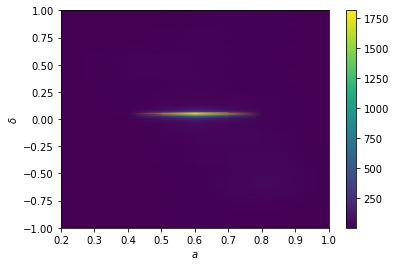

In [16]:
vmax=None
plt.pcolormesh(v_a, v_delta, far_field['y'].T, shading='gouraud', vmax=vmax)
plt.colorbar()

plt.xlabel(r"$a$")
plt.ylabel(r"$\delta$")

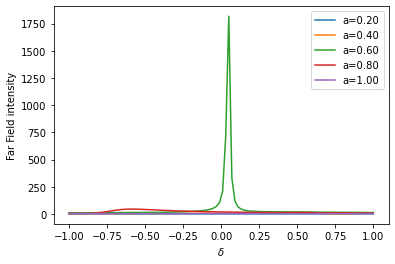

In [17]:
a_plot = [0.2,0.4,0.6,0.8, 1.]

for a in a_plot:
    i_a = np.argmin(np.abs(a-v_a))
    plt.plot(v_delta,far_field['y'][i_a],label='a={:.2f}'.format(v_a[i_a]))
#plt.plot(v_a,far_field_0['y'][:,i_delta], label = 'bare')
plt.xlabel(r"$\delta$")
plt.ylabel("Far Field intensity")
plt.legend()

#plt.savefig('first_results.pdf')

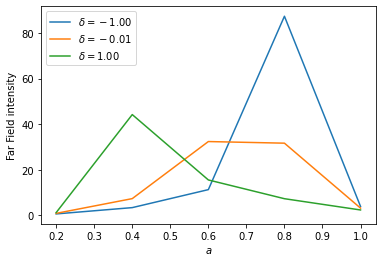

In [18]:
delta_plot = [-1., 0., 1.]

for delta in delta_plot:
    i_delta = np.argmin(np.abs(delta-v_delta))
    plt.plot(v_a,far_field['y'][:,i_delta],label=r'$\delta={:.2f}$'.format(v_delta[i_delta]))
#plt.plot(v_a,far_field_0['y'][:,i_delta], label = 'bare')
plt.xlabel(r"$a$")
plt.ylabel("Far Field intensity")
plt.legend()

In [8]:
nl = 128

def g(x):
    return np.cos(x)

def f(x):
    #time.sleep(1)
    return g(x)**2

start = time.time()
res = Parallel(n_jobs=-1 )(delayed(f)(i) for i in range(nl) )
print(time.time() - start)

start = time.time()
res = [f(i) for i in range(nl)]
print(time.time() - start)

1.0848000049591064
0.0004284381866455078


# Some OLD shit below

In [51]:


v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

far_field = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }
far_field_0 = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }

print("Obtaining samples of polarizations...\n")

bar = progressbar.ProgressBar(maxval=n_a*n_delta, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

count = 0
rng = default_rng()

start = time.time()
for i_a, a in enumerate(list(v_a)):
    for i_delta, delta in enumerate(list(v_delta)):

            
        # definition of local function for parallel sample collection
        def get_instance(dummy):
            # create array of random positions and resonances
            if rand_positions:
                v_x_exc = a*(rng.integers(0,L, size=N_exc) + rng.normal( scale=fr_a, size=N_exc) )
            else:
                v_x_exc = a*np.linspace(0.,N_exc-1.,N_exc)
            
            v_delta_exc = delta*( 1. + rng.normal( scale=fr_delta, size=N_exc) )

            # create matrix (\alpha G)_ij 
            v_alpha = alpha(v_delta_exc, gamma) # polarization of each emitter (with random delta for each one)
            x_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:]) # matrix of length difference |xi-xj|
            A = stack_xy(create_A(x_ij,v_alpha))

            # create vector p0 (with random sampled delta)
            p0_x = v_alpha*E*np.cos(pol_angle)
            p0_y = v_alpha*E*np.sin(pol_angle)
            v_p0 = np.concatenate((p0_x, p0_y), axis=None )

            # solve equations
            v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)

            return np.array([v_p, v_p0])

        if parallel:
            res = Parallel(n_jobs=n_proc)(delayed(get_instance)(ic) for ic in range(N_loop*cpuCount))
            res = np.array( res )
            pol_eff = res[:,0,:]
            pol_bare = res[:,1,:]
            #print(pol_eff.shape)
        else:
            pol_eff = []
            pol_bare = []
            for i in range(N_loop):
                res = get_instance(0)
                pol_eff.append( res[0] )
                pol_bare.append( res[1] )
            pol_eff = np.array( pol_eff )
            pol_bare = np.array( pol_bare )

        # process samples after collection
        pol_s = dict()
        pol_s['x'] = np.sum( np.array(pol_eff)[:,:N_exc], axis=1 )
        pol_s['y'] = np.sum( np.array(pol_eff)[:,N_exc:], axis=1 )
        
        pol0_s = dict()
        pol0_s['x'] = np.sum( np.array(pol_bare)[:,:N_exc], axis=1 )
        pol0_s['y'] = np.sum( np.array(pol_bare)[:,N_exc:], axis=1 )
        
        #print( np.array(pol_eff).shape )
        # save far-field
        for key in ['x', 'y']:
            far_field[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol_s[key])**2 )
            far_field_0[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol0_s[key])**2 )

        count += 1
        bar.update( count )

bar.finish()

print("processing time: {:.2f}s".format(time.time()-start))

<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=3.97126e-17): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=9.47695e-18): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)


Obtaining samples of polarizations...



<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=3.17825e-17): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=5.64535e-20): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=6.02715e-19): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=9.47906e-17): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=3.68417e-17): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)
<ipython-input-51-5a64e11b2d1f>:42: LinAlgWarning: Ill-conditioned matrix (rcond=4.67461e-17): result may not be accurate.
  v_p = linalg.solve(np.eye(2*N_

processing time: 9.77s


In [41]:
parallel = False

# The grid for reconstruction
x_min, x_max, n_x = -0.1*L, 1.1*(L-1), 256
z_min, z_max, n_z = 0., L, 128

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_z = np.linspace(z_min, z_max, n_z)
v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

cpuCount = os.cpu_count()
rng = default_rng()

count = 0

v_sa = np.zeros((n_a,n_delta))

bar = progressbar.ProgressBar(maxval=n_a*n_delta, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i_a, a in enumerate(list(v_a)):
    for i_delta, delta in enumerate(list(v_delta)):
    
        def get_instance(dummy):
            D_a = fr_a*a
            D_delta = fr_delta*np.abs(delta)
            v_x_exc = a*rng.integers(0,L, size=N_exc) + rng.normal( scale=D_a, size=N_exc)
            print(v_x_exc)
            v_delta = delta + rng.normal( scale=D_delta, size=N_exc)
            return scattered_amplitude(v_x_exc, v_delta, v_x, v_z)
        
        if parallel:
            sa = Parallel(n_jobs=-1)(delayed(get_instance)(i) for i in range(cpuCount))
        else:
            sa = get_instance(0)
        v_sa[i_a,i_delta] = np.mean(sa)
        
        count += 1
        bar.update(count)


[-8.60611274e-04  5.99991938e-01  6.01476636e-01  5.98389210e-01
  9.01062182e-01  8.00109960e-01  4.99663830e-01  2.99688486e-01
 -3.92762905e-04 -4.82579771e-04  3.99673526e-01  5.99283686e-01
  6.99647045e-01  4.01306360e-01  7.98046455e-01  1.99114732e-01
  1.01001777e-01  5.02269574e-01  4.00858735e-01  2.97887688e-01
  8.00352641e-01  7.01372378e-01  8.00980538e-01  3.00251683e-01
  6.00297642e-01  2.99911782e-01  7.00245763e-01  3.99549269e-01
  7.29419149e-04  7.01200817e-01  6.01303578e-01  4.00559872e-01
  9.85001538e-02  4.01200325e-01  2.00432650e-01  5.01743065e-01
  2.01128680e-01  1.01706247e-01  4.00897584e-01  7.99245069e-01
  7.01183878e-01  8.99902325e-01  5.01086799e-01  1.99207447e-01
  5.99131070e-01  4.00994991e-01  4.00663498e-01  1.02220755e-01
 -8.30329293e-04  4.00042585e-01]
[3.98413593e-01 8.97847911e-01 1.00448706e-01 7.99279278e-01
 4.99793916e-01 4.14487852e-04 1.00855498e-01 6.00550908e-01
 6.99744358e-01 8.00428779e-01 1.99962043e-01 4.00320176e-01
 2.

[ 7.02583020e-01  2.00312572e-01 -2.08996154e-03  1.02386877e-01
 -2.24338348e-05  5.00770114e-01  1.99990717e-01  1.00350703e-01
  3.01088218e-01  8.98501773e-01  1.00439729e-01  2.99639855e-01
  2.24120063e-03  9.00455580e-01  3.97539078e-01  5.00118388e-01
  6.00248035e-01  7.02551053e-01  6.99697181e-01  3.99293047e-01
 -1.41000755e-03  6.01997085e-01  2.45468497e-04  7.00236752e-01
  1.99754544e-01  3.01752308e-01  1.01165575e-01  4.02801183e-04
  8.99302294e-01  9.00471794e-01  8.00706522e-01  7.01403576e-01
  4.99023096e-01  6.01776583e-01 -2.22022456e-03  2.01226257e-01
  9.97063982e-02  2.00387355e-01  4.99557104e-01  1.99938031e-01
  7.99264804e-01  8.00182877e-01  6.00097374e-01  6.00656629e-01
  2.98293808e-01  8.98563454e-01  6.00715211e-01  6.99646610e-01
  9.93405874e-02  3.02294184e-01]
[ 2.97908319e-01  6.00391087e-01  5.01419772e-01 -1.38107001e-03
  4.98821652e-01  9.00232010e-01  7.98734845e-01  5.98400675e-01
  5.00441152e-01  8.00401983e-01  4.01751186e-01  1.2966

[ 9.83520282e-02  5.01301333e-01  1.98892659e-01  2.00061584e-01
  2.98618322e-01  3.98741600e-01  6.01013118e-01  4.99584567e-01
  8.00406934e-01  5.99168542e-01  1.99720897e-01 -5.42855465e-04
  2.01163624e-01  1.99567881e-01  2.01656306e-01  2.98955760e-01
  5.99502387e-01  2.01089714e-01 -1.66055186e-03  7.00593134e-01
 -2.11665357e-03  9.00006473e-01  1.00178107e-01  9.00697756e-01
  5.98257622e-01  1.00932288e-01  7.99098470e-01  4.99601488e-01
  8.00676170e-01  1.00678653e-01  1.00055870e-01  5.99786908e-01
  8.98971650e-01  4.01366227e-01  7.00911031e-01  5.00599430e-01
  4.00573208e-01  2.99337224e-01  6.99276896e-01  1.00332079e-01
  5.01608896e-01 -1.05747341e-03  3.99767940e-01  3.01148176e-01
  7.98721971e-01  7.99881254e-01  6.01809022e-01  4.01037578e-01
  6.00016958e-01  9.98321761e-02]
[ 9.94367489e-02 -2.40924194e-04  1.99276730e-01  1.99054531e-01
  7.01701845e-01  6.01477824e-01  1.00024062e-01  8.01084072e-01
  7.23586289e-04  2.99576274e-01  2.99503062e-01  4.9924

[-1.82549763e-04  6.99936839e-01  9.00885303e-01  7.99641757e-01
  9.00061823e-01  6.99659638e-01  2.99466652e-01  4.00598020e-01
  8.00525774e-01  6.00619722e-01  1.00588812e-01  9.92933214e-02
  8.98229535e-01  6.99407230e-01  1.99980980e-01  7.97741369e-01
  1.00539073e-01  9.14592930e-04  9.01488943e-01  4.00790670e-01
  4.98834418e-01  7.00561315e-01  3.00611195e-01  6.99437883e-01
  1.01967159e-01  1.99431177e-01  3.99355120e-01  7.99427214e-01
  7.00090238e-01  3.98872520e-01  8.00727680e-01  4.00729527e-01
  4.00024812e-01  2.00840019e-01  7.01653539e-01  2.99357345e-01
  8.00328377e-01  1.36427463e-03  6.98352440e-01  3.01473987e-01
  8.02316622e-01  8.98678016e-01  6.00148928e-01  6.00532724e-01
  8.98892992e-01  9.00045813e-01  1.99921595e-01  5.99955201e-01
  8.01345311e-01  2.99606737e-01]
[ 8.98511570e-01  4.00286671e-01  7.00799990e-01  3.00458962e-01
  3.99074135e-01  7.00899318e-01  9.95749108e-02  6.00584144e-01
  9.00623973e-01  5.00155290e-01  7.99277748e-01  3.1649

[ 5.00150787e-01  7.01686197e-01  7.98836863e-01  5.28409025e-04
  2.99754696e-01  3.99156831e-01  8.97417351e-01  1.99965578e-01
  4.99774097e-01 -2.43829701e-04  5.00548676e-01  5.99801655e-01
  2.99638816e-01  9.00511716e-01  8.13000387e-04  6.00441504e-01
  8.00763282e-01  3.00946940e-01  6.99598691e-01  6.48267733e-04
  5.23848432e-04  9.01207297e-01  9.01169784e-01  1.98214719e-01
  9.90790163e-02  5.01100224e-01 -2.00885536e-03  7.00146621e-01
  2.99632766e-01  6.01249441e-01  5.99555103e-01  5.99206656e-01
  3.00846991e-01  1.01291703e-01  9.83792492e-02  8.99308651e-01
  5.00025965e-01  4.99478182e-01  5.00941732e-01  6.99331802e-01
  7.00878741e-01  8.01303879e-01  6.98632396e-01  8.02409005e-04
  1.00658572e-01  3.99233041e-01  7.00772393e-01  3.99361078e-01
 -1.43454266e-03  9.00607596e-01]
[ 8.99015515e-01  5.00667526e-01  4.99791603e-01  9.94640513e-02
  3.99547330e-01  3.01166676e-01  4.99936820e-01  3.00660897e-01
  8.99990183e-01  5.00815863e-01  1.84290881e-03  9.0106

[ 2.98716651e-01 -8.15624956e-04  1.18653355e+00  5.93615106e-01
  4.44936819e-01  1.33237529e+00  1.18524321e+00  1.33289092e+00
  1.18448032e+00  8.87397772e-01  1.18610154e+00  5.92575456e-01
  2.97391823e-01  1.46988131e-01  1.33433383e+00  9.55833754e-04
  1.33439720e+00  1.33496409e+00  2.94957209e-01  8.88439514e-01
  1.33401363e+00  2.94572692e-01  8.88555306e-01  1.03884208e+00
  1.33325870e+00  1.33225883e+00  1.18571664e+00  7.42345877e-01
  4.44208619e-01  4.45500711e-01  4.47163224e-01  1.48866927e-01
  1.33624733e+00  5.39642823e-03  7.39138171e-01  1.33506005e+00
  1.33647216e+00  2.97137821e-01  4.43853242e-01  1.03787538e+00
  7.40908811e-01 -1.42934961e-03  1.03647776e+00  1.41905978e-03
  5.94694319e-01  1.03559975e+00  1.46001064e-01  1.03961231e+00
  5.91399063e-01  9.98500404e-04]
[ 7.44305601e-01  8.90243768e-01  1.18353809e+00  1.03856837e+00
  4.45192824e-01  1.48671734e-01  7.43030999e-01  1.33371600e+00
  1.18634927e+00  3.02859949e-04  1.18525672e+00  7.4288

[0.59185611 0.74199363 1.18493907 0.59390733 1.18869486 0.88998831
 1.03797482 1.03737951 1.33208639 0.29556422 0.14880719 0.59416793
 0.29628658 0.44169034 0.88953476 0.14793877 1.18545054 0.59319342
 0.29504088 0.1465153  0.15229666 0.74075062 1.0368526  0.88986843
 0.29492674 0.89166201 1.0373624  0.74145925 0.59131214 0.14890126
 0.5919095  0.89270772 1.3340404  1.18944628 0.29737102 1.18689951
 1.04114084 0.29880842 0.89002304 0.88783203 0.59349352 0.44392997
 0.59589997 0.58804362 0.29481835 0.14803529 0.88726125 0.15130564
 0.59232436 0.44469666]
[ 1.48477970e-01  2.92536282e-01  4.45610266e-01  5.91447605e-01
  7.42509853e-01  1.18802204e+00  1.33355818e+00  4.47225463e-01
  1.03698346e+00  1.03816138e+00  2.98694929e-01  2.92789484e-01
  1.18496356e+00  5.90343302e-01  4.40807933e-01  8.92087492e-01
  8.88586774e-01 -1.47633848e-03  5.92842461e-01  1.33160452e+00
  1.04008475e+00  5.94626233e-01  1.03832154e+00  5.94643025e-01
  5.95114688e-01  2.28924531e-03  2.96670828e-01  

[ 4.75796265e-04  2.97047175e-01  8.90325306e-01  7.43250018e-01
 -1.06016016e-03  7.38572087e-01 -7.00752970e-04  2.96230184e-01
  1.18714327e+00  1.03859020e+00  4.46947948e-01  5.94549204e-01
  1.18508603e+00  1.33418831e+00  5.92335334e-01  1.03652207e+00
  8.89843555e-01  1.03846297e+00  4.44506862e-01  2.96045698e-01
  1.33531787e+00  1.18349834e+00  5.94231486e-01  1.03774444e+00
  1.18704787e+00  2.97649802e-01  2.96663579e-01  1.04699369e-03
  1.18554155e+00  7.41554250e-01  1.33421926e+00  5.92949345e-01
  8.89177774e-01  1.03710160e+00 -2.69759707e-03  1.44346526e-01
  1.18493035e+00  1.47150508e-01  1.18454865e+00  1.03806050e+00
  2.97246957e-01  7.43096773e-01  1.33493451e+00  1.49894042e-01
  2.96733333e-01  7.45209625e-01  8.88477209e-01  1.18733839e+00
  1.49187276e-01  1.49943834e-01]
[ 1.18637623e+00 -9.91656224e-04  5.93038092e-01  4.46795693e-01
  1.18761498e+00  1.18639660e+00  1.33282152e+00  5.94563485e-01
  2.93683938e-01  5.91076659e-01  7.94856559e-04  7.4343

[ 4.44148688e-01  1.18531409e+00  1.48324493e-01  2.94382121e-01
  1.12529345e-03  1.48346399e-01  2.97925542e-01  4.45556618e-01
  4.45210929e-01  8.88521946e-01  1.18681062e+00  1.03816071e+00
  4.43180657e-01  2.95842303e-01  7.39984361e-01  1.47774662e-01
  1.49512363e-01  5.91713684e-01  2.73963352e-04  1.18656584e+00
  1.18554407e+00  7.41322181e-01  1.03522237e+00 -2.27519584e-04
  9.33547944e-04  2.96426740e-01  5.81741198e-04  4.45153909e-01
  7.41823362e-01  8.89330122e-01  1.47586541e-01  2.68211295e-03
  1.18587004e+00  1.33294741e+00  7.44673244e-01  1.18477660e+00
 -6.69011808e-05  1.33307003e+00  1.33447445e+00  1.33422885e+00
  1.03613722e+00  1.45132482e-01  4.45564661e-01  1.33398885e+00
  1.03908171e+00  8.89419368e-01  1.33581518e+00  8.90314375e-01
  1.33321613e+00  1.90145871e-03]
[ 8.91120404e-01  4.44230032e-01  8.90019637e-01  1.52322021e-01
  2.94326049e-01  5.94442212e-01 -1.41612435e-03  1.50533016e-01
  4.43859185e-01  1.48932391e-01  1.47007095e-01  8.9075

[ 7.86554433e-01  1.57130171e+00  1.76557066e+00  1.57395022e+00
  3.94985367e-01  1.37886857e+00  2.69448904e-03  3.93168738e-01
  3.94683676e-01  5.89568071e-01  1.37936038e+00  3.90771185e-01
  1.96415745e-01  1.96002049e-01  7.83881474e-01  1.57254840e+00
  1.77023729e+00  5.89913928e-01  1.37558116e+00  2.00632594e-01
  9.81184613e-01  7.85941622e-01  1.96289814e-01  1.17838871e+00
  3.95119971e-01  7.90196367e-01  1.96322996e-01 -5.42695355e-04
  1.37607035e+00  1.76664440e+00  5.88697275e-01  1.94719396e-01
  1.76698971e+00  1.76435907e+00  7.83263588e-01  3.91527776e-01
  1.18102400e+00  1.97018355e-01  5.91884594e-01  1.95131640e-01
  1.97557653e-01  3.94276110e-01  7.85341901e-01 -4.42358932e-03
  1.76984326e+00  1.18131587e+00  9.82697133e-01  3.92499868e-01
  1.76698621e+00  1.95775561e-01]
[ 1.97628322e-01  1.37588250e+00  1.18221951e+00  1.77068105e+00
  1.17933105e+00  1.17914688e+00  1.76755128e+00  1.18127249e+00
  1.59882686e-04 -9.36247073e-05  7.85780588e-01  3.9324

[ 1.98957769e-01  1.57275730e+00  1.76862064e+00  1.56720601e+00
  3.89327631e-01  1.37594528e+00  1.37766216e+00  1.77282983e+00
  1.37507584e+00  1.77158738e+00  3.92298852e-01  2.11203318e-04
  1.17904373e+00  3.92585517e-01  1.76724235e+00  1.57105012e+00
  5.89827871e-01  7.85561626e-01  1.76909192e+00  1.17530905e+00
  3.93568271e-01  5.88694950e-01  1.57066020e+00  9.82255082e-01
  1.76997138e+00  7.88631748e-01  1.57683661e+00  1.99047892e-01
  9.83878131e-01  1.76972961e+00  1.57267582e+00  5.86854820e-01
  1.17840065e+00  9.80768833e-01  1.57153575e+00  3.96223086e-01
  1.37505041e+00  1.17877176e+00 -1.70740682e-03  1.57616495e+00
  7.85996279e-01  1.77055827e+00  1.37783715e+00  7.84296797e-01
  7.87017297e-01  5.90015268e-01  1.57219530e+00  1.95840141e-01
  1.17900479e+00  3.94479315e-01]
[ 9.83656040e-01  1.98280416e-01  5.85698225e-01  1.17994011e+00
  1.18154257e+00  1.18205008e+00  1.76531971e+00  1.37393793e+00
  7.85484144e-01  1.57206983e+00  1.77066308e+00  1.9721

[ 3.94425590e-01  5.90201922e-01  1.17881328e+00  1.57240697e+00
  5.88194433e-01  1.17949917e+00  9.85186148e-01  7.84602662e-01
  9.82363714e-01 -2.52130441e-03  1.18101934e+00  1.37719316e+00
  1.94378556e-01  3.90531858e-01  1.96382505e-01  9.83497510e-01
  5.90869875e-01  1.95773258e-01  3.90164532e-01  1.57072392e+00
  1.76834189e+00  1.18064424e+00  1.76783467e+00  1.98356963e-01
  9.85800475e-01  1.17831659e+00  1.18173522e+00  1.94460853e-01
  9.79861956e-01  1.57536236e+00  1.18140624e+00  1.57101255e+00
  1.37642934e+00  9.84001642e-01  1.57421438e+00  5.92351459e-01
  3.96104972e-01  5.91001674e-01  8.72778279e-04 -3.71599560e-04
  1.94612641e-01  1.95803861e-01  5.91107034e-01  5.92252474e-01
  9.85164590e-01  1.57418253e+00  1.93519412e-01  1.98958137e-01
  7.85457064e-01  1.57064762e+00]
[ 1.96688560e-01  2.73816674e-04  3.95843473e-01  1.37606833e+00
  1.76946968e+00  5.88306627e-01  1.57033900e+00  5.91589799e-01
  3.94410853e-01  1.77023335e+00 -1.34999157e-03  1.3749

[ 1.57353405  0.19516509  0.19746635  0.98224467  1.56933923  0.59105893
  0.00231641  1.37336706  1.37551769  0.98308946  0.39269818  0.39416744
  1.77315893  1.37428652  1.5717153   0.39397139  0.59141433  0.1960209
  1.17813106  0.19440781  0.19254598  0.78490462  1.37584227 -0.00529907
  1.37623106  1.1815387   0.5920501   1.18282589  0.00306891  0.39391078
  0.39105987  1.57611854  1.37403416  1.37498879  0.19586153  1.17906682
  1.17745402  1.76906068  1.17838998  0.58953141  1.76597508  0.59002954
  0.58991737  1.76906436  0.39232756  1.17814427  1.76922794  1.37626962
  0.98039359  0.39425571]
[ 7.83682007e-01  1.17849783e+00  1.57337818e+00  1.18022290e+00
  1.94852051e-01  1.17687985e+00  1.76685154e+00  9.84068047e-01
 -2.27912308e-03  1.57240762e+00  1.77080741e+00  1.98703244e-01
  1.76905351e+00  1.77110357e+00  1.94005385e-01  1.57539992e+00
  1.99470033e-01  1.96813472e-01  5.89537822e-01  3.96375111e-01
  1.53427891e-03  4.29935793e-03  1.37334508e+00  1.91788116e-04
 

[ 2.20169525e+00  2.20328277e+00  2.40403759e-01 -1.26797483e-03
  2.20687703e+00  1.95536267e+00  1.71568694e+00  1.22614830e+00
  1.22583704e+00  1.46608021e+00  1.71410361e+00  1.95653958e+00
  1.22052677e+00  1.47507191e+00  9.77820486e-01  7.38852241e-01
  2.44535256e-01  1.22125450e+00  1.95836609e+00  7.36483844e-01
  9.81055167e-01  1.22554223e+00  2.20442985e+00  1.22561707e+00
  1.22430533e+00  1.71606345e+00  1.22000849e+00  9.79363477e-01
  1.22263438e+00  4.94875352e-01  2.20351763e+00  2.20162331e+00
  2.20660595e+00  1.96101442e+00  1.96061637e+00  1.22369830e+00
  9.79162537e-01  1.47201747e+00 -6.04694995e-04  1.95784968e+00
  1.22604046e+00  1.22089826e+00  1.95876749e+00  4.89105069e-01
  2.46986972e-01  1.46569891e+00  1.95972619e+00  2.43495616e-01
  1.96000704e+00  1.46770551e+00]
[ 9.74385764e-01  1.22564919e+00  1.22652057e+00  7.39379823e-05
  1.71397968e+00 -2.95551768e-03  1.95859678e+00  4.91232757e-01
  2.20413926e+00  4.88991586e-01  7.34720051e-01  4.8796

[ 1.96093147e+00  7.34311643e-01 -1.99433914e-03  1.96022766e+00
  1.95959763e+00  7.35501789e-01  9.84033714e-01  2.20138360e+00
  2.20212369e+00  1.95162734e+00  1.22413877e+00  2.20123161e+00
  1.71276012e+00  7.33574858e-01 -1.26777668e-03  7.37536820e-01
  4.87281595e-01  9.76839030e-01  9.80282801e-01  4.89388599e-01
  1.22451438e+00  9.80281150e-01  4.88068859e-01  4.87936054e-01
  1.71896953e+00  4.88719013e-01  1.95931508e+00  1.46686048e+00
  4.91087384e-01  1.96307761e+00  1.95313854e+00  4.85996548e-01
  4.97183189e-01  1.46895298e+00  2.37083530e-01  2.20246911e+00
  1.22483640e+00  4.91431126e-01  2.20419468e+00  1.46832786e+00
  4.88949652e-01  7.35284839e-01  4.90228666e-01  1.95872450e+00
  4.87116785e-01  4.76842451e-03  1.96059976e+00  2.47208208e-01
  1.95947671e+00 -4.03716409e-03]
[ 1.46921821e+00 -3.26430135e-03  9.76576063e-01  2.46586762e-01
  4.92804975e-01  4.90421284e-01 -2.80682580e-04  1.22456204e+00
 -2.84713370e-03  1.47289084e+00  1.71334445e+00  4.8986

[ 0.23905175  0.48835662  0.49178371  0.73158219  0.97814791  0.49146316
  0.48913361  0.24613347  0.24546401  0.98427376  1.46498447  0.00363097
  0.73558849  1.22646798  0.24581247 -0.00294786  2.20209501  0.48429928
  0.24263844  1.71366296  0.49113967  0.24109867  1.71157343  0.48953979
  0.49126074  0.73592522  0.73514481  0.73527217  1.22230525  1.22312897
  1.22169581  2.20263594  1.95911594  0.24628029  1.46947496  0.73161415
  2.20021607  0.73550224  0.73450148  0.97880457  0.97410157  1.224974
  1.71973811 -0.00238826  1.22419965  1.71431848  1.95800178  0.24613996
  0.49249178  1.47091876]
[ 1.95989653e+00  2.42736593e-01  7.35014069e-01  2.44557980e-01
  9.74555497e-01  1.71465230e+00  4.92818378e-01  1.95379792e+00
  1.96155608e+00  9.74862336e-01 -8.12590131e-04  4.89805112e-01
  9.75444791e-01  9.82665657e-01  2.45760424e-01  7.33548034e-01
  1.96188630e+00  2.46086169e-01  2.40603273e-01  1.71657975e+00
  1.46465184e+00  7.35053373e-01  1.95645064e+00  3.59889564e-03
  

[ 9.79399345e-01  4.84901764e-01  2.20567162e+00  9.78109245e-01
  1.95803248e+00  1.22494772e+00  1.46997938e+00  7.34531458e-01
  1.96045440e+00  1.46964219e+00 -3.28141266e-03  1.71045332e+00
  1.47127078e+00  4.90421697e-01  9.84154135e-01  4.91464994e-01
  2.20553308e+00  2.46706873e-01  7.34134622e-01  2.41768671e-01
  1.95544499e+00  1.22471040e+00  9.80779810e-01  7.36927571e-01
  1.22067351e+00 -2.26450485e-03  1.71587169e+00  2.20544942e+00
  1.71676709e+00  1.22300010e+00  1.71448201e+00  1.22238079e+00
  9.80883496e-01  1.47315023e+00  1.47004726e+00  4.89304417e-01
  1.46389980e+00  1.71207044e+00  7.33226327e-01 -6.74567105e-04
  7.34569184e-01  1.47032555e+00  1.71208126e+00  4.88724414e-01
  1.22526896e+00  3.42590889e-03  9.76586410e-01  1.46808986e+00
  1.22284235e+00  1.71799300e+00]
[ 0.24870917  1.95868393  1.46648747  0.73436351  2.20632183  0.4917459
  1.71606267  0.97857311  1.22463343  0.49298855  0.73456317 -0.00358945
  1.95851614  2.20287435  2.20726567  1.7

[ 2.34177050e+00  1.16685103e+00  8.75654995e-01  5.91903716e-01
  1.76013930e+00  2.64133885e+00  2.05251480e+00  2.34460521e+00
  2.96783528e-01  2.34414716e+00  1.75836328e+00  2.05479049e+00
  2.05311010e+00 -1.33297893e-03  1.17246773e+00  2.05065600e+00
  1.46874272e+00 -4.15512467e-03  2.33978961e+00  1.46438467e+00
  1.46635999e+00  8.81622557e-01  8.81423555e-01  9.59309628e-05
  8.74829349e-01  5.84418437e-01  2.95946622e-01  3.19669010e-03
  2.64025998e+00  2.04928351e+00  1.46536713e+00 -4.44195419e-03
  1.76601754e+00  1.46003766e+00  2.90719072e-01  2.34493288e+00
  2.05818878e+00  2.92312784e-01  2.34667787e+00  1.46748650e+00
  2.34598092e+00  8.81601375e-01  5.84077326e-01  5.84459535e-01
  2.95088304e-01  1.17419034e+00  1.76233759e+00 -1.17940759e-03
  2.34471248e+00 -2.02957238e-04]
[ 2.05315400e+00  1.75515998e+00  1.75624240e+00  8.81879187e-01
  6.23761438e-04  2.90603468e-01  5.86086790e-01  1.76257828e+00
  2.04875088e+00  1.76011808e+00  1.75648282e+00  8.8029

[ 1.75841329e+00  8.76423085e-01  2.94582642e-01  6.12098721e-05
  2.04968763e+00  2.97336628e-01  5.89121033e-01  5.84299250e-01
 -5.43564362e-03 -9.93800575e-04  1.16727949e+00  2.34808235e+00
  1.46789570e+00  5.90663748e-01  5.81452195e-01  2.34289202e+00
  2.63736578e+00  1.46309426e+00  1.75973404e+00  1.46505612e+00
  1.46479850e+00  1.46245439e+00  2.05190740e+00  5.86099388e-01
  2.63710610e+00  5.85502175e-01  2.63972394e+00  1.46341690e+00
  1.46729179e+00  2.63673649e+00  1.17477227e+00  1.43052593e-04
  1.75899030e+00  2.04924308e+00  1.17400918e+00 -2.01785664e-03
  1.75452849e+00  2.63353673e+00  4.02365165e-03  1.76146346e+00
  1.47475942e+00  1.17570290e+00  1.75512462e+00  3.75836727e-03
  2.04870298e+00  6.73262408e-03  5.90026285e-01  2.80619883e-03
  2.34351441e+00  8.74915848e-01]
[ 2.34473701e+00  2.96742498e-01  2.63922303e+00  2.34729130e+00
  2.63460026e+00  1.16962331e+00  8.75193740e-01  8.81471000e-01
  2.34790151e+00  5.89948307e-01  1.75795591e+00  1.2811

[ 1.17715337e-03  2.08813253e-03  8.80826709e-01  2.34668787e+00
  2.04719959e+00  5.86203098e-01  8.81709954e-01  2.92283536e-01
  1.46722088e+00  2.63728730e+00  1.75498316e+00 -8.40108568e-04
  1.76038776e+00  2.04781582e+00  2.63637263e+00  2.63901308e+00
  2.00517617e-03 -3.67110407e-04  2.34742654e+00  1.17416202e+00
  2.92233369e-01  1.16833628e+00  1.76431958e+00  1.75637541e+00
  2.05217894e+00  2.93247305e-01  5.89909034e-01  1.46682478e+00
  1.16762321e+00  1.75815299e+00  2.64041962e+00  5.80790486e-01
  5.86023396e-01  5.85857842e-01  8.75458484e-01  1.46321990e+00
  2.04762797e+00  2.63981693e+00  1.16823738e+00  2.93129429e-01
  8.79800830e-01  5.87567716e-01  5.86925070e-01  2.34605490e+00
  2.63991138e+00  1.17239261e+00  2.64399459e+00  1.46373177e+00
  1.17834089e+00  3.97266828e-03]
[ 1.46623308e+00  1.17421763e+00  8.77914815e-01  2.97200473e-01
  2.64114097e+00  1.75871259e+00  2.63899226e+00  2.05251759e+00
  2.34558292e+00  5.86171958e-01  1.76050880e+00  1.1725

[ 1.75485579e+00  1.76041678e+00  1.46713137e+00  8.81606086e-01
  2.64108108e+00  2.63586627e+00  2.63614180e+00  8.81485643e-01
  2.04948487e+00  2.05211537e+00  2.91433490e-01  2.63967933e+00
  1.46720013e+00  8.78042901e-01  1.46466883e+00  5.85527605e-01
  5.84771647e-01  4.08267577e-03  4.23261225e-03  8.79897867e-01
  5.82730590e-01  8.74868523e-01  2.63620525e+00  5.85834817e-01
  2.34405534e+00  2.05544504e+00  1.75873359e+00  5.85369051e-01
  1.46656132e+00  2.64103671e+00  2.93619067e-01  2.63734227e+00
 -2.98903825e-03  2.04380668e+00  8.80761257e-01  1.17221433e+00
  2.33940712e+00  1.46521217e+00  8.80369918e-01  1.46064226e+00
  2.63448618e+00  2.92797508e-01  1.75951678e+00  2.35186515e+00
  1.46897716e+00  1.46209350e+00  2.64208139e+00  2.91456590e-01
  2.05236086e+00 -8.14854692e-04]
[ 2.63642933e+00  8.80836743e-01  1.46284988e+00  2.89430730e-01
 -3.06861286e-03  2.63729484e+00  2.64187898e+00  2.64203135e+00
  2.34583292e+00  2.34282694e+00  2.63721633e+00  1.7573

[ 5.89183152e-01  2.05076110e+00 -9.97722110e-04  1.07764638e-03
  8.83909290e-01  1.76253592e+00 -6.93985166e-04  2.04938459e+00
  2.33603714e-03  2.63755314e+00  5.84158441e-01  2.34575990e+00
  2.05283869e+00  1.17846248e-03  2.05643787e+00  8.81556388e-01
  1.17567025e+00  8.84536561e-01  2.05075634e+00  8.80790083e-01
  2.63580602e+00  2.89850429e-01  1.76021219e+00  8.81108221e-01
  4.99318428e-03  5.83158473e-01  2.63919547e+00  1.46675096e+00
  2.34719494e+00  8.78361164e-01  1.75277056e+00  1.17144674e+00
  1.62704136e-03  1.46431388e+00  1.31094666e-03  1.75688703e+00
  2.91720581e-01  1.46802005e+00 -4.31544672e-04  1.46981294e+00
  2.33976146e+00  8.80093497e-01  5.88791306e-01  1.75829157e+00
  5.85837202e-01  1.75865645e+00  2.05278254e+00  2.04682699e+00
  6.64940554e-04  5.91378412e-01]
[ 1.75916749e+00 -4.83350617e-03  8.76070558e-01  2.34494256e+00
  5.92811468e-01  2.90725541e-01  1.46280906e+00  1.17247286e+00
  1.46533532e+00  2.92422182e-01  2.34267313e+00  5.8853

[ 3.35613694e-01  2.73346413e+00  1.70971644e+00  1.36711692e+00
  3.41554876e-03  3.07123572e+00  2.73372897e+00  1.02154652e+00
  2.39381526e+00 -5.30512477e-05  2.72692020e+00  6.85328443e-01
  1.36264704e+00  6.83197681e-01  2.04220898e+00  3.43083536e-01
  2.38990092e+00  3.41207902e-01  1.02261871e+00  6.78043093e-01
  2.73234150e+00  6.79914355e-01  1.02584700e+00  2.73087925e+00
  3.07373043e+00  6.81595341e-01  6.81459910e-01 -3.07008834e-03
  1.36307002e+00  1.36682268e+00  1.70846205e+00  2.39269179e+00
  3.07158641e+00  3.07080433e+00  1.70589990e+00  2.04063627e+00
  3.07971871e+00  2.72886571e+00 -2.35262218e-03  6.82379325e-01
  2.39082567e+00  2.72851033e+00  2.39384893e+00  2.38330414e+00
  2.73219395e+00  2.38675462e+00  1.02511932e+00 -6.43618213e-03
  1.70576550e+00  1.70280316e+00]
[ 1.36627842e+00  3.06866373e+00  3.07221541e+00  1.70884533e+00
  1.03102496e+00  1.35617153e+00  3.40424036e-01  2.73239524e+00
  3.35177805e-01  2.38567279e+00 -2.27219555e-03  1.3912

[ 2.39038625e+00  6.82067525e-01  1.36345259e+00  3.07572425e+00
 -6.76768725e-04  2.39248982e+00  1.36644411e+00  6.79732265e-01
 -2.34968180e-03 -3.41359412e-03  2.04464944e+00  2.73344448e+00
  2.05500459e+00  2.39676249e+00  1.36405901e+00  2.39567821e+00
  2.73567482e+00  2.73515384e+00  1.02317762e+00  2.38898793e+00
  1.35909190e+00  1.70426476e+00  3.42145732e-01  1.70449273e+00
  1.36531740e+00  1.01961757e+00  6.83168158e-01  1.70954578e+00
  1.02815142e+00  3.42113920e-01  3.43965255e-01  6.81524884e-01
  6.83477132e-01  2.05165282e+00  3.07262279e+00  2.38445147e+00
  2.73654416e+00  1.36573247e+00  6.89151050e-01  6.85840793e-01
  1.70782623e+00  2.72998822e+00  2.04924371e+00  2.05124478e+00
  1.36549215e+00  2.38272683e+00  2.73021969e+00  1.36847070e+00
  2.04956093e+00  1.71125908e+00]
[ 2.73221272e+00  2.39316557e+00  2.72944246e+00  1.70776411e+00
 -3.34917014e-06  2.38810627e+00  1.70887375e+00  1.96920779e-03
  1.02152405e+00  1.36336996e+00  6.86103618e-01  3.0668

[2.73218595e+00 7.79677491e-04 3.39411706e-01 2.38900340e+00
 1.36877089e+00 2.73598990e+00 2.74272871e+00 2.73527806e+00
 2.05076891e+00 1.02366949e+00 1.36382371e+00 2.04705390e+00
 2.72676775e+00 1.36731019e+00 1.02361340e+00 1.70857296e+00
 1.36808171e+00 1.70482729e+00 3.06944954e+00 1.71213849e+00
 6.85713864e-01 2.38907318e+00 3.40835602e-01 2.04863646e+00
 2.73280166e+00 1.70693137e+00 9.22892884e-06 3.07401864e+00
 1.01914584e+00 6.88405004e-01 6.82824276e-01 1.02365804e+00
 2.73524381e+00 1.02556600e+00 3.07630161e+00 3.41037082e-01
 2.73305903e+00 3.49018181e-01 1.70675431e+00 1.02649452e+00
 3.07073874e+00 3.36613402e-01 2.39267810e+00 1.70839812e+00
 3.36144280e-01 1.01844393e+00 9.83292059e-04 1.02223608e+00
 4.40927212e-03 3.07885687e+00]
[ 1.02571662e+00  2.39199929e+00  3.38533152e-01  3.06765214e+00
  1.37483236e+00  1.49911363e-03  1.02023263e+00  1.37212658e+00
  2.04279962e+00  1.02799710e+00  2.73480417e+00  5.21336105e-03
  3.07170273e+00  1.70309120e+00  6.86277

[ 2.73764965e+00  3.07021163e+00 -8.15061748e-03  1.02671502e+00
  1.70475666e+00  2.38479272e+00  2.73630304e+00  1.02085317e+00
  3.07156123e+00  3.07699691e+00  1.02470655e+00  2.39057093e+00
  1.02529392e+00  2.72547556e+00  3.37722900e-01  2.05060347e+00
  2.04751565e+00  1.70791549e+00  1.36833392e+00 -2.33827167e-03
  1.37008868e+00  2.05089116e+00  3.40461700e-01  6.83571252e-01
  3.07395619e+00  2.05081476e+00  3.41651470e-01  1.36843227e+00
  1.02306064e+00  3.06716798e+00  8.41753334e-03  6.79834114e-01
 -2.89462216e-03  1.70424582e+00  2.38824185e+00  1.01745269e+00
  6.85044823e-01  1.36913025e+00  1.03002107e+00  1.37004992e+00
  3.35688750e-01  6.80924026e-01  6.86231054e-01  3.07289110e+00
  1.02281143e+00  1.02376932e+00  4.52468073e-03  3.06634725e+00
  1.02990564e+00  1.02254272e+00]
[ 1.70300435e+00 -1.03019471e-03  2.39016872e+00  1.70644656e+00
  1.70874686e+00  3.41609984e-01  1.36342497e+00  1.70997233e+00
  1.02931193e+00  3.41322781e-01  2.05277270e+00  6.8985

[2.39213596e+00 6.83917969e-01 2.39026974e+00 2.39182788e+00
 3.38364804e-01 2.94753373e-03 3.40422246e-01 6.82990637e-01
 1.70829261e+00 2.72518680e+00 3.06952947e+00 2.73736789e+00
 3.06798913e+00 2.73408697e+00 5.69126683e-04 3.41052767e-01
 2.05052729e+00 2.73799393e+00 6.80770083e-01 2.04823963e+00
 2.38946637e+00 1.36097278e+00 2.72734444e+00 1.02878962e+00
 2.04917222e+00 1.02608281e+00 1.02209058e+00 6.81664014e-01
 2.73260034e+00 1.70781866e+00 3.45107090e-01 1.02318310e+00
 3.42830067e-01 1.02226183e+00 1.36204781e+00 2.04246005e+00
 1.71083971e+00 3.07437615e+00 3.06772062e+00 2.39353459e+00
 2.72734788e+00 3.43716572e-01 1.70697949e+00 2.72848752e+00
 6.77364167e-01 1.36135178e+00 2.38902423e+00 3.07050372e+00
 2.72825688e+00 2.39560004e+00]
[ 1.70439701e+00  1.71176871e+00  1.70690000e+00  6.82632099e-01
  1.36637793e+00  1.70833350e+00  2.39187706e+00  1.02271276e+00
  6.02833576e-04  1.02365301e+00  1.02267038e+00  1.70825177e+00
  1.02668571e+00  1.70396247e+00  2.73170

[ 1.16962783e+00  1.03211822e-02  3.99396926e-01  1.55432517e+00
  2.33937552e+00  3.98367346e-03  3.50702838e+00  3.50369247e+00
 -3.85719493e-03  1.30464192e-03  1.17336933e+00  1.02940963e-03
  1.16592044e+00 -1.45049588e-03  2.73216171e+00  3.50898341e+00
  1.55519020e+00  2.34401965e+00  1.17348727e+00  3.11032852e+00
  3.35619649e-04  1.16446791e+00  1.94368500e+00  3.11864117e+00
  2.72268922e+00 -6.33788133e-03  7.79982830e-01  1.55396969e+00
  3.11373003e+00  3.51134392e+00  3.86010166e-01  1.55920106e+00
  3.90972267e-01  2.03701685e-03  2.72161811e+00  1.55820526e+00
  1.55318220e+00  2.33609270e+00  1.16952512e+00  1.16589612e+00
  3.11439968e+00  1.94575890e+00  1.55966695e+00  7.76869615e-01
  3.12255191e+00  1.17804656e+00  3.12334178e+00  3.84366675e-01
  1.55971795e+00  7.85805226e-01]
[ 3.90595949e-01  3.11640419e+00  3.11668787e+00  1.55922774e+00
  1.94569662e+00  2.34347327e+00  7.77337894e-01  3.95074290e-01
  3.50698924e+00  1.56109552e+00  2.73031683e+00  1.9533

[ 1.94762999e+00  2.72864152e+00  1.17054904e+00  1.16958969e+00
  2.72739535e+00  1.56108491e+00  1.94353269e+00  7.78894498e-01
  3.11298757e+00  2.73075313e+00  1.55705526e+00 -2.26950596e-03
  3.11052587e+00  1.94016115e+00  7.82895052e-01  7.80204490e-01
  2.33166599e+00  2.72787878e+00 -8.25734003e-03  1.56402954e+00
  3.90928868e-01  3.93239552e-01  2.33871242e+00  6.02008031e-03
  2.72838770e+00  1.16977605e+00  7.92615610e-01  3.50938000e+00
  2.72502187e+00  3.50500163e+00  2.72842840e+00  1.16744631e+00
  2.34119509e+00  2.34069161e+00  2.34636759e+00  7.77496769e-01
  3.10939111e+00 -8.90371072e-03  3.12064787e+00  3.97271169e-01
  1.17298864e+00  1.95087314e+00  3.11232932e+00  1.95242155e+00
  3.87873642e-01  1.17048219e+00 -5.68582011e-04  1.94947133e+00
  3.11960829e+00 -7.54548794e-04]
[ 3.12305509e+00  1.18063931e+00  1.94519550e+00  2.34041561e+00
  3.89636179e-01  4.54634080e-03  3.50665404e+00  3.12079979e+00
  2.33733825e+00  2.72480601e+00  3.94360214e-01  3.5296

[ 2.72669204e+00  1.55744247e+00  3.50698791e+00  2.72388997e+00
  7.76199535e-01  3.50709397e+00 -1.21336939e-03  1.16945467e+00
  1.16361981e+00  1.17366674e+00  1.17316705e+00  1.55806920e+00
  3.50414842e+00  1.55250142e+00  1.17114991e+00  3.95357955e-01
  3.11689053e+00  3.50544454e+00  3.89400627e-01  2.33607836e+00
  2.33897330e+00  1.94484621e+00 -3.02331463e-03  7.80219409e-01
  1.55833247e+00  3.11892564e+00  3.12238501e+00 -3.34381793e-03
  1.55749314e+00  1.94973537e+00  1.55456354e+00  2.72630517e+00
  1.55791443e+00  7.82697792e-01  1.17051560e+00  3.12586014e+00
  3.11645637e+00  3.90221533e-01  3.82529826e-03  3.89325393e-01
  4.15656862e-05  1.17630189e+00  1.55908245e+00  1.55909461e+00
  1.56171076e+00  2.33425754e+00  1.55503366e+00  1.94073692e+00
  1.94569154e+00  3.91208516e-01]
[-2.38882712e-03  3.50515796e+00  1.16419041e+00  2.73092661e+00
  7.77045016e-01  2.33836705e+00  1.55818203e+00  1.95499311e+00
  1.17428778e+00  1.16931709e+00  3.11916890e+00  7.7635

[ 1.94640964e+00  7.77781121e-01  2.54436771e-03  3.84253691e-01
  2.72169827e+00  1.94954917e+00  2.72679650e+00  1.55672824e+00
  3.11881499e+00  2.72914432e+00  1.95130736e+00  3.50676654e+00
  3.50299687e+00 -5.62045418e-04  1.94718389e+00  3.11888878e+00
  2.33721612e+00  1.55708223e+00  3.93361819e-01  2.72880165e+00
  2.33781091e+00  3.50390214e+00  3.92264027e-01  1.94519547e+00
  1.94701025e+00  3.12259599e+00  2.73245651e+00  7.71977034e-01
  3.93567900e-01  2.73174977e+00  2.33632559e+00  3.50537560e+00
  3.10948926e+00  1.94947752e+00  7.72798304e-01  2.72498926e+00
  1.94536818e+00  7.74719625e-01  7.79779321e-01  7.85920441e-01
  2.01950577e-03  7.78602917e-01  3.50922471e+00  2.33838541e+00
  7.88018018e-01  1.95232588e+00  1.55455183e+00  4.29436232e-03
  1.94603536e+00  3.11285386e+00]
[ 1.16811117e+00  3.93422681e-01  3.50517039e+00  3.11267400e+00
  3.50084642e+00  3.88856957e-01  3.94779046e-01  2.33591580e+00
  1.55789931e+00  7.80570919e-01  1.16163393e+00  2.7342

[-3.22019933e-04  7.74945036e-01  3.89758636e-01  9.14048815e-04
  3.11745564e+00  1.95095383e+00  3.93327321e-01  2.33666495e+00
  3.11670478e+00  2.73400838e+00  6.04674122e-04  3.50574050e+00
  1.16701587e+00  2.33154611e+00  7.82152202e-01  2.72680323e+00
  1.95319555e+00  3.85323389e-01  3.11743094e+00  1.25709842e-03
  1.95139935e+00  3.50269465e+00  1.17403931e+00  7.80990298e-01
  2.72626838e+00  3.50009196e+00  3.50948446e+00  1.56564109e+00
  2.33959739e+00  7.80932945e-01  1.55838132e+00  7.81974944e-01
  2.72470431e+00  5.57153235e-03  1.55671940e+00  3.87673674e-01
  3.89921783e-01  7.82268141e-01  1.94853560e+00  1.55293995e+00
  1.94888734e+00  2.33351864e+00  3.50876061e+00  1.56035010e+00
  3.50352314e+00 -1.89849918e-03  1.94457103e+00  2.33482878e+00
  3.12431694e+00  1.94822025e+00]
[ 1.56549554e+00  1.86309311e-04  2.33529969e+00  2.72982838e+00
  3.50932705e+00  2.73540551e+00  2.72813891e+00  2.34053674e+00
  1.94662809e+00  2.33920885e+00  3.11450459e+00 -4.2585

[ 4.36868500e-01  3.50173906e+00  4.91271433e-04  4.32979061e-01
  8.74460389e-01  1.75576914e+00  1.74013901e+00  3.50246625e+00
  1.75720533e+00  1.75399819e+00  2.19651624e+00  5.13077879e-03
  3.93646179e+00  4.43446320e-01  2.19261938e+00  8.71713242e-01
  1.74917237e+00  4.36244128e-01  4.29988025e-01  2.62754301e+00
 -2.17187826e-03  1.74638971e+00 -9.94737346e-04  4.33907608e-01
  4.37920799e-01  1.30765321e+00  8.72031114e-01  8.74835381e-01
  3.05765508e+00  4.31533427e-01  3.93523527e+00  4.41853710e-01
  7.21138716e-03  1.30594532e+00  2.62586140e+00  1.31857005e+00
  3.49439646e+00  1.31796269e+00  3.06547685e+00  8.72653253e-01
  8.74294540e-01  2.62774697e+00  2.19228921e+00  2.62207427e+00
  8.73362363e-01  2.19579186e+00  8.74134610e-01  2.62495746e+00
  8.74540802e-01  3.06842629e+00]
[ 1.31743288e+00  8.81217114e-01  3.06728945e+00  1.31153575e+00
  2.62409593e+00  4.29974813e-01  2.62464476e+00  2.63670831e+00
  1.75457781e+00  2.18467370e+00  4.47292991e-01 -4.6170

[ 3.06210233e+00  3.94075352e+00  1.30807443e+00  2.18690068e+00
  3.94100585e+00  3.50638041e+00 -1.75002493e-03  3.06297163e+00
  8.76543551e-01  2.62256148e+00  8.83592872e-01  8.75329503e-01
  8.74221496e-01  5.89940256e-03  1.31816407e+00  8.74759916e-01
  2.19287364e+00  8.84741082e-01  8.82997815e-01  2.61843248e+00
  4.30238841e-01 -2.37094826e-03  2.19372821e+00  4.42055778e-01
  3.94015811e+00  3.06084539e+00  3.50480294e+00  1.17909412e-03
  2.62911956e+00  3.94591591e+00  1.31579151e+00  2.18878144e+00
  3.50201896e+00  1.31465767e+00  2.62732223e+00  3.93805128e+00
  2.19171607e+00  3.06263077e+00  3.06281554e+00  2.18887947e+00
 -5.86863310e-03  2.72574763e-03  8.78869405e-01  2.19254256e+00
  3.07009390e+00  2.62523449e+00  3.06476127e+00  3.50684754e+00
  3.93709854e+00  4.41080022e-01]
[ 2.62826789e+00  1.31132822e+00  8.71191377e-01  1.31886193e+00
  1.75536873e+00  1.30410942e+00  2.62838702e+00  8.77587449e-01
  3.50770838e+00  2.62176906e+00  2.62426829e+00  3.0790

[ 2.19803738e+00 -7.08553205e-03  3.63403462e-04  4.02490123e-04
  3.07005671e+00  3.06301192e+00  8.71194440e-01  1.31305475e+00
 -7.28507004e-04  1.30266066e+00  2.62474996e+00  2.62629688e+00
  3.07136707e+00  1.75386558e+00  3.06990735e+00  8.78172777e-01
  4.41060315e-01  1.75080036e+00 -1.16619076e-03  1.75476316e+00
  2.19857810e+00  3.05955378e+00  8.78485799e-01  3.06580385e+00
  4.38143179e-01  3.50443599e+00  1.31536625e+00  1.32359152e+00
  3.06589798e+00  2.62610643e+00  1.75434141e+00  2.18079814e+00
  4.32914148e-01 -6.10867112e-03  3.50721650e+00  3.93986774e+00
 -3.26954646e-03  8.68409110e-01  3.93052108e+00  2.62574973e+00
  3.06655639e+00  2.62688976e+00  3.06748530e+00  8.76908914e-01
  1.31445640e+00  1.31836339e+00  2.62483669e+00  2.62952391e+00
  2.49152087e-03  3.06597212e+00]
[ 4.37326641e-01 -1.23523647e-03  3.50443278e+00  1.75503403e+00
  4.43963970e-01  8.81749304e-01  4.39715404e-01  1.74547845e+00
 -1.41738395e-03  3.94019475e+00  3.94153446e+00  3.5017

[ 2.19068709e+00  4.31791702e-01 -8.02540148e-04  4.36123570e-01
  3.94374720e+00  3.94300463e+00  8.80736150e-01  8.83366046e-01
  3.94362221e+00  8.76085910e-01  3.05558540e+00  2.19781660e+00
  6.15813331e-04  3.06280890e+00  3.06436373e+00  1.74911364e+00
  3.93946358e+00  3.06017559e+00  8.70767771e-01  1.75435085e+00
  1.75835590e+00  2.19044009e+00  3.94109543e+00  4.28457273e-01
  3.94204345e+00  3.50714797e+00  2.19602724e+00  4.35352514e-01
  2.19265553e+00  2.19821207e+00  2.18557001e+00  4.29856383e-01
  4.30687579e-01  2.63551363e+00  4.35325673e-01  3.50576610e+00
  1.74586149e+00  2.18315506e+00  2.19421765e+00  3.50817363e+00
  4.29477072e-01  4.34844679e-01  8.75586934e-01 -1.90705934e-03
  4.44911375e-03 -6.13865401e-03  3.94110488e+00  2.18134738e+00
  4.35161388e-01  8.00447681e-04]
[ 3.05709249e+00  3.49989252e+00  1.75914487e+00  2.18562385e+00
  1.75528298e+00  8.75367955e-01  1.31243183e+00  8.75105708e-01
  3.50825885e+00  4.33670226e-01  2.62821922e+00  4.3580

[ 3.06460141e+00  2.61736227e+00  3.49909105e+00  3.93688311e+00
  2.18635951e+00  3.49783670e+00  3.06624323e+00  8.73197681e-01
  3.06636241e+00  3.94067626e+00  3.94094382e+00  1.30893663e+00
  3.06606012e+00  3.50214871e+00  2.19200437e+00  3.07420174e+00
  3.50552663e+00  2.19215982e+00  1.31059269e+00  3.50502023e+00
  3.93737064e+00 -3.74536006e-03  3.07653236e+00  6.05713862e-03
  4.38248087e-01  3.94518475e+00  3.06353211e+00  3.94399824e+00
  1.31794326e+00  1.74616624e+00  1.31326866e+00  1.83983152e-03
  1.75510106e+00  3.06517132e+00 -7.47434078e-03  8.81366755e-01
  1.30872845e+00 -3.85465562e-03  2.63024520e+00  3.93909971e+00
  1.31442696e+00  1.31379273e+00  1.75357549e+00  5.75705144e-03
  3.94366267e+00 -2.09082100e-03  3.07186311e+00  3.95236923e+00
  3.93807897e+00  1.74774579e+00]
[ 1.30609567e+00  1.30991347e+00  3.94541460e+00  2.19178865e+00
  4.33745782e-01  3.07084154e+00  3.94302306e+00  1.75701142e+00
  3.93746404e+00  3.93975421e+00  2.19882777e+00  8.7790

[ 1.94558788e+00  9.76762660e-01  9.68140698e-01 -5.37819356e-04
  1.94504026e+00  3.39956930e+00  9.76349477e-01  8.61274069e-03
  3.89927574e+00  3.40754359e+00  4.86134259e-01  4.81340638e-01
  4.38566063e+00  4.79394659e-01  2.44131134e+00  2.43403672e+00
  4.36900183e+00  5.66292626e-03  4.79028438e-01  9.77175954e-01
  2.91312494e+00  9.64022165e-01  5.53868032e-03  9.77093326e-01
  2.91372158e+00  9.75436476e-01  1.45745053e+00  2.90478669e+00
  3.40907335e+00  1.46381058e+00  1.45756147e+00  3.88436991e+00
  9.72131625e-01  1.94486125e+00  4.37549822e+00  3.89170818e+00
  9.64362081e-01  2.91794999e+00  1.45154839e+00  9.77931082e-01
  3.40048905e+00  3.89167427e+00  1.94002638e+00  1.94939395e+00
  2.91512382e+00 -4.74218912e-03  3.88112332e+00  4.36892990e+00
  1.94505171e+00  3.89549828e+00]
[ 4.85973323e-01  4.93508355e-01  4.37300657e+00  1.45397562e+00
  4.87284347e-01  3.88806360e+00  3.88879963e+00  1.94227740e+00
  1.46405271e+00  4.37679126e+00  9.77062027e-01  2.4354

[ 4.90659502e-01  1.44780205e+00  1.94715979e+00  1.94066725e+00
  4.36859705e+00  4.37828419e+00  9.72048184e-01  2.91944271e+00
  2.44129424e+00  1.94334290e+00  3.89218836e+00  4.37160758e+00
  4.37427148e+00  9.62947436e-01  1.46023186e+00  4.80478733e-01
  4.37359707e+00  4.77515269e-01  3.40150720e+00  3.89241576e+00
 -1.07142926e-03  8.63466499e-04  1.93725624e+00  1.94451122e+00
  4.93583704e-01  4.86760746e-01 -2.78892271e-03  4.88195034e-01
  2.91977061e+00  1.34676921e-04  4.80420151e-01  1.46007904e+00
  2.44236247e+00  3.88549988e+00  1.93386265e+00  1.46108585e+00
  2.43066987e+00 -5.02341611e-03  2.42957706e+00  1.45739254e+00
  2.42768180e+00  2.92891846e+00  9.75561362e-01  3.89170036e+00
  2.42579400e+00  2.91236751e+00  4.36658821e+00  2.43826624e+00
  2.91830414e+00  4.92056413e-01]
[ 1.95046948e+00  6.22326166e-04  3.40799287e+00 -8.35196298e-03
  9.66498630e-01  1.95197831e+00  3.40615567e+00  2.91884650e+00
  1.40200710e-03  1.45981035e+00  4.81495243e-01  4.3788

[ 4.37521853e+00  2.90486275e+00  2.90885634e+00  9.69068713e-01
  7.30908613e-04  2.43003026e+00  9.83306374e-01  1.45825620e+00
  3.89094403e+00  3.89183124e+00  4.37226087e+00  4.90551360e-01
  4.85307213e-01  4.37450159e+00  1.45157887e+00  9.69609125e-01
  1.45873065e+00  3.89522253e+00 -1.43143977e-03  4.90829725e-01
  1.45567662e+00  3.40955645e+00  3.89233103e+00  1.46319848e+00
  1.45671922e+00  1.23811732e-03  9.76895913e-01  1.94161641e+00
  1.46289325e+00 -1.02971266e-02  4.37288755e+00  2.43676450e+00
  9.71063334e-01  4.37292230e+00  2.42859297e+00  4.37870857e+00
  4.90150417e-01  4.89587293e-01  1.45737356e+00  9.74166298e-01
  3.48537528e-03  2.92376519e+00  1.94146892e+00  1.45670996e+00
  1.45813031e+00  1.93784755e+00 -1.16944004e-03  3.88634668e+00
  2.91350814e+00  4.38219093e+00]
[0.48962644 1.93814319 4.37314485 1.9449889  4.37326211 2.42847776
 2.9095427  3.88831648 2.42447081 2.42575781 2.42792281 3.89031497
 0.48434552 2.43036141 0.96830078 4.38006472 2.92299

[ 3.40193305e+00  4.38330855e+00  1.94635092e+00  9.66483732e-01
  4.56815554e-03  4.83722482e-01  2.91588917e+00  9.72226096e-01
 -5.31307386e-05  2.43907009e+00  3.88860665e+00  3.08334505e-03
  9.75701777e-01  2.35164796e-03  9.71243853e-01  7.18676167e-03
  7.38979033e-03  9.74628020e-01  1.94813752e+00  9.78267789e-01
  4.37291752e+00  4.37541245e+00  2.91953655e+00  4.88137980e-01
  2.42950336e+00  1.94767645e+00 -1.79829624e-03  3.40130514e+00
  4.84939177e-01  1.47483165e-03  2.92636186e+00  2.43790686e+00
  4.90837295e-01  2.43397510e+00  4.80694402e-01  1.46395616e+00
  4.87876930e-01  2.47914052e-03  4.37423024e+00  4.81987835e-01
  2.42836598e+00  4.37954494e+00  3.88257232e+00  3.87733605e+00
 -5.83803031e-03  3.40331353e-03  1.95048369e+00  4.37677577e+00
  2.42583806e+00  2.90345044e+00]
[ 3.40079458e+00  1.46045993e+00 -3.51898667e-03  1.46710946e+00
  2.91923761e+00  1.46027154e+00  3.41325770e+00  4.79831344e-01
 -3.91052476e-03  1.94529251e+00  4.36836863e+00  1.4594

[ 5.30718617e-01  9.99199480e-03  9.77000037e-05  2.05242403e-03
  1.06739561e+00  3.20026712e+00  3.73423500e+00  3.20541088e+00
  4.80720438e+00  1.07370357e+00  4.26747694e+00  2.66665224e+00
  2.67020597e+00  4.80064293e+00  4.27495518e+00  5.35087588e-01
  3.20869737e+00  3.20522308e+00  1.60156557e+00  1.05893637e+00
 -5.35558328e-03  3.20769392e+00  5.35567496e-01  1.60287770e+00
  1.06086029e+00  1.06590436e+00  1.59297083e+00  5.35168074e-01
  4.27791921e+00  3.74664512e+00  4.81420071e+00  4.81958781e+00
  4.81076913e+00  2.66672415e+00  4.80983922e+00  2.66730008e+00
  5.25517979e-01  4.27420605e+00  6.83986503e-03  1.07541175e+00
  4.81253426e+00  1.59426468e+00 -9.00737649e-03  3.73761934e+00
  2.14352376e+00  2.14145711e+00  7.73329786e-03  5.38044671e-01
  3.21520728e+00  2.13967713e+00]
[5.36605209e-01 4.80826569e+00 4.27698586e+00 3.73884970e+00
 2.66795480e+00 1.60243630e+00 2.88157778e-03 3.74629212e+00
 5.31937319e-01 3.73135720e+00 4.81804910e+00 6.10757642e-03
 5.

[ 2.67429114e+00  4.81664297e+00  4.28372826e+00 -2.14501575e-03
  2.66138707e+00 -6.33720787e-03  4.26607430e+00  3.74127372e+00
  1.07285111e+00  2.14252895e+00  4.27992084e+00  2.67364495e+00
  3.20798768e+00  4.27475400e+00  2.13750352e+00  1.59967163e+00
  3.74130994e+00  1.60100536e+00  4.27425545e+00  4.27231493e+00
  3.74534089e+00  5.35122650e-01  3.73029123e+00  1.59633621e+00
  3.73913570e+00  4.28337546e+00  2.14757302e+00  4.27120689e+00
  1.06955542e+00  6.49300235e-03  4.80780060e+00  3.74520831e+00
  4.81802337e+00  1.06490589e+00  4.80485808e+00  4.27720643e+00
  2.14538597e+00  2.13561722e+00  3.20346124e+00  5.42291123e-01
  3.21107409e+00  2.13293999e+00  5.39498255e-01  3.20111706e+00
  1.06439653e+00  3.74022019e+00  1.07871318e+00  1.60295943e+00
  1.06845801e+00  4.80645759e+00]
[-0.0065189   3.20243536  1.5940945   3.21190342  1.06941182  1.0678749
  0.0075198   4.81420007 -0.00871047  3.75383979  4.27541072  3.20592058
  3.21277197  4.80646206  0.52919312  3.7

[ 5.32265418e-01  5.34457784e-01  3.20447746e+00  3.20970412e+00
  1.07170330e+00  3.21257641e+00  4.81339335e+00  4.80875341e+00
  4.80893221e+00  3.74786810e+00  3.73751436e+00  3.73478910e+00
  3.74418580e+00  2.13513047e+00  2.66932680e+00  5.37796616e-01
  2.13497405e+00 -4.00418354e-03  2.13431089e+00  1.60102169e+00
  3.74250605e+00  4.28249582e+00  1.07345249e+00  1.60562974e+00
  4.79991223e+00  3.21537323e+00  4.80704800e+00  2.67677777e+00
  5.42407617e-01  6.30160123e-03  4.27509396e+00  2.67595684e+00
  4.27468303e+00  3.20621901e+00  5.26603837e-01  1.61223180e+00
  4.80639189e+00  2.12504104e-03  3.73625149e+00  1.60784549e+00
  2.67065557e+00  3.20630484e+00  4.26941195e+00  1.06936350e+00
  1.61423841e+00  4.27565698e+00  5.33241291e-01  5.38100475e-01
  2.68147212e+00  5.37749818e-01]
[ 1.60009718e+00  5.46092796e-03  3.73658966e+00  3.74286735e+00
  4.27570417e+00  3.74019121e+00  1.61188637e+00  1.14046479e-03
  4.28943553e+00  1.06151680e+00  2.56064362e-03  3.2106

[ 2.14554533e+00  4.27458126e+00  1.06762813e+00  3.20484095e+00
  1.60897559e+00  1.13589261e-02  3.20361481e+00  3.19833994e+00
  3.20190831e+00  1.07424301e+00  1.61042654e+00  2.13838211e+00
  4.98874075e-03  2.67094095e+00  4.27657549e+00  3.74175780e+00
  4.81398437e+00 -3.32313496e-03  5.33910522e-01  4.80867881e+00
  4.26651263e+00  4.80945669e+00  2.67537388e+00  3.18604145e-03
 -4.95762771e-03  3.74709947e+00  3.21169034e+00  1.06735992e+00
  4.81036616e+00  2.67551836e+00 -3.61519159e-03  5.34255598e-01
  3.21686707e+00  2.13865070e+00  2.13960072e+00  5.91850449e-03
  1.60593359e+00  1.06246861e+00  4.27597136e+00  1.61189555e+00
 -4.86565574e-03  4.81037823e+00  1.59535901e+00  2.67409141e+00
  2.13273284e+00  1.07010998e+00  4.27227550e+00  1.18454363e-02
  2.43621517e-03 -8.92872737e-05]
[ 2.14478432e+00  2.67755843e+00  4.64293832e-04  3.73739027e+00
  1.07560871e+00  3.21466599e+00  3.74720585e+00  1.25068352e-03
  2.15086257e+00  1.60784039e+00 -6.05783272e-03  4.8138

[ 5.23576106e+00  4.07920611e+00  2.90346004e+00  4.92794335e-03
  1.74479689e+00  2.91105841e+00  4.07899498e+00  5.24133285e+00
  2.91787570e+00  5.86123593e-01  1.74908917e+00  2.91993856e+00
  4.08161329e+00  3.50239564e+00  4.08382460e+00  3.49442126e+00
  3.49940607e+00  2.31814884e+00 -1.77391446e-03  1.74788478e+00
  1.75535681e+00  3.48240980e+00  2.92850251e+00  4.07272459e+00
  4.08646438e+00  1.08427158e-02  5.24095536e+00  4.07938525e+00
  1.17615011e+00  5.85014879e-01  3.50007030e+00  1.16222331e+00
  2.90793588e+00  4.07080933e+00  6.75482351e-03  4.65738168e+00
  2.33268802e+00  2.32961529e+00  2.91167789e+00  2.33412342e+00
  2.32127584e+00  1.15871492e+00  1.74316078e+00  5.94803975e-01
  4.65978981e+00  2.90387841e+00  4.07632952e+00  3.50107747e+00
  2.91284789e+00  3.49502385e+00]
[ 4.66853681  5.25090752  4.06393772  4.65420932  2.3293505   4.08426034
  0.5933529   2.33023275  4.65921422  2.91752985  1.74702918  4.66456463
  1.74413539  2.33499052  0.58445428  1.

[ 2.91192644e+00  1.16643420e+00  3.49024896e+00  3.49085105e+00
  1.74061192e+00  4.08801118e+00  4.09292984e+00  9.65421106e-03
  1.75098383e+00  4.07439555e+00 -1.04274971e-02  4.08171607e+00
  5.88288129e-01  5.23835833e+00  2.29358592e-03  2.90813078e+00
  5.84772386e-01  4.08134601e+00  3.48999716e+00  2.32817347e+00
  2.32599661e+00  5.88392899e-01  4.74762745e-03  5.24517184e+00
  4.08468195e+00  4.66426199e+00  3.50190409e+00  1.74628407e+00
  4.09785655e+00  5.87843181e-01  5.24551520e+00  4.07661799e+00
  1.16531798e+00  5.24623391e+00  2.91615982e+00  3.50347348e+00
  5.25022660e+00  2.33385967e+00  1.61071174e-03 -3.32625119e-03
  5.24303690e+00  5.79829477e-01 -2.14027738e-03  4.67286267e+00
  5.24553641e+00  1.16329984e+00  2.32632661e+00  4.67579651e+00
  5.24400962e+00  2.33029568e+00]
[ 4.65302110e+00  5.67654881e-01  5.81632488e-01  2.34231119e+00
  5.25121307e+00  1.15576109e+00  4.08561874e+00  2.90862619e+00
  4.67372214e+00  1.74825042e+00 -4.21892037e-03  5.8513

[ 5.24765013e+00  4.66763483e+00  5.24567087e+00  4.08144021e+00
  1.74457441e+00  4.08159752e+00  2.32213471e+00  1.75492542e+00
  5.23911950e+00  2.90076307e+00  5.85780448e-01  4.65714264e+00
  3.49283529e+00  3.49648510e+00  2.39832469e-03 -1.65743587e-02
  1.76313120e+00  4.08763806e+00  5.85749425e-01  3.50994295e+00
  2.91518781e+00  5.82323912e-01  5.24734949e+00  3.50515323e+00
  1.75603058e+00  2.33553744e+00  4.65608210e+00  4.08972263e+00
  1.75341439e+00  1.16165847e+00  1.75056257e+00  5.24760863e+00
  2.91155680e+00  1.16190490e+00  2.91764353e+00  2.33142152e+00
  2.91455321e+00  5.82171963e-01  4.66297771e+00  4.08050284e+00
  3.49622736e+00  4.07364177e+00 -5.34591810e-03  1.74843742e+00
  4.07130389e+00  4.66787513e+00  4.65733427e+00  5.04450406e-03
  3.50122015e+00  2.33370452e+00]
[ 5.24219754e+00  2.33470317e+00  4.07255150e+00  5.72642007e-01
  5.77408915e-01  5.24898665e+00  2.92112386e+00  2.33130126e+00
  3.49890398e+00  2.33066525e+00  4.66283712e+00  3.5032

[ 3.49799639e+00  3.50321333e+00  3.49758262e+00  5.77176785e-01
  1.01479179e-02  4.08939806e+00  1.16632563e+00  2.92572046e+00
  5.24904498e+00  4.66016288e+00  2.33187780e+00  2.33929146e+00
  4.66073951e+00  3.49975682e+00  5.24932093e+00 -2.30377129e-03
  4.65577522e+00  4.07864615e+00  5.25362967e+00  3.48943952e+00
 -8.37796122e-03  5.24110373e+00  5.24378766e+00 -7.74034882e-04
  1.75316604e+00  2.90226881e+00  1.16620295e+00  2.34088355e+00
  2.90892853e+00  1.17100222e+00  3.50468281e+00  1.15879250e+00
  4.65647188e+00  2.33513536e+00  5.88728042e-01  2.33543961e+00
  1.74714612e+00  5.80709471e-01  2.33480219e+00  4.65061801e+00
  5.11012772e-03  5.23886518e+00  5.86016821e-01  3.48554248e+00
  5.24290948e+00  2.90994761e+00  1.18098755e+00  4.06934239e+00
  5.24717431e+00  5.25107777e+00]
[5.2459306  2.33022454 4.08568624 2.32915376 2.32189055 2.91433467
 1.74634701 2.91543338 3.48823247 4.07802164 4.07903325 1.17118779
 3.49995262 5.24059225 4.65760718 0.57998744 1.74882

[ 3.15980719e+00  3.14963935e+00  1.25758250e+00  5.04934061e+00
  5.68892220e+00  6.34149023e-01  2.52271157e+00  5.05024081e+00
  1.89307034e+00  5.67672127e+00  5.66914295e+00  4.42105726e+00
  6.34729529e-01  1.88613789e+00  1.88737114e+00  5.04446106e+00
 -3.08295985e-03  3.14429113e+00  5.68066187e+00  5.04027261e+00
  4.41753871e+00  1.89140372e+00  1.88127348e+00  4.42877538e+00
  6.49704185e-01  1.89778503e+00  2.53093263e+00  5.69556100e+00
  5.04768219e+00  2.51994819e+00  1.25071248e+00  3.78216819e+00
  6.29892499e-01  4.40985440e+00  3.14920241e+00  5.48105411e-03
  1.88945326e+00  3.16026946e+00  5.04822300e+00  1.27291196e+00
  1.88816877e+00  1.88061723e-04  6.32575705e-01  5.68326944e+00
  3.15256874e+00  5.67897409e+00  1.26796200e+00 -6.02860842e-03
  3.67544514e-03  5.05288757e+00]
[ 3.15545808  1.90059041  1.26431177  1.89038548  3.79495037  2.53503372
 -0.01079494  3.79064752  3.78700986  0.00811782  5.057016    5.06493793
  1.89248692  3.14931846  4.40699424  4.

[ 1.88798768e+00  1.24899407e+00  6.33785558e-01  2.59006248e-03
  5.05311082e+00  6.15080289e-01  2.53323202e+00  5.68247406e+00
  1.89055183e+00  1.26570786e+00  5.68978480e+00  6.28388583e-01
  5.04543606e+00  1.26923038e+00  5.06219093e+00  1.89646188e+00
  6.27563073e-01  3.78144955e+00  4.41301236e+00  3.14724617e+00
  5.67907044e+00  1.88282430e+00  5.68160661e+00  1.89788779e+00
  5.04425220e+00  3.78954705e+00  5.04553853e+00 -8.48166670e-03
  5.04748514e+00 -6.42885700e-03  1.89733875e+00  3.77307038e+00
  6.39563243e-01  3.79734720e+00  5.17125710e-03  1.26019541e+00
  1.89418971e+00  6.37043302e-01  4.41430068e+00 -5.63181510e-03
  5.04694007e+00  5.68351970e+00  5.67767426e+00  1.88915766e+00
  2.51544260e+00  2.52905040e+00  6.26182309e-01  6.22943605e-01
  1.25953902e+00 -5.85897805e-03]
[3.16385895e+00 1.25454974e+00 6.35477113e-01 6.23561687e-03
 1.24860368e+00 1.26275747e+00 3.15652180e+00 4.41273013e+00
 1.90113403e+00 5.49747418e-03 5.05665164e+00 1.26413377e+00
 3.

[ 4.41492435e+00  3.78597797e+00  1.26988261e+00  5.67719806e+00
  3.15627682e+00  1.27111062e+00  3.78820426e+00  2.52422573e+00
  1.26817125e+00  1.89213109e+00  4.41359052e+00  4.41436451e+00
  3.78880790e+00  5.04374723e+00  1.89856719e+00  4.42032128e+00
  2.52051463e+00  5.05764309e+00 -6.28511647e-03  2.51715028e+00
  1.90226222e+00  3.15460336e+00  6.30111100e-01  2.51631163e+00
  5.05018712e+00  6.32995440e-01  3.79192232e+00  4.40263620e+00
  5.68278059e+00  1.88161635e+00  6.35511983e-01  5.05391828e+00
 -2.18573279e-03  9.70285275e-04  1.89211233e+00  2.51676501e+00
  5.04098165e+00  5.05221498e+00  2.52256536e+00  4.41604801e+00
  5.04485798e+00  6.29127380e-01  3.15351903e+00  2.52674522e+00
  6.19383737e-01  1.12064460e-02  5.04553982e+00  5.67919846e+00
  3.78977941e+00  6.25780522e-01]
[ 1.89155910e+00  3.78350180e+00  1.74782320e-02  6.34804328e-01
  3.15356855e+00  5.66910744e+00  4.42209270e+00  5.04551757e+00
  6.28141569e-01  3.78777986e+00  3.79033956e+00  2.5132

[ 1.89971250e+00 -1.03024296e-04  2.52961922e+00  3.15659816e+00
  3.16030490e+00  5.04446610e+00  1.25347160e+00  3.15131033e+00
 -9.58438431e-03  5.67468638e+00  6.27781440e-01  4.41416643e+00
  5.04545935e+00  3.78157040e+00  1.88926404e+00  5.69157924e+00
  2.51740606e+00  5.05449496e+00  5.05837042e+00 -4.07189889e-03
  1.26873492e+00  1.88410320e+00  5.69938413e+00  5.68379654e+00
 -4.52308225e-03  1.25973006e+00  6.33163679e-01  1.90107879e+00
  3.79009841e+00  1.92466862e-04  1.89482213e+00  2.48661620e-04
  1.89247130e+00  3.76909733e+00  6.33668049e-01  6.18718352e-03
  5.67560364e+00  3.15203030e+00  5.69056871e+00  2.51864897e+00
  3.78234133e+00  6.30186573e-03  1.26092424e+00  5.67107945e+00
  3.79201727e+00  1.88688655e+00  3.15246715e+00  2.53550021e+00
  3.79009919e+00  3.15494467e+00]
[ 1.89020932e+00  3.78936800e+00  1.26446981e+00  3.15290985e+00
  1.88671926e+00  2.51633178e+00  5.05569076e+00  6.21692560e-01
  5.68134671e+00  5.04406488e+00  3.16098204e+00  1.2560

[ 4.75920712e+00  3.39718466e+00  6.66161601e-01  6.12202768e+00
  1.35981846e+00  6.12430015e+00  2.70818575e+00  6.11648527e+00
  2.03657274e+00  2.71722521e+00  2.71504879e+00  1.37350872e+00
  1.35576792e+00  2.03475228e+00  3.40430908e+00 -8.57321514e-03
 -1.50527191e-03  4.77146113e+00  3.39129070e+00  6.12129720e+00
  2.72333066e+00  4.75896442e+00 -1.02643164e-02  5.42774563e+00
  2.02390026e+00  6.73832212e-01  2.71831275e+00  2.71301092e+00
  4.07660568e+00  1.07570546e-02 -1.53320955e-02  6.10306105e+00
  6.12279720e+00  1.36386671e+00  6.76690663e-01  6.11159809e+00
  4.76594100e+00  5.44110507e+00  1.35410925e+00  4.06794974e+00
  6.10902421e+00  4.76075593e+00  5.91732087e-03  4.07371435e+00
  3.40400375e+00  5.42866283e+00  5.44115617e+00  6.74509354e-01
  3.39446810e+00  5.43607980e+00]
[ 5.43648014e+00  4.76874223e+00  2.72335032e+00  6.11309439e+00
  3.39973450e+00  1.35700716e+00  5.43163828e+00  2.04227046e+00
 -9.48698386e-03  6.80471222e-01  4.76045407e+00  4.0623

[-8.81915003e-03  2.72230857e+00  3.39493117e+00  6.87245677e-01
  1.35797863e+00  3.38629373e+00  3.39129184e+00  6.10486759e+00
  4.07883977e+00  3.40323388e+00  2.72870560e+00  4.75940053e+00
  6.11381665e+00  2.21489342e-03  6.12051553e+00  4.07115593e+00
  3.40756767e+00  2.03476894e+00  6.12349601e+00  6.79361775e-01
  6.67857795e-01  2.71470854e+00  4.06503251e+00  6.10258998e+00
  2.71859494e+00  2.69591996e+00  6.11880837e+00  5.43704226e+00
  2.72743143e+00 -5.57009496e-03  2.04102174e+00  6.76439671e-01
  4.75074106e+00  5.43547370e+00  6.93283379e-01  3.17241913e-03
  1.08453200e-02  4.76078441e+00  6.74142754e-01  2.04434654e+00
  7.01742747e-03  2.04545451e+00  3.39951654e+00  3.39902611e+00
  3.40079286e+00  4.75245264e+00  1.35750285e+00  5.43638123e+00
 -2.21222488e-03  2.03673021e+00]
[ 5.42285631e+00  6.76597711e-01  1.34552166e+00  3.39622453e+00
  4.75836298e+00  6.12830656e+00  3.38911554e+00  4.75298422e+00
  1.36739691e+00  4.75146957e+00  4.07265292e+00  1.5877

[ 6.80253270e-01  4.07696552e+00  3.39250687e+00  2.04976935e+00
  1.36574127e+00  6.77040365e-01  6.78593853e-01  5.43342846e+00
  2.04409556e+00  3.41234711e+00  1.36297417e+00  6.77919972e-01
  2.04890452e+00  6.10644952e+00  6.76820734e-01  5.43739706e+00
  1.35562774e+00  2.05151880e+00  3.39512309e+00  6.79107616e-01
  4.09042756e+00  2.04769174e+00  5.42244779e+00  4.07821109e+00
  3.38363535e+00  3.38865280e+00  2.03094764e+00  4.07703552e+00
  2.70732401e+00  6.10700582e+00  1.35297543e+00 -8.81608926e-04
  2.71473720e+00  5.42819239e+00  4.75066698e+00  2.04748082e+00
 -9.86049988e-03  3.40921033e+00  6.11189129e+00  3.38885678e+00
  4.07362929e+00  4.75305627e+00  4.75343162e+00  4.75511257e+00
  4.07515485e+00  1.36101934e+00  6.86552935e-01  2.46141208e-03
  6.11595567e+00  3.39215657e+00]
[ 6.10714980e+00  1.35271044e+00  2.72275425e+00  4.75466180e+00
  1.35855398e+00  4.07063901e+00  6.66841183e-01  2.03669958e+00
  1.35100344e+00  1.36497836e+00  2.03667084e+00  6.6413

[ 6.12465390e+00  1.33528256e+00  5.43292435e+00  4.08910789e+00
  3.40307313e+00  6.77908603e-01  1.35844341e+00  4.07283973e+00
  2.03697291e+00  6.88133500e-01  2.71133669e+00  1.36717220e+00
  6.77892423e-01  4.75944954e+00  4.75357672e+00 -7.57763851e-03
  4.08625024e+00  4.08682005e+00  6.11847554e+00  5.43620387e+00
  4.07264615e+00  3.40222216e+00  2.71793018e+00  2.03557218e+00
  5.43548529e+00  3.40095405e+00  2.03651142e+00  1.34690433e+00
  1.36623579e+00  1.35807313e+00  1.36716928e+00  1.36619753e+00
  2.04041002e+00 -1.41389657e-03  3.39709653e+00  3.39185063e+00
  2.03785656e+00  2.04168336e+00  2.13614041e-03  3.40046424e+00
  1.36288306e+00  6.09390622e+00  4.07340519e+00 -6.70616362e-03
  6.84185300e-01  6.11708911e+00  3.39968217e+00 -9.42301171e-03
  5.43407524e+00  5.43270233e+00]
[ 9.99296137e-04  4.74936748e+00  2.71547860e+00  4.75421827e+00
  7.00653432e-03  6.10714243e+00  5.43333918e+00  4.06914681e+00
  2.03859241e+00  4.07422588e+00  6.11857188e+00  6.7082

[ 3.39548690e+00  1.36130088e+00  3.39306259e+00  2.04390961e+00
  2.02831994e+00  3.40609194e+00  1.36713412e+00  3.39356787e+00
  3.38872734e+00  5.44142948e+00  6.11531646e+00  6.11522697e+00
  1.07824799e-02  6.10868227e+00  3.39376630e+00  4.74733499e+00
  6.11283489e+00  6.11778069e+00  2.71916800e+00  2.02764359e+00
  5.41703249e+00  5.44607205e+00  2.03657687e+00  8.20379087e-03
 -7.51604890e-03  4.76287404e+00  1.36120273e+00  6.11136714e+00
  4.97649307e-03  2.71943948e+00 -1.39207648e-04  2.71876483e+00
  2.05302896e+00  2.04373579e+00  1.36000588e+00  4.50882427e-03
  2.04732173e+00  3.39911171e+00  6.80777748e-01  3.38635047e+00
  1.34709488e+00  1.35341202e+00  2.71285951e+00 -7.21498369e-03
  3.45874425e-03  3.41411701e+00  2.03398096e+00  1.35825125e+00
  4.75231209e+00  1.36452800e+00]
[ 4.07632030e+00  2.03524108e+00  1.10145060e-02  3.38638662e+00
  2.71763986e+00  7.62493047e-04  6.11691354e+00  3.39817153e+00
  3.39423308e+00  5.42795075e+00  6.11314376e+00 -5.8694

[ 2.18531808e+00  1.14910322e-02  2.91408649e+00  5.07953483e+00
  3.64607688e+00  4.34781462e+00  1.45648079e+00  1.45203448e+00
  5.83249704e+00  5.82511698e+00  1.45654040e+00  6.55092327e+00
  2.19188836e+00  4.36836166e+00  1.45587951e+00  5.10610681e+00
  5.09669155e+00  7.31287830e-01  7.23014432e-01  2.91734822e+00
  2.18209211e+00  2.17698352e+00  5.81915130e+00  7.20971280e-01
  1.43988272e+00 -6.21726007e-04  3.63290037e+00 -1.89203541e-03
  2.89940501e+00  6.54956374e+00  2.19435885e+00  2.19378421e+00
  3.63742461e+00  5.10002219e+00  6.54404775e+00  6.54706463e+00
  3.63428549e+00 -1.28166958e-02  2.19125427e+00  1.62383936e-02
  2.91292243e+00  5.11532336e+00  5.09424144e+00 -1.35017542e-02
  3.63184811e+00  5.83207708e+00  5.82513550e+00  4.36849859e+00
  3.63732518e+00  5.81333362e+00]
[ 9.77695290e-03  2.91417165e+00  3.63610515e+00  2.17324470e+00
 -2.17000102e-03 -5.00091158e-03  2.16779690e+00  2.18557515e+00
  5.83388587e+00  5.08644961e+00  4.36282095e+00  5.8146

[ 7.25499718e-01  3.65176013e+00  8.19942703e-03  7.24812124e-01
  1.44834881e+00  3.63312471e+00  1.44372557e+00  4.35666140e+00
  1.45133762e+00  4.36576374e+00  3.62359453e+00  6.55392981e+00
  6.54774032e+00  5.10569518e+00  5.83325793e+00  1.45345413e+00
 -1.70863557e-02  5.09687443e+00  2.90268877e+00  5.09400474e+00
  5.81122670e+00  6.54615318e+00  2.19428295e+00  6.55797840e+00
  1.44634058e+00  4.38266751e+00  7.30541159e-01  1.44811741e+00
  1.46758309e+00  2.18193144e+00  2.17256447e+00 -6.64238984e-04
  3.63905317e+00  4.36403231e+00  7.36576922e-01  2.18206617e+00
  6.55543741e+00  8.69028485e-04  4.37502271e+00  4.35664457e+00
  6.54719815e+00  4.36337767e+00  5.10203773e+00  3.63766978e+00
 -1.32605460e-03  1.80011386e-04  6.55810524e-03  3.64730437e+00
 -1.20370169e-02  7.36283383e-01]
[ 2.16596546e+00  6.54112906e+00  2.88988470e+00  2.16958193e+00
  6.56111962e+00  7.25541907e-01  6.54513953e+00  1.45576607e+00
  5.81677313e+00  6.54497051e+00  1.44567476e+00  7.2726

[ 5.82247629e+00  3.62092480e+00  5.83276533e+00  3.64266606e+00
  5.82451061e+00  7.41806684e-01  4.36147438e+00 -8.85286885e-03
  1.45323066e+00  6.54227731e+00  2.18526166e+00  2.90657116e+00
  3.63210859e+00  5.81709371e+00  2.90660906e+00  5.08811154e+00
  5.82992415e+00  7.22193070e-01  6.54747775e+00  2.17825668e+00
 -5.72160041e-03  2.18610935e+00  5.53516392e-03  7.25512116e-01
  3.62502106e+00  3.64733874e+00  5.81655142e+00  1.46418468e-02
  2.17868275e+00  2.90922245e+00  3.64161621e+00  5.08736208e+00
  2.89696422e+00  2.90874562e+00  5.08774486e+00  2.91016633e+00
  1.07564430e-02  5.10257983e+00  4.36287730e+00  6.54526206e+00
  5.09270508e+00  1.46136838e+00  1.47786327e+00  5.81860238e+00
  6.54147183e+00  3.64651338e+00  1.46170263e+00  2.18539299e+00
  6.55051665e+00  1.45579427e+00]
[ 4.36927515e+00  5.08543958e+00  5.09380397e+00  7.36397771e-01
  3.64369155e+00  5.82994923e+00  2.18079603e+00  5.81578888e+00
  7.26370271e-01  5.82064262e+00  1.45366840e+00  3.6307

[ 1.44611325e+00  1.84536444e-03  1.46045064e+00  5.81660532e+00
  1.45810850e+00  3.65329183e+00 -8.14976312e-03  1.47379097e+00
  4.36692110e+00  2.91313188e+00  6.55042878e+00  4.35800248e+00
  2.18818062e+00  1.46064763e+00 -1.30716612e-02  5.08583993e+00
 -4.66373832e-03  7.19271180e-01  3.63706821e+00  5.09474248e+00
  3.64491630e+00  5.10861538e+00  1.46117269e+00  5.10704117e+00
  7.25824153e-01  5.08332033e+00  4.36609995e+00  5.08708961e+00
  3.64255422e+00  2.91719489e+00  4.36737771e+00  2.90836084e+00
  4.35743267e+00  5.08892113e+00  7.26534828e-01  3.62851710e+00
  1.46575332e+00  6.53874415e+00  4.36862692e+00  2.18383233e+00
  2.91379171e+00  5.09651590e+00  1.45627954e+00  5.10299298e+00
  6.53141369e+00  4.36317312e+00  6.54350619e+00  6.54537781e+00
  2.92417527e+00  9.84967830e-03]
[ 6.55937575e+00 -4.88501856e-03  3.62912195e+00  1.45817827e+00
  5.82034586e+00  7.18597425e-01  3.63699627e+00  5.81402426e+00
  7.27584427e-01  1.45301603e+00  7.29330689e-01  5.0953

[ 7.74800695e-01  3.60426427e-03  1.12910558e-02  7.77756454e-01
  3.10126296e+00  2.33093395e+00  3.87367474e+00  3.86293844e+00
  3.87654523e+00 -8.39642139e-03  6.20552189e+00 -3.22490834e-03
  6.97988033e+00  7.93263406e-01  2.08515797e-03  7.89318715e-01
  3.11152444e+00  3.88368950e+00  3.87611214e+00  4.65815241e+00
  6.97422625e+00  6.21386773e+00  3.88761438e+00  1.55921992e+00
  1.54651241e+00  6.21998067e+00  5.42528207e+00  4.83786866e-03
  2.32012815e+00  1.55099602e+00  6.19565589e+00  4.65383085e+00
  2.32566626e+00  3.88474839e+00  4.65021667e+00  7.79291642e-01
  6.21858653e+00  4.65101788e+00  5.43429509e+00  3.10345351e+00
  1.56077219e+00  1.56267262e+00  2.09305749e-03  4.65220661e+00
 -4.56093982e-03 -8.75133546e-03  7.72349816e-01  2.31944300e+00
  1.56189177e+00  7.68763183e-01]
[ 6.98900374e+00  4.65886441e+00  7.87253074e-01  4.65785196e+00
  6.19986885e+00  2.33518364e+00  6.97398752e+00 -5.65369657e-03
  3.87876592e+00  7.70826932e-01  1.54773260e+00  1.5475

[ 3.87668207e+00  2.69055419e-03  2.31591873e+00  3.88535984e+00
  2.32064596e+00  1.55241795e+00  2.33127173e+00  7.82967544e-01
  3.87753493e+00  5.42009266e+00  7.71901861e-01  2.32861591e+00
 -4.11754560e-03  3.88544725e+00  1.56124858e+00  6.97757936e+00
  5.41967650e+00  6.98771663e+00  6.97744657e+00  4.64146458e+00
  4.65828337e+00 -1.35455339e-03 -1.15221554e-02  6.97074262e+00
  3.09675515e+00  3.10215435e+00  4.65227616e+00  7.69359137e-01
  5.42313431e+00  6.96376016e+00  5.43418640e+00  6.97188720e+00
  7.85195780e-01  5.43171222e+00  6.99196154e+00  3.09383889e+00
  4.65704091e+00  6.98192738e+00  4.65260089e+00  6.19574590e+00
  3.88305493e+00  3.09176763e+00  2.35288656e+00  6.98925364e+00
  6.98268611e+00  7.84377822e-01  5.42851167e+00  3.88205238e+00
  2.32594025e+00  6.98558495e+00]
[ 6.96421078e+00  5.41446386e+00  4.64299170e+00  2.33197095e+00
  6.21402800e+00 -4.66202554e-03  6.98326781e+00  6.98188511e+00
  6.98439935e+00  6.20909747e+00  1.57184679e-02  5.4332

[ 1.55612675e+00  4.65522032e+00 -1.62287981e-02  3.10349590e+00
  1.55381705e+00  1.55923963e+00  6.99639020e+00  3.88379050e+00
 -1.74166455e-03  3.88336208e+00  5.43599102e+00  6.95695386e-03
  5.43758067e+00  6.98533747e+00  1.55131310e+00  6.98127389e+00
  7.71946732e-01  2.32235420e+00  6.20821172e+00  7.77448241e-01
  4.63945095e+00  1.54120245e+00  1.89059154e-03  6.98772303e+00
  6.98420654e+00  7.82475480e-01  4.64842033e+00  3.11020812e+00
  3.43701039e-03  6.98851701e+00  7.69951538e-01  3.10397278e+00
  2.32121775e+00  5.43598119e+00  7.70858288e-01  2.32897222e+00
  3.10622676e+00  3.88091501e+00  7.68828820e-01  3.87907182e+00
  4.66258709e+00 -1.04549566e-02  6.21133757e+00  6.20870283e+00
  1.55932155e+00  3.10689256e+00  5.42732559e+00  5.42956396e+00
  1.54507398e+00  6.21759096e+00]
[ 7.80054561e-01  1.55626773e+00  2.31409458e+00  4.66281380e+00
  6.21695827e+00  7.71346711e-01  6.97829738e+00  6.21234510e+00
  5.43868014e+00  1.54975605e+00  3.43466488e-03  2.3026

[ 1.55734095e+00  3.88208473e+00  5.43740997e+00  3.88441259e+00
  4.65252860e+00  4.66125982e+00  6.97698114e+00 -6.13081654e-03
  5.42477884e+00  5.54965472e-03  4.65073576e+00  3.87848156e+00
  1.55571194e+00  1.56168430e+00  3.87455920e+00  6.97684119e+00
 -1.96799567e-03  6.98738853e+00  3.11118238e+00 -7.23806623e-03
 -4.24296844e-03 -1.47057799e-02  3.10838472e+00  1.55196854e+00
  5.41810770e+00  3.09909903e+00  5.42742974e+00 -1.27064543e-02
  3.87676190e+00  1.54298459e+00  4.65704259e+00  3.10778062e+00
  7.60600275e-01  2.32580855e+00  7.78240496e-01  3.10891163e+00
  6.20443254e+00  4.44816553e-03  3.10673646e+00  7.69432131e-01
  3.88303602e+00  4.64983085e+00  3.10159021e+00  3.87870824e+00
  6.19410514e+00  7.71141048e-01  7.75581092e-01  3.09884770e+00
  7.79025186e-01  1.55339994e+00]
[ 7.67056248e-01  3.10844902e+00  1.55048333e+00  6.20505200e+00
  3.10887925e+00  3.11443503e+00  2.33328828e+00  3.09923194e+00
  5.42340587e+00 -1.10072127e-02  4.66523467e+00  6.2074

[ 7.80392357e-01  2.32853865e+00  7.95433380e-01  1.54371826e+00
  3.88046955e+00  5.42741635e+00  2.31490833e+00  5.42488254e+00
  5.44276162e+00  6.98002372e+00 -6.62233384e-03  7.67333307e-01
  5.42759030e+00  3.87114865e+00  8.64730225e-04  6.97783342e+00
  7.70154990e-01 -5.01574597e-03  4.66042212e+00  1.49101820e-03
  4.63884241e+00  5.44405937e+00  6.19045350e+00  6.19320988e+00
  6.98919344e+00  5.42693560e+00  4.65154333e+00  5.42344791e+00
  3.88469846e+00  2.33532998e+00  3.09932737e+00  3.11515453e+00
  3.86627634e+00  6.20022589e+00  4.65376427e+00  7.74224728e-01
  7.81216669e-01  5.42832730e+00  1.55787851e+00  6.19594662e+00
  6.21114444e+00  3.11382129e+00  2.94571796e-03  3.87490719e+00
  3.88096282e+00  3.10845268e+00  4.64756165e+00 -1.16843489e-02
  2.32601891e+00  6.20767932e+00]
[ 0.77091732 -0.01284185  5.41804036  2.3242408   2.31800327  6.98564391
 -0.01192123  0.77140338  0.77542041  3.86163347  0.78031151  1.56805908
  3.88310263  4.6433837   2.329077    0.

[ 7.40953221e+00  7.42748724e+00  2.48034559e+00  5.76302446e+00
  3.94547937e-03  7.41403248e+00  6.60098357e+00  8.28105043e-01
  7.41941829e+00  2.46847216e+00  4.94857895e+00  6.59161577e+00
  7.41546273e+00  1.66309529e+00  4.95255864e+00  3.83106660e-03
  4.12851156e+00  9.22275257e-03  6.60044651e+00  1.64450316e+00
  6.61018590e+00  7.42913773e+00  5.76982171e+00  2.47087711e+00
  7.40515650e+00  8.21687741e-01  5.77695366e+00  4.11817158e+00
  4.12553090e+00  1.64746931e+00  2.46662385e+00  7.40984399e+00
  4.92704908e+00  7.00686041e-03  6.58624162e+00  4.11905767e+00
  8.29949524e-01  7.41226218e+00  8.21444026e-01  2.47553346e+00
  2.45856469e+00  6.59033131e+00 -9.14950362e-03  7.42328852e+00
  3.30860552e+00  8.27351702e-01  5.75896954e+00  8.23070681e-01
  1.62975648e+00  4.13156193e+00]
[1.65457893e+00 8.12939093e-01 7.40434629e+00 7.42179495e+00
 8.37450198e-01 7.16079361e-03 3.30899317e+00 1.65372521e+00
 5.76679980e+00 4.94181647e+00 2.47498194e+00 6.59114940e+00
 1.

[ 1.64267560e+00  1.63192680e+00 -3.48725451e-03  3.29516753e+00
  8.16026422e-01  2.46703169e+00  7.41586255e+00  7.41890458e+00
  4.93461459e+00  6.16380641e-04  8.34164197e-01  5.78321306e+00
  3.29091046e+00  5.76982584e+00  4.94348829e+00  5.77494830e+00
  8.43869100e-03  6.59249720e+00  6.58652633e+00  4.93923790e+00
  5.77372676e+00  5.76599634e+00  4.94914639e+00  1.65267274e+00
  4.94850813e+00  6.59758769e+00  4.95932418e+00  6.59612652e+00
 -3.12441895e-03  1.50821865e-02  5.76811776e+00  2.47725455e+00
  8.29977646e-01  3.29940513e+00  7.41737396e+00  5.77258450e+00
 -3.76840537e-03  1.64502643e+00  3.71279041e-04  4.94220265e+00
  4.12177723e+00  2.46512418e+00  2.46038029e+00  2.47115123e+00
  1.64264499e+00  2.47218098e+00  2.47651275e+00  5.77447445e+00
  7.42212896e+00  2.45945657e+00]
[2.47483285e+00 4.11443705e+00 5.76441432e+00 7.41023474e+00
 1.63712682e+00 5.77087263e+00 3.30082635e+00 2.46526972e+00
 3.30013454e+00 3.80990996e-03 3.30043719e+00 6.59149743e+00
 3.

[ 5.76412826e+00  3.28921797e+00  1.64946543e+00  1.66843082e+00
  1.64102031e+00  7.40281296e+00 -1.76298851e-03  3.29666093e+00
  1.63612872e+00  5.77547685e+00  7.42072955e+00  4.94753573e+00
  1.64879271e+00  1.97100435e-04  8.26980366e-01  3.28646536e+00
  4.10867747e+00  2.00660802e-03  5.78228681e+00  4.11058454e+00
  4.12585143e+00  8.18016529e-01  4.12284859e+00  4.11182436e+00
 -1.13707253e-02  8.33395065e-01  7.42112838e+00  5.88221682e-03
  2.47488589e+00  1.66158358e+00  7.41289429e+00  2.45990833e+00
  4.94955157e+00  1.65693735e+00  4.95009954e+00  3.29517745e+00
  2.46031823e+00  6.59638305e+00  7.42008324e+00  6.60368061e+00
  4.95105694e+00  4.94785328e+00  2.45921691e+00  4.93892502e+00
  2.48786218e+00  8.10526542e-01  7.41536585e+00 -6.80331791e-04
  1.58470946e-03  1.63397543e+00]
[ 1.65562607e+00  2.47776495e+00  3.30567797e+00  8.21612410e-01
 -1.11164316e-02  2.14464236e-03  6.84825334e-03  8.24863774e-01
  4.94239605e+00  4.94657284e+00  1.66037894e+00  2.4684

[ 4.11638958e+00  3.30015037e+00  4.93568623e+00  8.35587307e-01
  4.95220227e+00  5.76661992e+00  3.28868760e+00  8.33287297e-01
  1.63901199e+00  8.31116559e-01  4.12142406e+00  7.41446807e+00
  4.94135675e+00  6.59455079e+00  4.99280598e-03  2.46781945e+00
  6.59280822e+00  4.10814229e+00  4.95241893e+00  2.87865882e-03
  1.64787253e+00  6.59312339e+00  3.30456430e+00  4.12317412e+00
  3.30192331e+00  4.11200230e+00  7.41892248e+00  3.30049687e+00
  3.29314731e+00  4.12208677e+00  7.40797220e+00 -2.87904630e-02
  1.64886705e+00  8.15690466e-01  4.93941023e+00  4.92732312e+00
  7.41253100e+00  2.45888293e+00  3.29594407e+00  6.59513519e+00
  4.12121529e+00  8.29746496e-01 -1.23586600e-02  3.29058204e+00
 -1.79881371e-02 -2.87588034e-03  3.28939845e+00  1.63913064e+00
  8.15744450e-01 -2.69775591e-04]
[ 8.45005940e-01  4.95230725e+00  3.29881539e+00  8.25329957e-01
  8.34200761e-01  2.47758299e+00  6.58600886e+00  7.42765773e+00
  7.31104000e-03  4.11483181e+00  8.12072609e-01 -6.0374

[ 6.59061826e+00  1.65108361e+00  8.30512985e-01  4.12662403e+00
  5.75921184e+00  5.76487319e+00  4.10097586e+00  8.26712084e-01
  2.46477567e+00  6.58166500e+00  8.23169687e-01  3.29389936e+00
  8.36648767e-01  3.31812008e+00  6.45992586e-03  8.62503171e-03
  2.46613024e+00  6.60502633e+00 -2.09740719e-02  4.95319491e+00
  4.94736215e+00  5.77688816e+00  8.42152980e-01  5.77259781e+00
 -4.72500717e-03  6.59368912e+00  4.13684813e+00  2.48188805e+00
  2.47165345e+00  2.47520215e+00  1.64738580e+00  7.42922210e+00
  5.77212178e+00  3.30241005e+00  2.47565209e+00 -1.59113768e-02
  4.96354555e+00  8.21148438e-01  4.10152183e+00  5.76665513e+00
  1.64480369e+00  3.29302075e+00 -1.34713629e-03  7.42371469e+00
  1.20363938e-02  2.47437653e+00  4.12402747e+00  6.58642868e+00
  7.41086133e+00  2.47778816e+00]
[ 4.93595495e+00  5.76418584e+00  1.64439685e+00  1.64559237e+00
 -1.12634705e-03  5.77503929e+00 -1.47082393e-02  3.29497414e+00
  6.59473995e+00  4.93436504e+00  3.29768539e+00  5.7798

[ 2.61083307e+00  6.12999209e+00  6.11837753e+00  1.72744748e+00
  3.48414077e+00  8.60934845e-01  8.74719871e-01  2.62500184e+00
  2.60752555e+00  3.50055150e+00  3.48238718e+00  6.09439544e+00
  6.10198374e+00  4.37283639e+00  1.73646241e+00  5.23081122e+00
  8.82649387e-01  8.74613352e-01  4.35773988e+00  6.97301539e+00
  8.70506313e-01  5.24396092e+00  5.24466067e+00  7.85638837e+00
  7.86473622e+00  6.97900833e+00  5.24115820e+00  6.98235328e+00
  3.13738767e-03  3.48839431e+00  6.96514296e+00  6.98774028e+00
  1.74755512e+00  1.73944624e+00  6.96125673e+00 -6.63209393e-03
  5.22908193e+00  6.10319508e+00  6.98272602e+00  4.35484023e+00
  2.61990327e+00  4.38189398e+00  7.85931857e+00  5.24284804e+00
  4.36117118e+00  6.09150438e+00  2.59887933e+00  4.37188496e+00
  6.97438810e+00 -8.75544663e-03]
[ 2.61385184e+00  6.10374688e+00  8.74338545e-01  7.84583712e+00
  2.62279435e+00  1.56712129e-02  5.23779356e+00  2.54372093e-03
  6.98204025e+00  6.98337982e+00  6.12140226e+00  5.2380

[ 6.99280557e+00  1.58003279e-03  8.82364288e-01  2.99308285e-03
 -1.91393803e-02  3.47389043e+00  8.85811881e-01  3.49374992e+00
  5.24562197e+00  2.61014281e+00  2.62560419e+00  4.35753418e+00
  8.74380581e-01  7.85381875e+00  6.08875925e+00  6.96231396e+00
  1.73597723e+00  8.60575818e-01  2.61526959e+00  2.59766836e+00
  2.61563297e+00  3.49535589e+00 -1.33080310e-02 -3.24003106e-03
  5.23172763e+00  8.69766560e-01  8.74820566e-01  6.96900863e+00
  7.82905968e+00  8.85892791e-01 -2.80062368e-03  8.58082206e-01
  4.36575525e+00  3.49440411e+00  1.73635594e+00  5.25354400e+00
  5.21791850e+00  4.35959354e+00  6.10086179e+00  6.10964978e+00
  2.63023746e+00  7.85628144e+00  6.11178632e+00  6.11039860e+00
 -3.61746574e-03  6.09471099e+00  6.09364347e+00  1.72945276e+00
  6.09343043e+00  3.49905312e+00]
[ 6.11785688e+00  7.85167691e+00 -6.71417560e-03  6.97590678e+00
  4.35980798e+00  6.96960352e+00  3.48198422e+00  5.24660541e+00
  1.75850521e+00  4.35076989e+00  7.84228856e+00  7.8549

[ 7.85362969e+00  8.80806429e-01  2.62645466e+00  7.85873646e+00
  3.49254814e+00  4.37983259e+00 -5.31406818e-03  3.31141340e-03
  2.61527238e+00  7.83412376e+00  3.50706630e+00  6.97178328e+00
  2.62351548e+00  6.09803059e+00  1.74650852e+00  6.09871195e+00
  7.84446705e+00  6.98306658e+00  5.23243483e+00  3.48620473e+00
  7.84630288e+00  4.35962868e+00  5.22618268e+00  3.48521877e+00
  8.67738247e-01  4.36159540e+00  6.10269045e+00  1.73665126e+00
  6.10876640e+00 -2.04716863e-03  3.49572695e+00  3.48136073e+00
  2.62341305e+00  6.98318715e+00  3.21051814e-03  8.58599882e-01
  6.96031142e+00  1.75065447e+00  8.72945380e-01  6.97045338e+00
 -6.59837323e-03  1.76265716e+00  6.99210791e+00  7.85228965e+00
  4.36810629e+00 -1.03595397e-02  2.79623271e-03  1.73720412e+00
  8.90988759e-03  2.63176898e+00]
[ 6.98284097e+00  2.62005197e+00  2.62488763e+00  8.52193371e-03
  4.36872356e+00  1.76429761e+00  7.86575828e+00  5.23994673e+00
  6.98025800e+00  2.62082809e+00  1.75412221e+00  3.4899

[ 7.85757627  3.49321913  6.97636213  3.49046807  3.48605426  1.75215948
  5.22635062  2.60249246  2.61014784  6.09777487  2.61729817  6.97206996
  6.1113384   0.86622881  4.35534152  4.36281255  5.24361679  6.98755199
  0.8714123   1.74174683  1.74732511  1.74230933  0.87207613  0.87109171
  7.86840181  1.74455168  0.86576183  6.98073218  2.61405455 -0.0092271
  7.86494357  2.61025058  2.61527234  1.74279914  2.63594598  4.36393592
  3.50392383  6.09615726  7.82545506  4.35595805  0.87977876  7.86349055
  0.85333316  4.33933033  0.87091957  0.87297186  7.835469    6.106559
  4.36699599  3.5016137 ]
[ 5.21569761e+00  6.11329313e+00  6.97313937e+00  2.62032035e+00
  3.49560940e+00  4.35742822e+00  7.06259754e-03  7.86858079e+00
  1.73966357e+00  8.76313542e-01  6.97921666e+00 -5.52046896e-03
  2.59999626e+00  5.24019155e+00  7.85401746e+00  4.36411013e+00
  5.22011999e+00  5.23729085e+00  6.11754093e+00  4.35781029e+00
  1.75152387e+00  5.24692544e+00  7.84610170e+00  4.36810499e+00
  4

[ 3.69686937e+00  7.36735794e+00  8.29207923e+00  7.34326427e+00
  7.37416551e+00  1.83497935e+00  4.58093472e+00  2.75449014e+00
  4.59613951e+00  6.44893571e+00  9.12499606e-01  4.60372850e+00
  1.83566186e+00  3.68670153e+00  2.76679792e+00  5.53214476e+00
  1.83822166e+00  6.44267053e+00  9.12606729e-01  9.24154266e-01
  4.60585195e+00  2.42977812e-03  6.43699383e+00  4.60671571e+00
  9.17350259e-01  9.19458066e-01 -1.43176254e-03  8.29297223e+00
  4.60803426e+00  2.76565180e+00  8.29606885e+00  7.35337924e+00
  5.52865962e+00  7.36286016e+00  6.44687998e+00  6.90952726e-03
  7.35997910e+00  5.54159589e+00  2.76312258e+00  1.84369731e+00
  8.28238808e+00  7.36525495e+00  6.44059842e+00  7.35871657e+00
  4.98664038e-03  8.28216975e+00  6.45598156e+00  6.45072349e+00
  1.84774591e+00  2.76151942e+00]
[ 4.60992748e+00  5.53582429e+00  5.52834206e+00  8.28162864e+00
 -4.54270633e-03  8.28876575e+00  3.68902899e+00  3.68547792e+00
  1.82916224e+00  7.37586915e+00  7.36685522e+00  3.6819

[ 4.60621856e+00  8.29163974e+00  6.42855493e+00  7.37334329e+00
  2.76844151e+00  4.61405888e+00  7.36586002e+00  5.52214421e+00
  9.40676573e-01 -7.97243504e-03  3.67940245e+00  1.85392246e+00
  9.15842430e-01  2.81999086e-03  2.75978812e+00  2.76346149e+00
  4.60062862e+00  4.61335580e+00  6.44930113e+00  9.21245392e-01
  7.37574313e+00  5.52988229e+00  8.26775831e+00  7.36301417e+00
  5.53065407e+00  3.67705362e+00  5.52331355e+00  8.28911303e+00
  2.77576486e+00  1.83793931e+00  3.99080041e-03  6.44684633e+00
  3.69450770e+00  1.83800409e+00  3.69119597e+00  2.77633309e+00
  2.76189746e+00  8.27396202e+00  2.77877843e+00  9.11776104e-01
 -1.05157574e-03  5.51833905e+00  8.28384931e+00  1.85239031e+00
  5.51185986e+00  9.22061798e-01  6.43787084e+00  7.37603620e+00
  5.52687425e+00  2.75464219e+00]
[ 2.77250628e+00  7.38402456e+00  6.42288387e+00  7.36773307e+00
  4.60399582e+00  5.52435913e+00  5.54092033e+00  6.43152342e+00
  9.22422595e-01  7.35154563e+00  9.35423174e-01  6.6611

[ 7.37017291e+00  2.76896755e+00  1.84770247e+00  5.52505736e+00
  4.60345103e+00 -6.46084757e-03  7.36323425e+00  1.84623331e+00
  4.58417295e+00  7.36523786e+00 -1.39000924e-02  9.24121265e-01
  3.68699400e+00  6.44323847e+00  3.69174701e+00  8.28684394e+00
  3.68098304e+00 -6.90024753e-03  9.27620568e-01  2.74626361e+00
  5.52181786e+00  4.59950766e+00  1.83900421e+00  9.16667507e-01
  7.36538651e+00  3.67200298e+00  2.77338463e+00  5.51490382e+00
  8.28345173e+00  7.34488587e+00  9.34177270e-01  4.69148056e-03
  5.52737748e+00  4.59074698e+00  6.43702221e+00 -1.50210646e-02
  5.52018094e+00 -2.74381129e-03  9.29789531e-01  4.61692845e+00
  5.51500878e+00  2.75257402e+00  6.45323750e+00  9.22410959e-01
  2.76800795e+00  7.35821888e+00  3.68445690e+00  6.44981700e+00
  3.67525253e+00  1.84430556e+00]
[ 4.60427261e+00  7.37105140e+00 -2.62426131e-03  2.21922140e-03
  6.45161607e+00  8.27915333e+00  7.36642269e+00  4.62227648e+00
  1.83339684e+00  6.45291903e+00  3.70929042e+00  3.6871

[ 4.60802784  7.3556788   3.67588061  6.4516645   3.69372776  1.83330801
  5.51797485  8.29633943  1.8455516   0.91722954  1.82975335  6.45197302
  3.69510648 -0.01558074  4.61754732  1.81815892  5.52760899  0.90993431
  4.60784607 -0.01268504  4.58929199  4.60879942  3.68316105  7.36265475
  8.28549872  5.51481263  3.69577689  7.35592171  1.84036739  6.44001399
  4.61552407  7.3552503   4.60403402  1.86729487  5.52037956  8.28602525
  3.68117249  0.91857601  4.60536135  1.85103111  2.76763608  7.36393088
  6.45102391  0.9259351   4.6016345   8.28557888  1.84168288  3.67961246
  7.37620859  0.93776813]
[ 4.59890020e+00  1.84638788e+00  9.37539094e-01  9.20140468e-01
  8.31069049e+00  8.27252318e+00  8.28074179e+00  6.43418305e+00
  2.77689943e+00  5.54128999e+00  9.24123792e-01  5.53167039e+00
  7.35600295e+00  4.59802843e+00  2.75530518e+00  4.59792972e+00
  9.18280166e-01  3.68188214e+00  4.60281041e+00 -1.05670603e-03
  9.39106964e-01  4.60424811e+00  2.76079719e+00  4.60585519e+00


[-8.09811135e-03  8.71802075e+00 -1.75488966e-03  8.73631912e+00
  6.76938990e+00  8.72634100e+00  7.75235114e+00  3.87355773e+00
  1.95048557e+00  8.72673058e+00  6.78983610e+00  9.50892113e-01
  2.89172674e+00  7.74058049e+00  3.87736667e+00  7.74724362e+00
  1.94709944e+00  3.86884774e+00  8.73229439e+00  1.06195893e-02
  8.73706572e+00  8.71111602e+00  2.91309113e+00  1.94169689e+00
  8.70998715e+00  5.81667420e+00  5.81194706e+00  4.85189724e+00
  2.89823365e+00  5.81485149e+00  9.72501807e-01  1.93780946e+00
  4.85063971e+00  9.72422620e-01  9.72422066e-01  1.93840112e+00
  7.76826198e+00  4.83844001e+00  7.74077309e+00  5.81276574e+00
  5.81923181e+00  4.83736851e+00  3.86189694e+00  3.86896458e+00
  1.93031281e+00  7.76072654e+00  2.90554050e+00  1.94141821e+00
  2.90698974e+00  5.81850550e+00]
[ 4.84766089e+00  1.93745180e+00  1.91986176e+00  7.74129055e+00
  5.81055007e+00  9.71105699e-01  2.91105087e+00  1.92014107e+00
  7.74305298e+00  6.78464884e+00  7.76103420e+00  2.9044

[ 9.71794465e-01  7.74652061e+00  4.83334729e+00  4.84425519e+00
  9.69127140e-01  9.78842333e-01  9.80036825e-01  7.76234472e+00
  7.73813000e+00  8.71697094e+00 -3.96124940e-03  3.88865924e+00
  4.84841496e+00  5.83150949e+00  9.67028834e-01  3.87458608e+00
  2.91874858e+00  4.86130408e+00  6.78170224e+00  4.84622441e+00
  3.88065608e+00  6.77985656e+00  7.75119362e+00 -9.16813976e-03
  2.05706410e-02  3.45296401e-03  3.86930640e+00  2.90399991e+00
  7.74720642e+00  4.84962716e+00  5.80152111e+00  4.84778924e+00
  1.92860571e+00  7.75004883e+00  5.79664333e+00  5.81850168e+00
  3.86507405e+00  7.73376354e+00  6.79740146e+00 -3.14143818e-03
 -2.28981334e-03  6.78760402e+00  2.90803448e+00  2.89691567e+00
  6.77849503e+00  5.82007771e+00  8.71513855e+00  6.77402131e+00
  7.75186442e+00  6.78610543e+00]
[ 5.80236038e+00  1.94473279e+00  1.94011013e+00  1.93247087e+00
  4.84903944e+00  3.61586272e-03  9.88578084e-01  7.75584765e+00
 -6.56949434e-03  6.78174110e+00  2.89570546e+00  9.5839

[ 0.96216332  1.930697    8.73585034  5.80586111  6.78198761  7.73692507
  3.8737037   3.87948651  8.72192254  1.94015002  3.87764345  4.83438277
  8.70678395  4.83380156  6.78149211  1.94387981  3.87750495  4.8562821
  0.95368755  1.95017059  0.98416774  3.87662567  6.79132706  4.83574305
  3.87598181  6.79656294  1.92810361  1.94248022  4.85526151 -0.00933682
  7.76811706  7.73790235  3.87971907  1.95239318  7.75497068  2.9143646
  1.93720917  2.91352087  2.90476093  7.75694572  5.82166276  6.77789428
  0.96497761  0.96400874  5.81571756 -0.01590858  8.73686834  2.90840789
  3.87465979  4.85198135]
[-3.65495137e-03  8.71891029e+00  8.70831331e+00 -7.40257535e-04
  3.89261632e+00  6.78875653e+00  1.93893290e+00  2.89912425e+00
  5.82550282e+00  8.72097397e+00 -7.29915617e-03  4.83626801e+00
  5.81143251e+00  2.65918133e-03  1.94540208e+00  7.74569008e+00
  7.75422062e+00  9.77920553e-01  4.84138529e+00  6.78204519e+00
  2.91337063e+00 -4.66468902e-03 -6.55421105e-03  8.72288948e+00
  

[ 2.87787431e+00 -1.13793323e-03 -3.48155310e-03  9.69322211e-01
  5.82053216e+00  6.77155345e+00  7.75487931e+00  2.89862563e+00
  4.84418715e+00  7.73989374e+00 -3.50787681e-03  8.72260244e+00
  1.93576700e+00  6.76644742e+00  1.93121023e+00  3.87749073e+00
  9.72175280e-01  8.72229286e+00  7.76087745e+00  4.85301616e+00
  1.93653044e+00  5.80964355e+00  2.90847553e+00  3.87534416e+00
  9.61090646e-01  3.87970973e+00  8.74175215e+00  8.72593083e+00
  7.76573142e+00  7.75926152e+00  6.78188538e+00  8.72401543e+00
  7.74174448e+00  5.83200146e+00  4.84369896e+00  1.95312159e+00
  3.88562424e+00  4.84341945e+00  1.95038232e+00  2.91638937e+00
  2.91160567e+00  8.72173589e+00  4.85552575e+00  6.79288374e+00
  3.86873316e+00  4.84788054e+00  2.91760924e+00 -1.24833601e-03
  8.74206928e+00 -7.91459973e-03]
[-8.20157808e-03  2.90029908e+00  5.81700499e+00  6.78218361e+00
  7.75161990e+00  9.84168739e-01  7.75545894e+00  4.82561301e+00
  5.81870901e+00  5.80675428e+00  4.84660864e+00 -1.2216

[ 4.85070861e+00  7.74657514e+00  8.73405430e+00  8.71520948e+00
  4.84143479e+00  3.89431876e+00  1.93806819e+00  6.76841830e+00
  5.80586331e+00  3.86178702e+00  4.84075823e+00  1.94040542e+00
  2.90330344e+00  1.93272136e+00  1.93306054e+00  2.91450662e+00
  3.86861094e+00 -4.76851089e-04  9.62896976e-01  6.78088616e+00
  4.84028328e+00  2.90519011e+00  1.29704075e-03  8.72165661e+00
  7.75400139e+00  3.86880988e+00  2.91509186e+00  4.85096308e+00
  3.87000055e+00  3.86852747e+00  1.93289256e+00  3.87891191e+00
  2.91827304e+00 -1.19863361e-02  1.92699437e+00  4.85464121e+00
  2.90071193e+00  7.74429428e+00  3.87305227e+00  4.92251108e-03
  9.68515608e-01  1.94102659e+00  3.88468688e+00  4.84832141e+00
  6.77781246e+00  3.86814860e+00  8.72264155e+00  8.74890245e-03
 -6.27913275e-03  2.91527659e+00]
[ 7.75335728e+00  8.72118911e+00  9.92080438e-01  9.52088726e-01
  3.88146274e+00 -4.93780907e-03  3.86596231e+00  1.93797322e+00
  8.72724205e+00  1.93182010e+00  7.74681995e+00  9.8100

[ 8.13823274e+00  4.07369824e+00  5.08917833e+00 -9.90211131e-03
  1.03627545e+00 -1.07751479e-02  6.09136890e+00  8.14633708e+00
  5.07643808e+00  3.06095600e+00  1.32038542e-02  6.10668728e+00
  8.13737307e+00 -4.39239445e-03  9.15232021e+00  3.05080485e+00
  9.16593291e+00  4.08739468e+00  9.13766089e+00  7.11614814e+00
  3.06624934e+00  2.04961071e+00  4.08902642e+00  7.11056964e+00
  4.06540908e+00  4.06458941e+00  2.04282602e+00  5.07739215e+00
 -4.09240397e-03  6.11103509e+00  9.14572411e+00  9.17475337e+00
  2.01658882e+00  7.11379183e+00 -1.01589932e-02 -7.02381654e-03
  2.04227729e+00  9.14959356e+00  3.05381612e+00  7.12906091e+00
  9.15415099e+00  5.08225247e+00  7.12743743e+00  1.01462876e+00
  2.05688651e+00  8.30637818e-04  2.03993428e+00  1.02447473e+00
  9.14612405e+00  9.15880292e+00]
[ 3.06226719e+00  8.12079038e+00  2.02478996e+00  8.13108671e+00
  8.15040364e+00  1.02335690e+00  2.04453480e+00  2.03633973e+00
  3.03755666e+00  5.08691397e+00  8.13612351e+00  8.1444

[ 8.13793603e+00  2.03932479e+00  3.05241596e+00  8.12521249e+00
  7.10647310e+00  6.10178867e+00  5.09354292e+00  5.08959262e+00
  4.04824077e+00  7.12447689e+00 -2.28421277e-02  2.02325505e+00
  3.05663272e+00  4.07652845e+00 -5.39159329e-03 -1.80339634e-02
  3.05388900e+00  7.14140075e+00  8.14247427e+00  1.00679586e+00
  1.05947352e-02  4.09406914e+00  5.07675850e+00  7.12637591e+00
  1.02633875e+00  2.03122373e+00  9.15331901e+00  2.03382790e+00
  7.11466704e+00  9.13906138e+00  9.15000010e+00  7.11885947e+00
  7.12353805e+00  9.15603033e+00  2.02750695e+00  2.00117708e+00
  2.03287146e+00 -1.17646002e-02  4.06861947e+00  8.13108364e+00
  5.07916450e+00  3.06812611e+00  5.07218179e+00  7.13143362e+00
  5.08131852e+00  1.01589977e+00  1.02452373e+00  7.11547035e+00
  9.16829524e+00 -1.54904003e-02]
[ 6.10950435e+00  7.10901474e+00  8.14146303e+00  2.03857779e+00
  1.02503495e+00  9.16103738e+00  4.06374992e+00  3.05014316e+00
  2.25611711e-02  3.29695223e-03  2.02416479e+00  6.1066

[ 1.10950366e-02  3.03614307e+00  4.06194911e+00 -2.29231224e-03
  9.15341294e+00  2.03120387e+00  1.01215987e+00  2.11142761e-02
  6.08675874e+00  7.11330214e+00  8.14118688e+00  4.06453508e+00
  6.10455602e+00  2.03819712e+00  6.09043156e+00  7.11060971e+00
  8.14064151e+00  1.63906009e-02  4.06866333e+00  7.10657212e+00
  5.09205307e+00  4.07281919e+00  6.08531055e+00 -1.97712263e-02
  5.08098032e+00  2.03672462e+00  7.11297499e+00  1.02390062e+00
  9.99141676e-01  4.05487811e+00  6.12158268e+00  4.06223347e+00
  3.05849996e+00 -1.50039776e-02  4.06287668e+00  1.01556945e+00
  4.06260059e+00  8.15180875e+00  2.01688453e+00  8.14386597e+00
  6.12469183e+00  5.59916074e-03  5.08034619e+00  2.04303823e+00
  8.12537761e+00  6.09463285e+00  4.17290260e-03  7.10973815e+00
  6.10186284e+00  8.11745354e+00]
[ 9.13920695e+00  3.05201805e+00  5.07771612e+00  5.07752343e+00
  6.10746247e+00 -1.55571200e-03  5.09183440e+00  4.06649405e+00
  3.05579342e+00  1.01198246e+00  3.04374958e+00  6.1061

[ 6.08812703e+00  5.08093141e+00  9.15223470e+00  1.02256934e+00
  1.00248363e+00  9.16220893e+00  6.10656472e+00  1.01181623e+00
  6.10934703e+00  6.10947898e+00  2.04659166e+00  6.10042738e+00
  9.15610990e+00  4.05656855e+00  4.08220768e+00  7.37801090e-03
  7.12683879e+00 -6.61296795e-03  7.11876541e+00  1.01125518e+00
  9.17071185e+00  6.12352997e+00  7.13210603e+00  6.10288124e+00
  6.09261930e+00  1.01662384e+00  7.10624911e+00  2.04503326e+00
  8.13283582e+00  2.04194426e+00  1.02343946e+00  3.04369165e+00
  4.08008339e+00  4.08335329e+00  3.05405359e+00  4.07568310e+00
  3.06688497e+00  7.11860938e+00  5.08379047e+00  2.03075987e+00
  7.11301842e+00  1.01006497e+00  1.01234068e+00  3.04099867e+00
  8.12939662e+00  8.13328610e+00  2.05098846e+00  5.09075872e+00
  3.06738791e+00  6.08601967e+00]
[ 2.04637799e+00  3.06288940e+00  6.07432481e+00  6.10606805e+00
  4.08399537e+00  1.26747919e-03  3.87744875e-03  7.12505968e+00
  9.16240695e+00  9.96948202e-01  4.05170536e+00  2.0312

[ 8.14762107e+00  8.13065961e+00 -5.87599069e-03  9.16128265e+00
  2.03221888e+00  8.14270520e+00  3.03321552e+00  5.10643620e+00
  3.03048380e+00  1.02106338e+00  2.05629142e+00  4.06645795e+00
  2.04048187e+00  1.01124492e+00  1.00677760e+00  8.14929106e+00
  5.06995117e+00  3.06372160e+00  8.13480353e+00  9.15295632e+00
  5.09690639e+00  8.12959851e+00  9.14741657e+00  5.08230100e+00
  3.05069693e+00  5.45266668e-03  5.07881163e+00  5.93985972e-03
  1.03223082e+00  5.08971956e+00  3.04768211e+00  3.05287938e+00
  4.06112642e+00 -9.04189866e-03  1.02859701e+00  8.13689673e+00
  8.13370884e+00  1.03262091e+00  5.07183402e+00  6.12577128e+00
  9.15979006e+00  3.04561775e+00  5.07678025e-05  3.03434921e+00
 -6.36035112e-03  6.10547532e+00  3.05039904e+00  9.15441977e+00
  1.00446417e+00  6.10881131e+00]
[ 5.06410083e+00  8.12786132e+00  1.00687786e+00  5.08287419e+00
  8.13501078e+00  4.07210721e+00  3.07142798e+00  8.12846300e+00
  1.04725981e+00  8.14519345e+00  4.06495382e+00  5.0923

[ 1.06321855e+00  7.45314847e+00  7.46870102e+00  1.05360752e+00
  3.21277580e+00  5.33043903e+00  4.25347351e+00  2.13530553e+00
  3.20544681e+00  3.19599176e+00  5.32732202e+00  2.41898840e-03
  9.58026441e+00  2.11924323e+00  8.51098948e+00  4.26304760e+00
  6.39594096e+00 -4.73242475e-03 -2.72641982e-03  4.25191204e+00
 -6.24030357e-03  9.58182359e+00  2.12778692e+00  3.19259899e+00
  2.12690321e+00  4.27251126e+00  2.11566039e+00  8.51819435e+00
  3.19670425e+00  1.07081668e+00  5.33460950e+00  2.13825014e+00
  2.12829575e+00  9.36009291e-03  3.19262997e+00  7.45435832e+00
  9.59755216e+00  6.40628436e+00  7.45217084e+00  3.19078340e+00
  4.27055306e+00  4.25882867e+00  4.27022056e+00  7.44011692e+00
  6.40029473e+00  7.46618282e+00  7.45876250e+00 -2.13643374e-02
  6.40866009e+00  2.12391538e+00]
[ 5.32127294e+00  2.97555350e-03 -4.26404700e-03  4.45466702e-04
  1.07017297e+00  3.19591701e+00  4.27069374e+00  4.26913634e+00
  2.13555080e+00  2.14523988e+00  6.38944813e+00  8.5472

[ 2.12692053e+00  6.39786513e+00  7.43689199e+00  7.44904645e+00
  7.45212158e+00  9.57434693e+00  4.26329098e+00  6.38722548e+00
  9.57283336e+00  8.52119298e+00  1.04959749e+00  9.58838568e+00
  4.27524238e+00  7.47601520e+00  4.25213222e+00  5.31457762e+00
  8.52830914e+00 -5.81043827e-04  5.33397979e+00  7.45152249e+00
  1.05926988e+00  4.28755216e+00 -6.25634132e-04  1.04626727e+00
  1.07548151e+00  7.43660000e+00  1.04470098e+00  6.38024815e+00
  5.35210959e+00  5.32521955e+00  8.53789984e+00  5.31418965e+00
  9.59864625e+00  3.17675450e+00  3.21008457e+00  3.18321488e+00
  6.40520664e+00  6.38620120e+00  8.53980677e+00  8.51486208e+00
  9.58678886e+00  3.99911915e-04  8.52713608e+00  4.27419634e+00
  1.07319002e+00  2.14086280e+00  7.44592235e+00  4.25099736e+00
 -7.84955640e-03  7.47432775e+00]
[ 7.46862021e+00  5.32370402e+00 -1.36194285e-03  7.44604212e+00
  3.19401685e+00  2.14844682e+00  8.51778742e+00  2.13088757e+00
  3.19789651e+00  3.21159506e+00 -1.19499428e-02  1.2750

[ 5.31225297e+00  9.60020571e+00 -9.28937607e-03  1.05274264e+00
  5.31216317e+00  8.63385901e-03  4.24955618e+00  6.40147710e+00
  3.20406094e+00  3.19698480e+00  6.37818267e+00  6.37221260e+00
  2.13368303e+00  5.40575524e-03  4.26393460e+00 -4.83984362e-04
  3.18897259e+00  3.19560607e+00  2.13556826e+00  7.44490342e+00
  3.21450341e+00  7.46259357e+00  9.59157840e+00  7.43866807e+00
  6.38303251e+00  2.13337890e+00  2.13227612e+00  2.13845738e+00
  2.12999700e+00  1.07975115e+00  8.51178701e+00 -3.45714648e-03
  1.06690534e+00  9.57476921e+00  1.47349638e-02  4.25776294e+00
  5.32567416e+00  6.38317155e+00  7.43568861e+00  6.39115469e+00
  3.19204533e+00 -5.57332589e-03  6.40667627e+00 -7.00812740e-03
  6.39672618e+00  8.54192164e+00  8.53785943e+00  5.29930822e+00
  1.06406385e+00  9.58641196e+00]
[ 2.13239505e+00  8.53886575e+00  8.50886222e+00  4.65563094e-03
  1.05483669e+00  5.32430639e+00  3.18739302e+00  1.06989247e+00
  9.59771469e+00  5.31801186e+00  2.11977124e+00  4.2529

[ 4.28060718e+00  4.27226942e+00  5.34936188e+00  8.52335430e+00
  9.59609031e+00  2.14126943e+00  7.44384177e+00  1.05830246e+00
  8.52482236e+00  7.46599314e+00  4.27150705e+00  9.60089157e+00
  4.25400644e+00  1.07458226e+00  5.31501863e+00  3.20681321e+00
  1.07846906e+00  2.11982057e+00  2.12455719e+00  4.24292096e+00
  6.41175992e+00  2.13178010e+00  6.41297313e+00  9.58669857e+00
  2.13846099e+00  3.19029228e+00  7.45054620e+00  4.27806450e+00
  8.52633482e+00  6.38865892e+00  6.37995502e+00  3.19365358e+00
  5.33406367e+00  7.46477345e+00  8.51518465e+00  7.44814810e+00
  7.45802926e+00  4.26476851e+00  6.41650039e+00  7.46836192e+00
  2.12376350e+00  9.59316450e+00  5.33636608e+00  5.33864230e+00
 -6.59092639e-03  1.06621542e+00 -7.25504341e-03  1.06238840e+00
  8.51375183e+00  6.39293842e+00]
[ 9.58177887e+00  3.19570326e+00  8.51551278e+00  5.30848782e+00
  1.06829226e+00  1.06833770e+00  2.11668228e+00  3.22044091e+00
 -3.86561276e-03  6.39171692e+00 -1.31670332e-03  9.5818

[ 3.34484694e+00  7.81898845e+00  8.89157410e+00  6.69446771e+00
  7.77899334e+00  6.70575774e+00  4.46369558e+00  7.80350407e+00
  7.79412101e+00  1.00078579e+01  5.57300791e+00  8.90470285e+00
  4.45352962e+00  5.56653315e+00  8.92230440e+00  2.23908451e+00
  1.12893033e+00  1.08460408e+00  6.68241291e+00  3.35177123e+00
  5.54606874e+00  3.34294892e+00  6.70346419e+00  1.00153961e+01
  1.11499513e+00  4.45067694e+00  1.11754157e+00  7.78152906e+00
  1.00306985e+01  7.81770337e+00 -1.84192757e-03  1.00266063e+01
  8.92070590e+00  7.80648604e+00  1.00167961e+01  1.11664039e+00
  2.22923609e+00  6.69192599e+00  8.89709968e+00  6.70172674e+00
  3.34824618e+00  8.90244760e+00  5.57473120e+00  7.78025074e+00
  7.80092920e+00  3.35540203e+00  8.92082205e+00  4.45506898e+00
  2.23144737e+00  4.45512806e+00]
[6.67626034e+00 8.92199718e+00 3.32104224e+00 8.88739921e+00
 1.00328090e+01 1.11174999e+00 2.20758276e+00 4.45659086e+00
 5.56590343e+00 3.36520650e+00 1.00357476e+01 6.68669249e+00
 4.

[ 7.77988967e+00  5.57387131e+00  8.90777660e+00  6.68495121e+00
  6.67757065e+00 -2.12985603e-03  4.47031403e+00  3.35447230e+00
  8.91955120e+00  6.67001984e+00  8.90932584e+00  6.68559139e+00
  6.68012214e+00  6.66994592e+00  5.57574824e+00  1.11460931e+00
  6.67487064e+00  8.92058783e+00  4.44692490e+00  8.88803509e+00
  1.70924902e-02  6.68954194e+00  5.55521772e+00  4.44326057e+00
  6.67009765e+00  2.23885162e+00  1.11428565e+00  3.34869894e+00
  5.57828936e+00  1.11496396e+00 -4.50312662e-03  8.91546859e+00
  8.90270347e+00  8.90596754e+00  8.90316169e+00  8.90874874e+00
  4.43883873e+00  4.46643143e+00  2.23915052e+00  4.44530585e+00
  2.22854527e+00  1.00480524e+01  3.34065495e+00  6.67163643e+00
  8.91650328e+00  4.42730057e+00  5.57902692e+00  1.00322497e+01
  5.56830947e+00  1.11324400e+00]
[ 2.38189466e-02  8.91441032e+00  1.00283756e+01  1.00398454e+01
  1.12411302e+00  5.59444834e+00  1.56098316e-02  6.67556839e+00
  6.68774801e+00  4.46963827e+00  6.68946062e+00  2.2447

[ 1.12193141e+00 -3.90741236e-06  5.55981063e+00  3.33208495e+00
 -1.28682885e-02  1.11787212e+00  1.00368984e+01  2.22912699e+00
  7.30097487e-03  2.20652906e+00  6.68961882e+00  8.92104218e+00
  1.00310225e+01  4.45527574e+00  4.47287914e+00  2.23642291e+00
 -1.94345925e-02  5.56455564e+00  4.47340995e+00  5.58088936e+00
  2.22517944e+00 -1.15310242e-02  3.34680704e+00  5.55941513e+00
  6.69134845e+00  2.22716085e+00  2.21920150e+00  7.79352669e+00
  1.31081098e-03  1.11923281e+00  8.91764769e+00  5.56242844e+00
  5.57631405e+00  4.44589568e+00  4.45769588e+00  6.69015998e+00
  3.31814921e+00  5.56494436e+00  5.55984146e+00  1.11654655e+00
  6.67267410e+00  7.79214323e+00  7.80003937e+00  1.12554178e+00
  3.33745701e+00  3.35043259e+00  1.08944513e+00  8.93255931e+00
  8.00018991e-03  5.54638639e+00]
[ 7.80319189e+00  1.12203402e+00  8.89907586e+00  4.45192527e+00
  1.09681425e+00  6.69354335e+00  5.58006677e+00  1.00260827e+01
  8.90696516e+00  2.21358822e+00  2.23439993e+00  8.9027

[-2.37269533e-02  2.21553011e+00  3.36849517e+00  8.90804293e+00
  8.91439112e+00  5.57451781e+00  5.57093439e+00  6.69467981e+00
  3.82281663e-03  1.12561991e+00  1.00321332e+01  3.33563541e+00
  1.00007676e+01  5.57902703e+00  7.81532033e+00  4.45442043e+00
 -1.20558271e-02  1.11563679e+00  1.11645886e+00  1.12091737e+00
  1.00236233e+01  1.14436925e+00  3.36473034e+00  3.35362596e+00
  1.00290587e+01  7.79888058e+00  8.90948712e+00 -6.27516334e-03
  1.00385383e+01  2.22587803e+00  6.66750184e+00  1.09830270e+00
  6.66697780e+00  4.47006406e+00  6.69218348e+00  8.90226530e+00
  2.20935721e+00  1.10480001e+00  6.67788618e+00  4.45697319e+00
  5.59428631e+00  4.45641049e+00  3.35549396e+00  7.78699243e+00
  8.90449721e+00  1.11448869e+00  7.79627303e+00  6.68775150e+00
  2.23856725e+00  2.22364518e+00]
[ 6.69338657e+00  4.44337231e+00  1.10307832e+00  6.70030663e+00
  8.93520804e-03  6.68094872e+00  4.46119528e+00  2.19873461e+00
  3.33656416e+00  1.00091615e+01  4.47982468e+00  5.5612

[ 2.32812804e+00  1.04678696e+01  5.81361063e+00  2.30736660e+00
  2.31356474e+00  6.95716847e+00  9.28128595e+00  5.80416356e+00
  3.45946994e+00  4.66771517e+00  4.64352382e+00  5.82327163e+00
  5.80799480e+00  7.11651950e-04  8.14043201e+00  1.04412241e+01
  1.04798035e+01  6.96826947e+00  2.32135593e+00  3.49899869e+00
  3.46033395e+00  2.31639561e+00  1.49533033e-02  8.13615223e+00
  3.49261795e+00  8.14281355e+00  5.80787055e+00  5.79626813e+00
  9.28452849e+00  2.32342457e+00  9.29332317e+00  1.16528001e+00
  1.04655023e+01  3.49441779e+00  9.27397233e+00  2.32581136e+00
  3.49174083e+00  9.30242518e+00  4.66180396e+00 -1.35017665e-02
  3.49102293e+00  5.79247644e+00  7.84545059e-03  6.99156915e+00
  6.95217930e+00  9.33842649e-03  8.13667408e+00  4.64574833e+00
  8.14211779e+00  3.47188855e+00]
[ 6.97483598e+00  1.04768232e+01  9.32075039e+00  5.81460049e+00
  3.48363929e+00  2.31685429e+00  9.30636491e+00  1.04700348e+01
 -2.25931322e-02  5.79588343e+00  1.18387641e+00  6.7892

[ 2.32561621e+00  8.11197206e+00  1.15923000e+00  4.65761455e+00
  1.18963112e+00  4.65738274e+00  4.68042633e+00  6.97192958e+00
  2.33228397e+00  1.14720563e+00  8.13561690e+00 -1.12898234e-03
  5.80937308e+00 -2.69949549e-03  1.04562083e+01  1.15255770e+00
  9.29026110e+00  2.30577851e+00  5.82087736e+00  6.99070249e+00
  5.81291941e+00  8.12443100e+00  1.04624120e+01  6.96521069e+00
  1.04887328e+01  2.32506354e+00  5.79281721e+00  4.64164732e+00
  5.81648934e+00  6.97455149e+00  5.82296243e+00  9.30338410e+00
  9.28899834e+00  3.48733327e+00  9.28984333e+00  4.64197685e+00
  3.49443017e+00  4.65132343e+00  3.47387357e+00  6.96401575e+00
  1.04381495e+01  4.64873681e+00  2.32449210e+00 -3.44658173e-03
  6.97672177e+00  4.65536646e+00  5.79076374e+00  2.32857853e+00
  5.79419002e+00  1.04579205e+01]
[-4.56607452e-03  3.48834452e+00  4.65567202e+00  1.16359171e+00
  1.17381571e+00  2.33833220e+00  1.04470169e+01  5.81543121e+00
  4.66344097e+00  5.80758128e+00  3.48180939e+00  3.4708

[ 2.30630320e+00  4.64256760e+00 -4.47812774e-03  9.31270413e+00
  3.49590494e+00  8.12864512e+00  3.47420660e+00  1.15839365e+00
  5.83078450e+00  8.14047624e+00  1.04585504e+01  9.28550477e+00
  1.13778271e+00  4.64837503e+00  9.29274562e+00  1.17194401e+00
  4.65427415e+00  8.81149886e-03  4.67016482e+00  2.31713738e+00
  1.18331036e+00  6.96773635e+00  2.31719097e+00  3.49848312e+00
  1.04842298e+01  6.97488444e+00  1.02847914e-02  6.96644001e+00
  5.83403777e+00  4.63579176e+00  5.81295554e+00  8.13576591e+00
  3.46500323e+00  1.16735998e+00  5.78113271e+00  6.97725379e+00
  4.64669141e+00  2.31665836e+00  4.64569125e+00  6.99573501e+00
  5.79820635e+00  2.32823198e+00  1.04680630e+01  8.13692692e+00
  6.99703140e+00  8.13039061e+00  1.13598779e+00  8.12892279e+00
  3.48536033e+00  5.79527145e+00]


[ 8.12958207e+00  7.50135722e-03  8.28356489e-03  3.48361721e+00
 -1.09281784e-02  1.70593866e-04  1.04665910e+01  1.59202127e-03
  6.97829270e+00  9.30567312e+00  1.16303922e+00  1.15832136e+00
  4.65343167e+00  1.18123025e+00  4.66071109e+00  2.30561877e+00
  9.28496423e+00  3.46679093e+00  8.14137053e+00  1.17107881e+00
  5.80305197e+00 -1.89692697e-03  4.64387259e+00  6.96577725e+00
  1.80259487e-03  1.16234989e+00  4.66293823e+00  5.81354155e+00
  9.28572814e+00  1.04428399e+01  8.13433221e+00  2.31691557e+00
  3.48984097e+00  1.15395092e+00  2.33316594e+00  1.04513463e+01
  2.31944659e-03  1.17551898e+00  4.64425070e+00  4.65431270e+00
  9.28520172e+00  3.47962816e+00  1.04544513e+01 -7.92193515e-03
  5.44570286e-03  6.95183196e+00  6.98963307e+00  3.48703956e+00
  2.32681359e+00  6.96246243e+00]
[ 4.65281112e+00  4.64718734e+00  6.96910100e+00 -1.13829029e-02
  2.32902180e+00  9.29485443e+00 -6.96938855e-03  4.62504830e+00
  6.99569550e+00  9.31533376e+00  4.65687631e+00  4.6540

[ 2.31756434e+00  4.65614526e+00  1.17074868e+00  1.04518240e+01
  6.98695253e+00  1.16740858e+00  7.98512493e-03  8.15039705e+00
  4.64510713e+00  8.13720165e+00  8.15536918e+00  9.30245471e+00
 -8.50443596e-03  8.14415008e+00  8.12629492e+00  4.65073471e+00
  8.14025537e+00  9.30651321e+00  1.04696223e+01  1.04792051e+01
  9.30020447e+00  4.64653197e+00  6.97432376e+00  4.64170474e+00
  2.30950279e+00  1.94402945e-02  1.13027045e+00  8.15809785e+00
  9.32307791e+00  6.97031361e+00  8.12900072e+00  1.04577683e+01
  8.15175789e+00  4.66677180e+00  1.15725065e+00  1.99235561e-02
  1.15806242e+00  1.22136563e-02  8.14233224e+00  1.04587891e+01
  5.80840668e+00  9.29781920e+00  9.28892508e+00  5.79734333e+00
  1.16821065e+00  6.94977006e+00  3.47449007e+00  9.29211609e+00
  8.14151516e+00  1.14833657e+00]
[ 1.15845196e+00  4.65777901e+00  4.64758405e+00  9.29155284e+00
  1.16040696e+00  1.16822662e+00  6.97514866e+00  4.66473765e+00
  8.95130172e-03 -7.15201664e-03  1.35158186e-02  5.8023

[ 3.48343838e+00  6.97223726e+00  9.34026158e+00  5.81840039e+00
  6.95605703e+00  6.95951039e+00 -1.39697794e-03  4.63991248e+00
  5.80417861e+00  6.96936519e+00  9.30647011e+00  3.47594064e+00
  9.28649306e+00  4.65688191e+00  5.79618069e+00  3.47993061e+00
  1.16638388e+00  9.30358895e+00  9.30358384e+00  8.12485287e+00
  4.63187740e+00  4.65622096e+00  8.14043053e+00  9.30689663e+00
  2.32194779e+00  1.16292600e+00  3.49066330e+00  3.47991830e+00
  9.29609238e+00  8.11442945e+00  1.04578182e+01  2.32315254e+00
  3.46774157e+00  3.47424803e+00  6.97886827e+00  2.30926719e+00
 -3.84834802e-03  1.17589144e+00  1.15937540e+00  1.04631741e+01
  9.33512255e+00 -1.77582809e-02  3.50471503e+00  9.29285099e+00
  1.16145424e+00  1.04527602e+01  5.80397773e+00  1.04538841e+01
  1.17122295e+00  4.66502141e+00]
[ 3.48422914e+00  9.27617100e+00  8.13892509e+00  2.31750737e+00
  8.13514089e+00 -6.56194051e-03  1.04408868e+01  3.50613676e+00
  1.04577700e+01  1.04955610e+01  2.33240270e+00  8.1423

[ 1.21260857e+00  3.65041362e+00  4.84247491e+00 -3.72076784e-02
  6.06334696e+00  2.41430498e+00  1.52325056e-03  8.48139149e+00
  8.48611114e+00  6.05132630e+00 -1.20496559e-02  9.66678514e+00
  6.05904050e+00  1.09005154e+01  8.46671102e+00  1.21322973e+00
  3.62396107e+00  1.18771620e+00  1.08397492e-02  1.09018455e+01
  8.48573214e+00 -1.66134908e-02  4.83220201e+00  4.84136034e+00
  8.48705757e+00  6.03631755e+00  1.21213301e+00  2.43576194e+00
 -9.07159961e-03  2.40522874e+00  2.43364254e+00  1.09195701e+01
  9.66720361e+00  8.46746362e+00  1.08991991e+01  3.62931904e+00
  2.41466231e+00  6.03813920e+00  4.84102742e+00  8.47139965e+00
  3.64616322e+00  7.26381466e+00  1.08769914e+01  3.64013442e+00
  7.27036969e+00  9.67534657e+00  2.43141473e+00  3.98156971e-03
  6.05852025e+00  9.66720153e+00]
[ 1.08900181e+01  7.26727850e+00  1.22479757e+00  6.04905658e+00
  4.83364468e+00  1.20953994e+00 -2.86660879e-02  9.65808316e+00
 -2.36006770e-02  1.65594542e-02  3.62856565e+00  4.8593

[ 8.48662793e+00  4.85222032e+00  9.68894070e+00  1.20303537e+00
  3.62927906e+00  8.45801996e+00  8.45940412e+00  2.44028738e+00
  6.04749674e+00  3.62951636e+00  7.25963814e+00  6.06572052e+00
  8.45305036e+00  8.48860941e+00  1.08888023e+01  7.26896989e+00
  2.43668290e+00  1.21674688e+00  8.47410509e+00  9.68522383e+00
  3.63619328e+00  3.63238007e+00  3.61970060e+00  8.45557332e+00
  2.41930916e+00  6.05232720e+00  1.19813405e+00  4.86515936e+00
  8.47916407e+00  6.03656651e+00  4.83425318e+00  1.22609560e+00
  4.83405674e+00  3.64242206e+00  6.04488536e+00  7.26094551e+00
  9.66626416e+00  6.06296560e+00  9.68589382e+00  8.46332097e+00
  7.45247029e-03  7.26960493e+00  8.48016709e+00  7.25457829e+00
  2.42301331e+00  6.06616148e+00  3.64259613e+00  3.61316370e+00
  7.27783765e+00 -8.60108045e-03]
[-1.66730123e-02  2.41484751e+00  8.46914055e+00  6.04295921e+00
  3.64103241e+00  1.19679440e+00  1.09262900e+01  8.47458934e+00
  8.46313059e+00  9.68220141e+00  1.20226264e+00  8.4489

[ 4.83032780e+00  1.20815245e+00  9.68192860e+00  6.05177170e+00
  1.08885815e+01  9.69080827e+00  8.46678165e+00  7.27229609e+00
  2.41713859e+00  4.83133537e+00  1.19723245e+00  8.45858413e+00
  3.62740657e+00 -6.16790755e-03  1.21449818e+00  1.19924763e+00
  6.04835316e+00  1.08827925e+01  3.61985189e+00  4.84622781e+00
  6.06600986e+00  4.84351882e+00  4.26260328e-04  3.61699425e+00
  1.21384820e+00  7.20405513e-03  3.63865890e+00  1.08838950e+01
  7.25979287e+00  1.21203310e-02  7.30052506e-03  7.24606828e+00
  1.20090199e+00  4.84065942e+00  3.61895984e+00 -1.44899521e-03
  6.05678291e+00  8.46822058e+00  3.63628063e+00  4.82168386e+00
  6.05336666e+00  7.26031126e+00  9.66955452e+00  1.22075801e+00
  8.49392265e+00  1.21444097e+00 -4.43515642e-03  8.48767102e+00
  9.68881859e+00  9.68896773e+00]
[ 1.20547619e+00  6.04796202e+00  8.46383026e+00  9.69173215e+00
  3.63474056e+00  7.23950293e+00  1.08914434e+01  7.25940328e+00
  3.62719971e+00  6.04351440e+00  1.20199029e+00  2.4256

[ 7.24723810e+00  1.09039773e+01  7.24980921e+00  7.25528407e+00
  2.41486375e+00  1.08829003e+01 -2.16005541e-03  8.47319349e+00
  8.48227105e+00  8.45258614e+00  7.25875795e+00  2.30507368e-03
  1.23119003e+00  8.46840015e+00  2.43424992e+00  1.54349846e-03
  8.46949817e+00  8.45879226e+00  6.06797080e+00  4.84266628e+00
  1.09044561e+01  8.46605479e+00  9.67073356e+00  4.84037015e+00
  8.45614018e+00  8.47520874e+00  6.04999187e+00  1.22745860e+00
  8.46633849e+00  9.68809677e+00  9.66366141e+00  9.68777457e+00
 -8.51629026e-03  1.08901143e+01  6.03919954e+00  4.83885905e+00
  6.03583732e+00  7.26788028e+00  2.42072212e+00  2.42453268e+00
 -5.40152747e-03  7.25707116e+00  9.68505412e+00  1.08800391e+01
  1.08918298e+01  7.27404682e+00  1.08843247e+01  7.25807426e+00
  6.04825211e+00  4.83969436e+00]
[ 2.40089114e+00  9.67690190e+00  9.68904871e+00  1.08947090e+01
  1.21503861e+00  3.61491207e+00  1.68002368e-02  4.83073133e+00
  1.21941344e+00  7.26102317e+00  1.23549782e+00  3.6384

[ 1.25222802e+00  1.13337811e+01  1.13232641e+01  6.29544241e+00
  1.13193381e+01  5.04351522e+00  1.24944086e+00  8.81623574e+00
  1.00830706e+01  3.78428137e+00  1.13173149e+01  7.54666779e+00
  1.25744065e+00  1.00612616e+01  1.26631408e+00  6.30824577e+00
  1.13174281e+01  1.24940172e+00 -9.24525279e-03  1.00800285e+01
  8.81648059e+00  1.00781168e+01  1.00566007e+01  1.00537829e+01
  1.13326035e+01  1.13364615e+01  6.32369219e+00  6.27248151e+00
  1.22101838e+00  7.55205715e+00  2.53340086e+00  7.55698378e+00
  3.79679912e+00  1.00644565e+01  3.77554443e+00  3.76138817e+00
  1.26859496e+00  1.13247694e+01  8.80574770e+00  6.29143826e+00
  3.77922477e+00  1.13269020e+01  1.00872554e+01  6.28786033e+00
  2.52102685e+00  5.02234077e+00  1.00557054e+01 -1.36111119e-02
  5.05204710e+00  2.50521959e+00]
[ 7.76074352e-04  1.00682207e+01  5.03847584e+00  1.00635121e+01
  1.00557965e+01  8.80041207e+00  8.81247821e+00  2.51284720e+00
  1.13226548e+01  3.77959058e+00  5.04904119e+00  1.2601

[ 2.52832390e+00  5.04145953e+00  5.99626635e-03  3.76907458e+00
  7.52210918e+00  1.00612009e+01  8.81459235e+00  1.00744145e+01
  1.13230449e+01  5.04550309e+00  7.54670232e+00  6.31777371e+00
  7.84645401e-03  3.79815286e+00  8.79508693e+00  2.52791834e+00
  1.00453137e+01  7.55189170e+00  1.00866696e+01  8.79765193e+00
  1.13463472e+01  1.24025283e+00  1.13177171e+01  1.24849856e+00
  7.55791074e+00 -1.55147148e-03  1.27406256e+00  1.00481717e+01
  8.86051063e+00  1.13237280e+01  7.56373366e+00  2.51654678e+00
  6.31115326e+00  1.13352255e-02  7.53084143e+00  3.75491031e+00
  3.77876269e+00  1.00704634e+01  6.29835353e+00  1.00756400e+01
  5.02001519e+00  6.31250245e+00  8.82763945e+00  8.81606291e+00
  1.27045489e+00  6.30179909e+00  1.13234735e+01  1.00536765e+01
  7.53775956e+00  1.00861795e+01]
[ 1.00597109e+01  6.31636386e+00  1.13331634e+01  6.30814173e+00
  1.00590781e+01  8.82028359e+00  3.78388105e+00  5.02884359e+00
  5.04115811e+00  5.03691237e+00  1.00666197e+01 -1.8899

[ 3.79322112e+00  5.02908896e+00 -9.21054656e-04  1.26431658e+00
  2.53177075e+00 -1.20219643e-02  5.02496630e+00  1.00546170e+01
  5.02616346e+00  6.30469702e+00  8.79603614e+00  7.56586714e+00
  5.02965216e+00  1.25713919e+00  7.56290571e+00  1.00694576e+01
  2.49439228e+00  1.13153893e+01  1.13271780e+01  7.54542683e+00
  1.26052811e+00  6.30679878e+00  7.55589130e+00  3.78428877e+00
  1.26782232e+00  8.83524957e+00  7.54821836e+00 -4.09666044e-03
  1.27874727e+00  8.79007289e+00  6.30579904e+00  1.13365763e+01
  6.29279525e+00  7.55776092e+00  7.57060348e+00  8.79065788e+00
  7.53482510e+00  7.55071794e+00  5.02890185e+00  1.50689233e-02
  2.52738717e+00  8.80866916e+00  1.25328327e+00  1.23689465e+00
  7.54886970e+00  2.52521634e+00  9.78692062e-03  4.88142081e-03
  1.13160161e+01  1.25890741e+00]
[ 1.00713901e+01  4.37320318e-03  1.00575590e+01  1.27001920e+00
  8.81486402e+00 -6.85251637e-03  5.00883639e+00  6.30082630e+00
  1.13159989e+01  5.01477380e+00 -1.98678247e-02  3.7764

[ 1.13425521e+01  9.44247838e-03  5.06068125e+00  1.24994524e+00
  5.01093624e+00  7.54457856e+00  1.25101489e+00  9.36411007e-03
  2.51933750e+00  1.13374305e+01  1.24156167e+00  6.28888722e+00
  5.02108648e+00  1.13202544e+01  1.00512494e+01  5.04309698e+00
  1.26536842e+00  2.50057698e+00 -4.26277384e-03  7.54937113e+00
  5.04730141e+00  1.25381640e+00  8.79579530e+00  1.00757275e+01
  1.26224518e+00  1.13267637e+01  5.03745624e+00  5.03212972e+00
  3.74030896e+00  2.52315499e+00  5.05500822e+00  6.30487038e+00
  1.25385541e+00  6.32531579e+00  6.28912396e+00  1.13138552e+01
  2.52248214e+00  1.00571707e+01  1.27050163e+00  1.24632819e+00
  7.56065244e+00  1.25540770e+00  1.13240430e+01  1.27386442e+00
  1.25521462e+00  2.52684025e+00  1.13306461e+01 -4.13194870e-03
  2.51835950e+00  1.13437473e+01]
[ 6.30781413e+00  1.00720594e+01  6.28530811e+00  5.03293031e+00
  5.02971163e+00  1.25731710e+00  5.04871781e+00  8.79372957e+00
  5.01386166e+00  5.02399061e+00  6.28761102e+00  7.5346

[ 9.69618816e-03  2.52991588e+00  3.76216237e+00  8.80636973e+00
  7.55680665e+00 -1.10181452e-02  1.13094624e+01  1.13274764e+01
  8.79320928e+00  2.52266959e+00  2.21689045e-03  7.56414084e+00
  8.80012111e+00  3.78790796e+00  1.00572866e+01  8.79299122e+00
  2.51771619e+00  1.00951876e+01  2.50752324e+00  1.25195737e+00
  6.31377718e+00  8.81055657e+00  5.02343139e+00  2.49878762e+00
  6.30617713e+00  1.25958685e+00  6.27171198e+00  6.28046701e+00
  6.27805551e+00  8.81624172e+00  6.30311760e+00  7.54260312e+00
  1.13452798e+01  3.78991159e+00  2.51451010e+00  1.13096099e+01
  8.80891637e+00  8.80794913e+00  5.04318282e+00  1.24236275e+00
  1.00527794e+01  7.54852040e+00  7.56045024e+00  6.28951116e+00
  5.02881928e+00  3.77289254e+00  1.00812215e+01  3.76388692e+00
  6.30751125e+00  7.55009717e+00]
[ 1.25070692e+00  3.79695434e+00  6.29787804e+00  3.78934744e+00
  6.28193908e+00  1.24316284e+00  8.80487391e+00  1.00712817e+01
  6.28041124e+00 -1.01469809e-03  3.77716685e+00  1.1337

[6.29070834e+00 1.26304878e+00 2.50174565e+00 1.00540801e+01
 2.51787760e+00 1.27013091e+00 1.13392139e+01 2.52139611e+00
 7.56824135e+00 1.00671183e+01 7.54127967e+00 1.25809842e+00
 1.00866627e+01 8.82774713e+00 2.52898770e+00 8.79326773e+00
 1.24343973e+00 1.13348380e+01 9.04767831e-03 8.82623922e+00
 8.81661391e+00 1.13464465e+01 6.29080902e+00 6.32243550e+00
 4.42387331e-03 7.56705176e+00 6.26745272e+00 5.02414800e+00
 1.25515360e+00 1.37867945e-02 8.80565654e+00 2.48614982e+00
 7.53950222e+00 8.82423066e+00 1.13207271e+01 5.02417645e+00
 7.55109635e+00 8.81708848e+00 1.26143234e+00 2.50025925e+00
 5.02586794e+00 6.28686218e+00 1.13270687e+01 2.49605582e+00
 2.50082080e+00 8.80574658e+00 7.56728377e+00 1.25145381e+00
 2.52017707e+00 3.77820869e+00]
[ 2.50104669e+00  2.66783169e-02  3.77776638e+00  1.13403840e+01
  7.54298749e+00  1.00807780e+01  1.13391294e+01  1.23970520e+00
  1.13380708e+01  7.55331776e+00 -2.74220560e-03  2.51140787e+00
  1.13208483e+01  6.77722263e-03  1.24494

[ 1.17312773e+01  7.86735961e+00  1.04545954e+01  1.17599052e+01
  1.31024698e+00  1.17571896e+01  7.82258982e+00  6.53675429e+00
  5.23407976e+00  3.91307642e+00  1.17477186e+01  2.63095615e+00
  6.54482708e+00  5.21196490e+00  1.04548145e+01  7.83749409e+00
 -9.21897880e-03  5.23977595e+00  1.32585038e+00  9.11967334e+00
  7.85821207e+00  1.32732192e+00  9.16039692e+00  3.90782312e+00
  9.15703801e+00  3.92967708e+00  3.58471681e-03  1.17691418e+01
  7.84844996e+00  3.91853637e+00  3.90933802e+00  9.15275004e+00
  1.29853397e+00  1.65573971e-03  2.60309603e+00  5.20997845e+00
  3.89278288e+00  7.83340656e+00  3.92267101e+00  1.04609762e+01
  1.17592858e+01  1.17778646e+01  1.04518736e+01  1.04555258e+01
  7.84771886e+00  5.24262068e+00  1.17491680e+01  1.30503163e+00
  5.23272729e+00  2.60406686e+00]
[ 1.17611775e+01  6.53264495e+00  3.91454940e+00  9.14929606e+00
  1.17594567e+01  1.17813215e+01  2.62835124e+00  7.84500116e+00
  9.15369957e+00 -1.18817300e-02  9.13411487e+00  9.1519

[ 9.16706068e+00  5.22260139e+00  9.13417119e+00  1.31641152e+00
  6.54324138e+00  1.17684478e+01  6.53011936e+00  1.04575660e+01
  7.82518750e+00  1.17653378e+01  5.21809522e+00  1.17589597e+01
  6.55633699e+00  9.15939431e+00  1.04545560e+01 -1.75250432e-03
  7.81769313e+00  9.15825876e+00  3.76905112e-03  1.04793304e+01
  5.24409476e+00  6.53523014e+00  3.93007791e+00  5.20785016e+00
  5.24413802e+00  7.84468147e+00  5.24326544e+00  2.60299381e+00
 -7.30157731e-03  7.85844295e+00  2.61613751e+00  1.04363723e+01
  7.84703210e+00  1.46971433e-02  3.93487000e+00  2.62293130e+00
  5.21377219e+00  2.63495552e+00 -8.50315206e-03  3.92150583e+00
  7.83133272e+00  9.14924406e+00  5.22282136e+00  2.61836874e+00
  5.24380961e+00  5.22985426e+00  5.24121341e+00  3.92911815e+00
  1.32570272e+00  6.52080983e+00]
[ 6.54167974e+00  9.14185317e+00  1.17453493e+01  7.84033317e+00
  8.93596124e-03  7.83357570e+00  1.72121243e-02  9.16062946e+00
  1.17630922e+01  3.92510125e+00  1.04602193e+01  1.0488

[ 2.63618425e+00  9.16999306e+00  7.84299102e+00  1.28583498e+00
  3.93894204e+00  1.30723825e+00 -1.52823882e-02  2.59760771e+00
  6.53818750e+00  7.82016916e+00  9.14606834e+00  9.14958289e+00
  3.92578396e+00  2.66563969e-02  1.32958177e+00  1.28684481e+00
  2.61001952e+00  9.14243349e+00  7.84117393e+00  7.85124187e+00
  1.04526377e+01  3.92464060e+00  6.52595958e+00  1.27182955e-03
  6.52013978e+00  7.82527394e+00  1.04498462e+01  3.90154553e+00
  2.62749119e+00  1.04711591e+01  1.04507934e+01 -4.04949187e-03
  2.62164492e+00  3.94682411e+00  5.21481562e+00  1.08360366e-03
  9.14899750e+00  5.25165735e+00  6.54304316e+00  3.91813581e+00
  3.92851037e+00  1.32106189e+00  9.13501942e+00  9.14503155e+00
  2.63605494e+00  2.44556198e-03 -6.67823178e-03  3.91932706e+00
  2.62640183e+00  5.20698356e+00]
[ 3.89700014e+00 -4.14883395e-03  1.28851586e+00  7.83625699e+00
  2.26164478e-02  5.22408393e+00  5.23858409e+00  9.14628294e+00
  8.70717172e-03  5.25225801e+00  6.51462995e+00  1.0454

[ 9.13083030e+00  1.31007898e+00  3.92454367e+00  1.29851726e+00
  1.32162947e+00  6.52951267e+00  1.04470389e+01  3.92684729e+00
  1.04598390e+01  1.31299433e+00  9.14627297e+00  5.23675766e+00
  6.54075018e+00  1.04661437e+01 -1.40281438e-02  2.61906596e+00
  2.62145660e+00  1.17259383e+01 -1.72434908e-02  6.53727349e+00
  5.23658250e+00  1.17563051e+01  9.14237783e+00  6.54442981e+00
  1.04662262e+01  9.10647997e+00  1.04461226e+01  1.17515881e+01
  1.29926456e+00  6.52951186e+00  3.90344370e+00  2.61209599e+00
  1.30148290e+00 -8.66842681e-03  3.92752568e+00  2.61916312e+00
  1.04535115e+01  6.51460884e+00  5.23374111e+00  9.16515765e+00
  6.54596163e+00 -2.37746793e-03  6.54728931e+00  1.04704273e+01
  7.82598252e+00  3.90746971e+00  1.04331131e+01  9.13540579e+00
  1.04496383e+01 -1.73581851e-02]
[ 9.13483848e+00  5.22422853e+00  1.31898094e+00  7.84409617e+00
  5.09860905e-03 -1.10925513e-02  5.23681460e+00  6.10508153e-03
  7.82715959e+00  8.38930799e-03  7.85086381e+00 -1.0476

[ 5.23077887e+00  7.85528911e+00  2.62797731e+00  1.17744565e+01
  1.28872611e+00  1.04544818e+01  2.12821845e-02  1.04614609e+01
  1.28490470e+00  2.60694647e+00  7.86039190e+00  6.55728309e+00
  9.15311248e+00  9.13678860e+00 -7.37054305e-03  5.24343669e+00
  6.55080548e+00  3.92967813e+00  1.31142067e+00 -2.41315241e-02
  2.61946014e+00  5.21533051e+00  1.04679890e+01  1.31493140e+00
  5.22738459e+00  1.17618145e+01  1.17801638e+01  3.92903634e+00
  7.66850995e-05  6.28560927e-03  1.29964195e+00  5.23923710e+00
  6.53981305e+00  7.84072135e+00  1.17740294e+01  3.93202245e+00
  2.82106600e-03  7.83237550e+00  5.26157520e+00  5.20678311e+00
  7.81865188e+00  9.14959869e+00  9.16001226e+00  1.04347600e+01
  2.78505331e-04  3.93834712e+00  9.13688202e+00  3.91636010e+00
  3.92686201e+00  6.52813270e+00]
[ 8.13183989e+00  2.72212391e+00  4.07253509e+00  2.69595899e+00
  1.22068465e+01  9.50331356e+00  6.75289511e+00  8.12259093e+00
  6.78396863e+00  1.32955694e+00  2.70438542e+00  1.8584

[ 2.72129876e+00  6.79354693e+00  1.22062787e+01  4.08992533e+00
  8.11598876e+00  2.71466554e+00  5.44371588e+00  8.11184649e+00
  1.08369053e+01  1.21995216e+01  4.04999296e+00 -8.38588532e-03
  5.42369047e+00  9.47169920e+00  1.08253734e+01  6.78233381e+00
  1.08430619e+01  8.14175960e+00  4.06084911e+00  1.36092272e+00
  8.82932712e-03  8.11958758e+00  5.41919053e+00  4.08000217e+00
  2.71964488e+00  1.22022030e+01  1.35167515e+00  2.73032554e+00
  6.79843072e+00  2.73116375e+00  1.08330205e+01  1.34210749e+00
  4.08972152e+00  6.76408593e+00  1.35794496e+00  1.08412181e+01
  5.42148003e+00  1.36247413e+00  1.08543471e+01  1.08659830e+01
  2.71924743e+00  1.08154255e+01  5.42242266e+00  8.12154181e+00
  6.79662686e+00  2.71173300e+00  5.43594330e+00  8.13682853e+00
  6.78585247e+00  1.08584623e+01]
[ 9.47170650e+00  1.21616736e+01  1.08337490e+01  4.06647566e+00
  8.13037222e+00  9.50004325e+00  4.10261415e+00  1.08284323e+01
  3.96330072e-03  1.08520799e+01  6.76836380e+00  4.0783

[ 8.10607152e+00  8.13770372e+00  6.79301142e+00  9.48977912e+00
  8.12131635e+00  1.22173858e+01  6.75940200e+00  6.78901460e+00
  1.08569927e+01  2.69600416e+00  2.71640592e+00  8.15479846e+00
  8.13749138e+00  9.48400056e+00  1.36391436e+00  2.69579204e+00
  4.06398518e+00  1.21812798e+01  8.14713785e+00  6.78218338e+00
  9.48734477e+00  9.47216576e+00  1.08169404e+01  4.07433747e+00
  1.35433982e+00  6.77204826e+00  1.21690527e+01  5.41060383e+00
  1.21879489e+01  4.07155514e+00  1.35110960e+00  2.69510345e+00
  4.06905711e+00  6.77202732e+00  9.47443220e+00  9.45598432e+00
  4.07596549e+00  6.77244618e+00  1.21827038e+01  2.14311228e-02
  5.44286338e+00 -1.06535688e-02  6.79765413e+00  9.46293509e+00
  5.40152127e+00  1.22051872e+01 -1.39153091e-03  2.72870197e+00
  4.04177181e+00  1.21710176e+01]
[ 5.41638159e+00  1.08466502e+01  8.11662493e+00  4.06069670e+00
  1.08378659e+01  2.70108415e+00  5.42799367e+00  1.33441862e+00
 -1.03763881e-02  1.21994464e+01  2.70805068e+00  1.2201

[ 1.21876190e+01  1.08289978e+01 -1.38805262e-02  2.72712576e+00
  9.48571001e+00  3.51638144e-03  9.46482173e+00  1.33194060e+00
  1.22030671e+01  5.43770022e+00  4.07250715e+00  2.70948758e+00
 -4.47273022e-03  8.13488326e+00  4.04978403e+00  1.22052751e+01
  8.13734945e+00  4.03989838e+00  4.06615343e+00  2.71789636e+00
  4.07773603e+00  1.34752799e+00  9.49971614e+00  9.50643240e+00
  8.13545021e+00  2.68210805e+00  1.08227261e+01  8.13732912e+00
  5.42602698e+00  8.10894247e+00  6.77669301e+00  1.22084270e+01
  6.76435813e+00  8.11769559e+00  1.08385643e+01  2.71163587e+00
  9.49595048e+00  9.46145885e+00  1.36520242e+00  1.35987331e+00
  5.40784145e+00  8.13572019e+00  5.42592504e+00  5.39679928e+00
  1.85028743e-02  6.77095367e+00  4.08084405e+00  1.22044694e+01
  1.22136810e+01 -2.14849889e-03]
[ 1.80303257e-03  1.08244310e+01  1.21850369e+01  6.76961505e+00
  8.08947227e+00  2.69784381e+00  1.08584049e+01  6.79736075e+00
  1.34692382e+00  1.22038757e+01  8.12877222e+00  8.1428

[ 1.35143864e+00  4.04344784e+00  4.08561123e+00  4.05304966e+00
  1.08343962e+01  2.56633590e-02  1.22005679e+01  1.22006165e+01
  1.21891034e+01  1.32810468e+00  2.54847650e-02  1.22049110e+01
  4.06294466e+00  4.04615680e+00 -8.80992353e-03  6.77780223e+00
  8.12022547e+00 -4.94281122e-03  1.08276001e+01  6.78322604e+00
  1.21879374e+01  1.21995961e+01  1.33305705e+00  1.08180874e+01
  2.72722579e+00  5.43145443e+00  4.06993838e+00  4.05291571e+00
  2.72226578e+00  1.36313147e+00  4.08897653e+00  1.08766877e+01
  9.50205901e+00  1.21861857e+01  1.08466459e+01  5.43754747e+00
  6.77552388e+00  9.47119079e+00  4.06908659e+00  8.71068134e-03
  2.70736158e+00  9.46901792e+00  1.75247547e-03  9.48668769e+00
  5.43056657e+00  4.07513800e+00  5.42180417e+00  5.43589609e+00
  5.41362425e+00  4.07194630e+00]
[ 1.35268625e+00 -7.91429062e-03  1.08555653e+01  4.06004875e+00
  1.50596530e-03  9.48994253e+00  2.71219685e+00  5.43105242e+00
  9.48216566e+00  6.76172110e+00  4.04964921e+00  1.3581

[ 1.12197557e+01  9.98962212e-03  1.38726662e+00  2.83120933e+00
  6.99491844e+00  1.20774144e-02  1.00142841e-02  9.83290454e+00
  7.00378150e+00  2.79441852e+00  4.20768606e+00  9.82270955e+00
  1.39929517e+00  5.62580861e+00  1.12209801e+01  5.62559269e+00
  4.19662573e+00  9.83155810e+00  1.38778117e+00  1.12173968e+01
  5.60400185e+00  2.80249797e+00  8.44773203e+00  1.40011888e+00
  2.79370760e+00  4.21105275e+00  2.81449149e+00  1.12018988e+01
  2.99728230e-03  8.43413489e+00  5.62284378e+00  2.81552461e+00
 -7.61237911e-03  8.41618671e+00  2.78865865e+00  1.26437721e+01
  2.79233669e+00  1.26328291e+01  1.12085717e+01  4.22203864e+00
  8.45407563e+00  1.36595692e-03  5.61278117e+00  7.02318577e+00
  9.81726534e+00  7.02049803e+00  4.19322456e+00  6.98982642e+00
  7.04307777e+00  1.26305172e+01]
[ 8.41171955e+00  9.81764334e+00  2.80396874e+00  1.12314919e+01
  1.23428909e-02  1.43138965e+00  8.42138658e+00  5.60051410e+00
  1.26476652e+01  2.80519510e+00  8.43425035e+00  5.6319

[ 2.80381876e+00  4.22501976e+00  1.26511219e+01  9.85884868e+00
  7.01138228e+00  9.81696027e+00 -7.97224368e-03  1.41543496e+00
  1.41566030e+00  1.12339242e+01  1.41374167e+00  1.60178156e-02
  9.81186167e+00  2.79659514e+00  1.78007734e-02  1.26585421e+01
  3.68878090e-02  8.40817559e+00 -2.97158043e-02  7.01666192e+00
  1.41981859e+00  8.40156318e+00  7.00231836e+00  9.80472250e+00
  9.91317763e-03 -1.61869289e-02  8.42266779e+00  1.26031822e+01
  4.20788826e+00  4.21472093e+00  8.39977084e+00  7.01759691e+00
  9.83768852e+00  1.26318668e+01  8.40921001e+00  4.18883176e+00
  1.25909919e+01  2.80291799e+00  7.03080118e+00  5.59416254e+00
  8.41614537e+00  1.26353554e+01  2.81930617e+00  8.39607229e+00
  8.41572063e+00  7.01036040e+00  1.12211849e+01  5.60862200e+00
  1.26439023e+01  5.59620460e+00]
[ 1.12142600e+01  8.41314289e+00  9.82478990e+00  9.80219573e+00
  1.26513598e+01  1.92292263e-03  1.41267064e+00  9.63466302e-03
  8.43563907e+00  1.91789285e-02  1.26135394e+01 -8.4340

[ 1.95720125e-04  1.42985198e+00  8.56266291e-03  2.79141226e+00
  8.13673159e-03  9.81956327e+00  4.21306478e+00  1.12245899e+01
  8.41706952e+00  5.63098197e+00  1.12087667e+01  4.19505906e+00
  9.84197592e+00  1.26179275e+01  8.39957249e+00  1.26162262e+01
  1.12438716e+01  1.39086426e+00  1.12169863e+01  7.02416967e+00
  1.12257060e+01  4.20578236e+00  1.38668493e+00  6.99968254e+00
  4.19545987e+00  4.21324347e+00  2.80475942e+00  9.83219819e+00
  1.39471269e+00 -1.36440260e-02  1.12085602e+01  7.02503445e+00
  3.38442708e-02  1.38389207e+00  9.80641500e+00  6.99621505e+00
  1.12236145e+01  9.83015387e+00  1.12243338e+01  1.10589441e-02
  7.05614752e+00  5.61186727e+00  1.12167824e+01  4.21005980e+00
  4.18684514e+00  6.98857381e+00 -1.34607429e-02  8.42641761e+00
 -2.71730119e-03  9.81091608e+00]
[ 9.81726776e+00  1.41703732e+00  8.42449838e+00  8.42168947e+00
 -1.49070971e-02  7.03702628e+00  8.40725431e+00  1.26220080e+01
  9.79602293e+00  9.18747943e-03  5.62630261e+00  5.6207

[9.81033998e+00 1.26380576e+01 8.41933719e+00 4.22796350e+00
 4.21769067e+00 2.81356855e+00 1.26098245e+01 1.12297129e+01
 2.79186886e+00 1.40579247e+00 9.81240190e+00 1.11856151e+01
 1.26002237e+01 1.26301307e+01 8.42363186e+00 1.12076050e+01
 4.21788053e+00 1.12293465e+01 2.81092160e+00 1.26174479e+01
 5.48132863e-04 4.21922949e+00 5.58839396e+00 1.12291784e+01
 7.03935401e+00 7.01705562e+00 5.59262286e+00 1.57092545e-02
 8.43738931e+00 1.42413151e+00 1.39054611e+00 6.99629233e+00
 1.39994430e+00 2.82186172e+00 9.83035098e+00 9.80788886e+00
 8.38875051e+00 9.81534183e+00 7.01805730e+00 8.41763872e+00
 5.61655775e+00 1.40674293e+00 4.20842766e+00 1.26348193e+01
 1.12454901e+01 9.82222821e+00 1.40588546e+00 1.40598042e+00
 8.40400379e+00 7.01599611e+00]
[-9.20216343e-03  1.41096701e+00  4.20828063e+00  8.44477897e+00
 -2.01394996e-02  4.21230836e+00 -8.21964291e-03  7.01571395e+00
  8.43145369e+00  9.83059730e+00  2.79793020e+00  1.26398423e+01
  5.62642795e+00  1.12193603e+01  1.41898

[ 7.23548777e+00  2.89173396e+00  1.01672987e+01  7.25558262e+00
  1.30683973e+01  4.34113590e+00  2.90404501e+00  7.28438389e+00
  1.46014820e+00  7.25098222e+00  1.01565150e+01  8.71287762e+00
  2.89416458e+00  7.27273786e+00  5.79676276e+00  1.30811583e+01
  2.88493930e+00  2.43798324e-02  2.89976508e+00  5.80944764e+00
  2.89306564e+00  1.30643123e+01  2.90924422e+00  1.16516540e+01
  1.01573576e+01  1.43088872e+00  4.32660150e+00  1.30589633e+01
  2.92052744e+00  4.37125166e+00  5.80943990e+00  2.89900541e+00
  1.16017620e+01  4.34630474e+00  8.70755273e+00  1.01645702e+01
  1.01530754e+01  7.25747448e+00  1.43322340e+00  8.70373028e+00
  1.16322127e+01  1.16105116e+01  7.28417780e+00  1.16213842e+01
  1.16191649e+01  8.71257542e+00  7.24957443e+00  1.01431097e+01
  1.41827956e+00 -1.45743094e-03]
[ 4.37277461e+00  2.89715521e+00  1.45569609e+00  1.01533989e+01
 -1.53640136e-03 -2.44338128e-02  8.72351063e+00  2.43931385e-02
  8.73252884e+00  5.80115415e+00  8.69793919e+00  1.3046

[ 7.24871834e+00  5.81752374e+00  1.30529899e+01  1.24132016e-02
  8.71637717e+00  8.72282539e+00  8.72887678e+00  7.24431092e+00
  2.90435655e+00  1.16069006e+01  5.82568115e+00  1.15983854e+01
  5.81150376e+00  2.88771534e+00 -2.47673094e-02  2.90541554e+00
  1.30938705e+01  1.16534657e+01  1.30547874e+01  8.71663412e+00
  1.01639026e+01 -5.14539481e-03  1.01597206e+01  2.07157403e-02
  7.24570128e+00  7.26437990e+00  3.03439636e-02  7.23869545e+00
 -8.53821581e-03  1.15962598e+01  4.34846243e+00  1.15996440e+01
  4.33578820e+00  7.25746333e+00  8.71278136e+00 -1.17565498e-02
  7.00033381e-03  2.91842878e+00  1.30571975e+01  8.70461509e+00
  1.18645205e-04  1.07042644e-02  7.24600341e+00  1.01682077e+01
  7.26509357e+00  1.46567040e+00 -8.54760549e-03  7.26879013e+00
  1.30650323e+01  1.30489140e+01]
[ 1.01601420e+01  4.34346859e+00  1.30342080e+01  1.01718792e+01
  5.79242048e+00  4.34261800e+00  2.92296804e+00  1.54808667e-02
  1.30558990e+01  2.88308853e+00  5.83008230e+00  1.0153

[ 4.34557461e+00  8.72283685e+00  1.00910918e-02  1.30680649e+01
  1.16013958e+01  2.89062419e+00  8.70630750e+00  1.30753839e+01
 -8.34891959e-03  8.72903512e+00  1.01790966e+01  4.36361115e+00
  1.01702775e+01  1.16148259e+01  1.01829508e+01  1.30868497e+01
  1.01425847e+01  1.45445732e+00  2.89675003e+00  5.81541943e+00
  4.33798184e+00  5.82793762e+00  1.45238959e+00  7.28281567e+00
  5.80526356e+00  7.25934978e+00  7.25052032e+00  5.78177328e+00
  4.35567249e+00 -8.31146947e-03  8.71748405e+00  4.35276351e+00
  4.34549134e+00  1.30635878e+01  1.01624808e+01  7.25050528e+00
  1.01728294e+01  1.30518623e+01  1.16449299e+01  1.30437493e+01
  1.45208881e+00  1.46354824e+00  1.16081516e+01  2.91674277e+00
  8.70432544e+00  1.44429890e+00  3.89979787e-03  4.35220754e+00
  1.01918437e+01  7.28250595e+00]
[-1.84445600e-03  8.70658053e+00  1.47279764e+00  1.01642601e+01
  2.88954761e+00  1.30546341e+01  1.16085984e+01  2.89459633e+00
  1.30881308e+01  1.45358247e+00  1.44616619e+00  4.3458

[ 4.36035769e+00  2.91103381e+00 -1.20431747e-02  1.48613689e-02
 -8.62505648e-03  2.91893152e+00  5.82922037e+00  1.30634181e+01
  3.28551141e-03  5.80062040e+00  4.38802895e+00  1.43912488e+00
  5.82164723e+00  7.25138359e+00 -2.49373023e-02  1.44068702e+00
  7.27156048e+00  8.71484965e+00 -5.04074717e-03  5.79951375e+00
  4.34439854e+00  2.90906371e+00  8.70239605e+00  8.74616089e+00
  2.89058811e+00  7.24861558e+00  4.34807811e+00  1.44318362e+00
  1.30544210e+01  1.16129837e+01  8.69755838e+00  4.35487919e+00
  7.25805206e+00  1.30649301e+01  2.90146929e+00  1.43789646e+00
  4.35477970e+00  1.30681394e+01  1.16147067e+01  7.25405423e+00
  7.27271584e+00 -1.00318841e-02  1.01473762e+01  1.48354532e+00
  2.90623292e+00  1.43235838e+00  1.01473886e+01  5.83551404e+00
  1.46452591e+00  4.36848140e+00]
[ 2.88479086e+00  8.69276513e+00  1.30809980e+01  1.30642187e+01
  1.16011739e+01  1.01624449e+01  2.90594060e+00  1.93219633e-02
  7.27905160e+00  1.01699470e+01  7.24119152e+00  5.7964

[ 4.85676379e-03  1.34863815e+01  8.99714145e+00  4.50416807e+00
  1.47767741e+00  1.35184989e+01  3.01094032e+00  4.52412454e+00
  5.98741252e+00  2.11412823e-02  1.20043867e+01  3.01084931e+00
  1.19716302e+01  6.00502486e+00  2.99144779e+00  1.05176783e+01
  1.34807786e+01  4.50994526e+00  4.48802194e+00  4.48943352e+00
  4.50569556e+00  1.35038387e+01  1.35213443e+01  4.47071303e+00
  1.47274600e+00  1.35007441e+01  8.99576096e+00  1.19995572e+01
  8.99545392e+00  1.05033779e+01  7.51465225e+00  1.05121081e+01
  9.00347253e+00  8.62482430e-03  8.99287849e+00  2.99484331e+00
  1.05042174e+01  7.51148321e+00  1.04985433e+01  6.02466325e+00
  1.19997368e+01  4.50128588e+00  1.05013365e+01  9.28293534e-03
  2.97327449e+00  4.46814094e+00  1.50784859e+00 -1.50351720e-02
  1.04807092e+01  8.98464783e+00]
[ 1.49035205e+00  4.47664595e+00  1.20134388e+01  7.48574087e+00
  1.51743690e+00  1.05220567e+01  9.00253471e+00  4.46912266e+00
  1.04955735e+01  7.49128483e+00  1.51295269e+00  1.0459

[ 1.19761901e+01  9.01800144e+00  1.49346985e+00 -1.82651567e-02
  1.49470106e+00  5.98720894e+00  5.96100040e+00  4.50133501e+00
  2.98554063e+00  2.97635477e+00  4.51900991e+00  4.51548166e+00
  1.05091892e+01  7.49674205e+00  1.51462180e+00  6.01523193e+00
  9.00746321e+00  8.99508364e+00  8.99832751e+00  1.05058657e+01
  2.56614146e-03  1.47730847e+00  1.20120125e+01  1.35134878e+01
  1.05068831e+01  1.35102054e+01  1.34927497e+01  1.19697768e+01
  8.97693674e+00  9.47412465e-03  3.01341249e+00  1.04853870e+01
  5.99516537e+00  8.51309503e-03  1.05180406e+01  6.02950809e+00
  1.05088574e+01  4.49720047e+00 -6.11595241e-03  1.49969339e+00
  7.51580331e+00  1.19822318e+01  8.99359544e+00  4.51005816e+00
  1.34912733e+01  4.51033355e+00  7.49979069e+00  1.35063863e+01
  9.00336473e+00  9.00641982e+00]
[ 6.00916892e+00  1.19930117e+01  1.04749412e+01  1.47125568e+00
  5.99801429e+00  1.00356006e-02  9.00751665e+00  1.05173152e+01
  1.52710872e+00  1.51816614e+00  7.46246892e+00  4.4989

[ 4.51253823e+00  1.51565853e+00  1.05089071e+01  5.98712993e+00
  6.00762791e+00  2.98271285e+00  4.50108920e+00  1.50423676e+00
  1.04944326e+01  3.02451270e+00  1.45503578e+00  4.50833056e+00
  1.31419989e-02  2.45629085e-03  9.00551778e+00  8.97457561e+00
  5.98684195e+00  7.48400384e+00  8.98675710e+00  6.04581606e+00
  4.47050822e+00  5.98150728e+00  8.31663737e-03 -2.11694621e-02
  3.01913915e+00  2.98619008e+00 -3.13674664e-03 -6.51566628e-03
 -6.20079702e-03  1.05162652e+01  2.99533715e+00  8.99912019e+00
 -5.86038331e-04  1.52847688e+00  4.49010461e+00  9.01193993e+00
  1.19880505e+01 -2.27060193e-02  6.01180620e+00  6.00757933e+00
  4.51591043e+00 -6.44278348e-03  1.19859104e+01  9.02266373e+00
  3.01178691e+00  7.50814152e+00  1.19997812e+01 -4.58292352e-03
  1.35086788e+01  6.00977455e+00]
[1.35097938e+01 1.47890884e+00 3.01265122e+00 1.52953756e+00
 7.50883377e+00 6.01935013e+00 9.01058762e+00 5.97477218e+00
 5.97450494e+00 4.50414274e+00 6.00388971e+00 7.50256474e+00
 1.

[ 8.99684389e+00  1.19934312e+01  1.59132096e-05 -1.80257000e-03
  2.96319383e+00  5.97923528e+00  1.05094632e+01  1.19999723e+01
  1.51012987e+00  2.98790465e+00  1.05465368e+01  6.01913897e+00
  3.00845777e+00  9.33087385e-03  2.99290262e+00  1.04768394e+01
  9.03242861e+00  1.04982025e+01  1.48209576e+00  7.49889300e+00
  1.35103862e+01  3.01449277e+00  7.50440586e+00  1.05273814e+01
  1.52991324e+00  1.04980648e+01  4.49003086e+00  1.96636189e-02
  4.05740517e-03  2.97731444e+00  1.51228183e+00  4.50565611e+00
  9.01131179e+00  1.35023009e+01  3.02789748e+00  1.50445867e+00
 -6.63621132e-03  8.97084645e+00  3.03272075e+00  4.50476942e+00
  1.20006155e+01  1.04994951e+01  1.05064246e+01  1.49636221e+00
  6.02348768e+00  1.49468507e+00  1.48241861e+00  1.19982209e+01
  2.99179617e+00  1.20082060e+01]
[ 7.50164539e+00  1.20124266e+01  1.48996775e+00  1.19970151e+01
  2.96083976e+00  7.51116532e+00  1.50614221e+00  8.98523702e+00
  4.51127701e+00 -1.84400534e-02  4.48314679e+00  6.0067

In [27]:
v_a

array([0.1       , 0.14827586, 0.19655172, 0.24482759, 0.29310345,
       0.34137931, 0.38965517, 0.43793103, 0.4862069 , 0.53448276,
       0.58275862, 0.63103448, 0.67931034, 0.72758621, 0.77586207,
       0.82413793, 0.87241379, 0.92068966, 0.96896552, 1.01724138,
       1.06551724, 1.1137931 , 1.16206897, 1.21034483, 1.25862069,
       1.30689655, 1.35517241, 1.40344828, 1.45172414, 1.5       ])

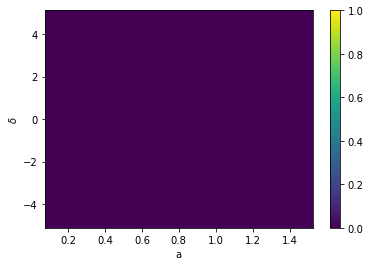

In [39]:
vmax = 1.
norm = np.pi*z_max**2*(x_max-x_min)
plt.pcolor(v_a,v_delta,v_sa.T/norm, vmax=vmax, shading="auto")
plt.xlabel("a")
plt.ylabel(r"$\delta$")
plt.colorbar()

In [38]:
v_x_exc

NameError: name 'v_x_exc' is not defined

In [24]:
v_sa_0 = v_sa

In [121]:
## Define parameters

# lattice parameters

# randomness: 
# True: a potential well is randomly selected for each emitter and some disorder is added with variance D_a
# False: N_exc particles on a 1D array with lattice separation a (can be used for check)
rand_positions = True 

N_exc = 50 # number of excitons
L = 10 # number potential wells to distribute the N_exc particles over
a = .5 # lattice distance in units of lambda
D_a = .01*a # disorder on positions (Guassian fluctuations around minima potential) in units of lambda

if not rand_positions:
    L = N_exc

# system parameters
#delta = -0.1344 # detuning between pump and exciton resonance 
delta = -1.
D_delta = 0.*np.abs(delta) # disorder on resonances (Gaussian standard deviation)
gamma = 1. # decay rate excitons
E = 1. # energy intensity incident light (uniform beam now, but that can be changed if e.g. spatial Gaussian profile would be necessary)
pol = 'x' # angle of polarization 0. is along x-axis, where excitons are positioned, pi is perpendicular to that

epsilon = 12.25 # dielectric constant GaAs (units of epsilon_0)
c = 1. # speed of light

N_samples = 20 # number of samples you want to use to average over


In [90]:
## Obtain effective polarizations of emitters by self-consistent evaluation

data = {"polarization":[],"x":[],"alpha":[],"delta":[]}

rng = default_rng()

print("Obtaining samples of polarizations...\n")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):

    # create array of random positions and resonances
    if rand_positions:
        v_x_exc = a*rng.integers(0,L, size=N_exc) + rng.normal( scale=D_a, size=N_exc)
    else:
        v_x_exc = a*np.linspace(1.,N_exc,N_exc)
    v_delta_exc = delta + rng.normal( scale=D_delta, size=N_exc)

    # create matrix (\alpha G)_ij 
    v_alpha = alpha(v_delta_exc, gamma)
    r_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:])
    A = create_A(r_ij,v_alpha)

    # create vector p0 (with random sampled delta)
    p0 = v_alpha*E

    # solve
    data["polarization"].append( linalg.solve(np.eye(N_exc)-A, p0) )

    # save others
    data["x"].append( v_x_exc )
    data["delta"].append( v_delta_exc )
    data["alpha"].append( v_alpha )

    bar.update( i )

    bar.finish()


[========================================================================] 100%


Obtaining samples of polarizations...



In [91]:
# The grid for reconstruction
x_min, x_max, n_x = -0.1*L*a, 1.1*(L-1)*a, 256
z_min, z_max, n_z = 0., 10.*a, 128

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_z = np.linspace(z_min, z_max, n_z)

d_x = v_x[1] - v_x[0]
d_r = v_z[1] - v_z[0]

data["scattered_amplitude"] = []


print("Reconstructing field for each sample...")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):
    field = reconstruct_field(v_x, v_z, data["x"][i], data["polarization"][i] )
    data["scattered_amplitude"].append( 2.*np.pi*np.sum( v_z*np.sum(np.abs(field), axis=0 )*d_x )*d_r )
    bar.update(i+1)
bar.finish()

Reconstructing field for each sample...


[========================================================================] 100%


In [92]:
for i, sc in enumerate(data["scattered_amplitude"]):
    print("{}: {}".format(i,sc))

0: 0.4699243581237985
1: 2.213970540196523
2: 0.34128393100091103
3: 3.9752712919939643
4: 0.004716195171238117
5: 0.0006920242204829572
6: 0.22878090511592564
7: 0.0008032343948549456
8: 0.25833981440468734
9: 0.00894434862815428
10: 0.0030226567338353582
11: 4.428348882937424
12: 0.020246578058809337
13: 0.012250222229938724
14: 4.192886184308523
15: 0.7726178106579137
16: 4.376751875489577
17: 4.237207319130159
18: 0.10104747988330429
19: 0.7570334694800259


In [83]:
# The grid for reconstruction
x_min, x_max, n_x = -0.1*L*a, 1.1*(L-1)*a, 50
z_min, z_max, n_z = -5.*a, 5.*a, 50
y_min, y_max, n_y = z_min, z_max, n_z

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_y = np.linspace(y_min, y_max, n_y)
v_z = np.linspace(z_min, z_max, n_z)

data["field"] = []

print("Reconstructing field for each sample...")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):
    data["field"].append( reconstruct_field_3D(v_x, v_y, v_z, data["x"][i], data["polarization"][i] ) )
    
    bar.update(i+1)
bar.finish()

Reconstructing field for each sample...


[========================================================================] 100%


<ipython-input-88-7a5a95254fa9>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[0].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,:,n_z//2].T)**2, vmax=vmax)
<ipython-input-88-7a5a95254fa9>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[1].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,n_y//2,:].T)**2, vmax=vmax)


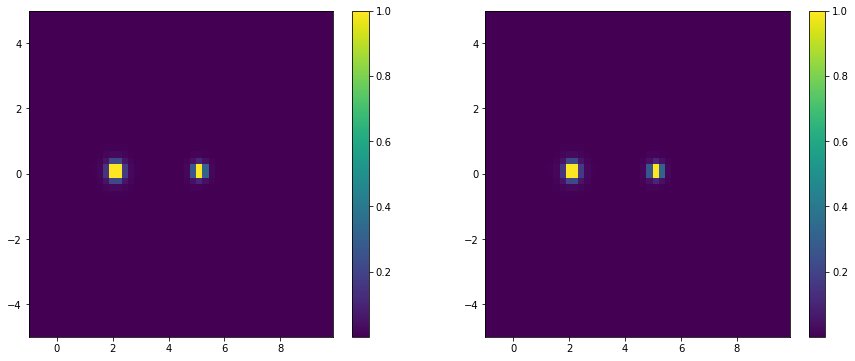

In [88]:
sample = 18
vmax = 1.
fig, ax = plt.subplots(1,2, figsize=(15,6))
pcm = ax[0].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,:,n_z//2].T)**2, vmax=vmax)
fig.colorbar(pcm, ax=ax[0])

pcm = ax[1].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,n_y//2,:].T)**2, vmax=vmax)
fig.colorbar(pcm, ax=ax[1])

In [56]:
np.max(np.abs(data["field"][sample][:,:,n_z//2]) - abs(data["field"][sample][:,n_y//2,:]))

4.440892098500626e-16